# Handwritten Digit Recognition App using Neural Networks
https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/

Data: MNIST dataset

Model: <a href="https://data-flair.training/blogs/convolutional-neural-networks-tutorial/">Convolutional Neural Networks</a>

Theory: <a href="https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training/neural-networks?autoAdvance=true&autoSkip=true&autoplay=true&resume=false&u=36492188">"Neural_Networks_and_Convolutional_Neural_Networks_Essential_Training"</a> LinkedIn course by Jonathan Fernandes.

Libraries: Keras, Tkinter for building GUI.

In the end, a GUI is built where one can draw a digit and recognize it straight away. If the image is misclassified, one can provide correct label and save the handwritten image and label. Corrections can then be added to the main image dataset for model re-training.

## 1. Libraries and MNIST dataset
MNIST dataset contains 60,000 training images of handwritten digits from 0 to 9 and 10,000 images for testing. Images have black background and white-gray digits. Digits are represented as a 28×28 matrix where each cell contains grayscale pixel value from 0 (black) to 255 (white). There are 10 classes, one for each digit.

The Keras library already contains some datasets and MNIST is one of them. So we can easily import the dataset and start working with it. The `mnist.load_data()` method returns us the training data, its labels and also the testing data and its labels.
#### Import packages

In [32]:
%reset -f
import os
os.chdir('C:/Sereda/Lectures/Springboard/Projects/DigitRecognition_CNN')

#pip install tensorflow
#pip install keras
#pip install pillow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # save image array to csv
# to view plots in notebook
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D   # convolutional NNs
from keras import backend as K
#from keras import utils as np_utils
#from tensorflow.keras import utils as np_utils
#from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical
#import tensorflow as tf

from PIL import Image, ImageGrab
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
# GUI
from keras.models import load_model
from tkinter import *
import tkinter as tk
import win32gui

#### Load the data

In [33]:
# the data, split between train and test sets
print("MNIST dataset")
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

MNIST dataset
X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


#### Plot an image to see if data is correct

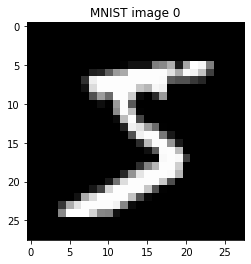

Label = 5


In [34]:
n = 0 # image number
img = X_train[n,:,:].astype('float32')/255
plt.imshow(img, cmap='gray')
plt.title(f'MNIST image {n}')
plt.show()
print(f"Label = {y_train[n]}")

## 2. Preprocessing
The image data cannot be fed directly into the model so we need to perform some operations and process the data to make it ready for our neural network. The dimension of the training data is (60000,28,28). The CNN model will require one more dimension so we reshape the matrix to shape (60000,28,28,1), while for non-convolutional NN it is (60000,$28^{2}$,1).
#### Training data format

In [35]:
# Keep image data as a matrix or convert to vector?
mx = True # True/False: If false - as 28^2 vector for NN, if true - as 28 x 28 matrix for CNN
sy = X_test.shape[1]; sx = X_test.shape[2]; # image sizes
if mx:
    print(f"Images as {sy} x {sx} matrixes for training")
    input_shape = (sy, sx, 1)
else:
    print(f"Images as {sy*sx}-component vectors for training")
    input_shape = (sy*sx, )
    X_train = X_train.reshape(-1,sy*sx)
    X_test = X_test.reshape(-1,sy*sx)
    print("New training size, X_train:",X_train.shape)
    print("New test size, X_test:",X_test.shape)

Images as 28 x 28 matrixes for training


#### Add manually labeled images
If some corrections were saved during previous digit recognitions, read them to add to the training dataset. Misclassified images were appended to a CSV file, and their manual labels were appended to a separate CSV file.

In [36]:
ml = 0; # manual labels
if ml>0:
    saved_images = 'images.csv' # (n, sy*sx) n vectors with sy*sx components of 0-255, no header
    saved_labels = 'labels.csv' # scalars, no header
    
    if os.path.exists(saved_images):
        print("Reading saved misclassified images with available labels:",saved_images)
        X_labeled = pd.read_csv(saved_images, header=None)
        print("Adding manually labeled images to MNIST training set, X_labeled:",X_labeled.shape)
        if mx:
            X_train = np.concatenate( (X_train, np.array(X_labeled).reshape(-1,sy,sx)) )
        else:
            X_train = np.concatenate( (X_train, np.array(X_labeled)) )
        print("New training size, X_train:",X_train.shape)
    else: print("No saved labeled images")
    
    if os.path.exists(saved_labels):
        print("Reading saved correct labels:",saved_labels)
        y_labeled = pd.read_csv(saved_labels, header=None)
        print("Adding manual labels to MNIST training labels, y_labeled:",y_labeled.shape)
        #y_train = np.concatenate( (y_train, np.array(y_labeled).reshape(-1)) )
        # Do we need to add last dimension 1 to y_train?
        y_train = np.concatenate((y_train.reshape(-1,1), np.array(y_labeled).ravel().reshape(-1,1)))
        print("New training labels size:",y_train.shape)
    else: print("No saved manual labels")
    
    # Verify
    print("Last label:",y_train[-1])
    print("Last image:")
    plt.imshow(X_train.reshape(-1,sy,sx)[-1], cmap='gray');

#### Scale predictors from 0 to 1 and one-hot encode labels

In [37]:
X_train = X_train.astype('float32')/255 # Convert to float to avoid problems during rescaling to 0-1.
# Could do 1-... to invert image and make white background with black digits.
X_test = X_test.astype('float32')/255 # 1-...
#print("min. X_train[0] =",np.min(X_train[0])) # 0-1
#print("max. X_train[0] =",np.max(X_train[0]))
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices using label encoding
num_classes=10   # 10 digits 0-9
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (60000, 28, 28)
X_test: (10000, 28, 28)
60000 train samples
10000 test samples
y_train: (60000, 10)
y_test: (10000, 10)


0


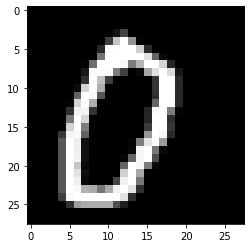

In [1121]:
#### Verify manual labels
nl=nl+1
plt.imshow(X_train.reshape(-1,sy,sx)[60000+nl], cmap='gray');
print(np.argmax(y_train[60000+nl]))

In [1122]:
print(nl)

645


## 3. Neural Network models in Keras
### 3.1 NN model

In [1123]:
# Create model
nl1 = 50; nl2 = 50; # neurons in NN layers
dropout = 0;#[0] 0.2;
nn = Sequential()
# Add the first hidden layer
#nn.add(Dense(nl1, activation='relu', input_shape=(28*28,))) # 50 nodes, ReLU activation function, input_shape indicated only once
nn.add(Dense(nl1, activation='relu', input_shape=(sy*sx,))) # 50 nodes, ReLU activation function, input_shape indicated only once
# Dropout
#nn.add(Dropout(dropout))
# Add the second hidden layer
nn.add(Dense(nl2, activation='relu')) #50,25
# Add the output layer
nn.add(Dense(10, activation='softmax'))

# Compile model
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','AUC'])
nn.summary()

print("Explanation of the number of weights:")
print("1st layer's parameters:",nl1*(sx*sy+1)) # Each of the 'nl1' nodes of layer 1 takes sx*sy inputs (pixels here) +1 due to bias
print("2nd layer's parameters:",nl2*(nl1+1)) # Each of the 'nl2' nodes of layer 2 takes 'nl1' inputs + 1 bias
print("output layer's parameters:",num_classes*(nl2+1)) # Each of the 10 output classes takes 'nl2' inputs + 1 bias

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                39250     
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Explanation of the number of weights:
1st layer's parameters: 39250
2nd layer's parameters: 2550
output layer's parameters: 510


### 3.2 Convolutional Neural Networks
A CNN model generally consists of convolutional and pooling layers. It works better for data that are represented as grid structures,- this is the reason why CNN works well for image classification problems. One image is distinguishable from another by its spatial structure. Areas close to each other are highly significant for an image.

However, fully connected neural networks typically don't work well on large images, since they don't scale well with image size. Example: 32 * 32 * 3 image = 3072 weights; 200 * 200 * 3 = 120000 weights. This large number of parameters can quickly lead to overfitting. One could work with smaller version of images, but one would lose information.

The dropout layer is used to deactivate some of the neurons and while training, it reduces overfitting of the model.

We will then compile the model with the Adadelta optimizer.
However, beware of poor scaling of compute time with image size.

#### Convolutions
* <b>Kernel</b> (filter, or matrix): 3 x 3 or 5 x 5. Center element of the kernel is placed over the source pixel. The source pixel is then replaced with the sum of elementwise products in the kernel and corresponding nearby source pixels.
* Convolve it over the image in all possible ways.
This gives 2D <b>activation map</b>. Convolving decreases the spatial size.

<b>Zero Padding</b>

Using n x n filter, we lose n-1 pixels in each of the 2 dimensions each time. To preserve the spatial size of the input (do not lose pixels), pad with 0's.

F: size of filter<br>
S: stride<br>
N: size of image<br>
P: amount of padding<br>
The image output size is given by $\frac{N-F+2P}{S}+1$

#### Pooling
<b>Max Pooling</b>

Keep only a maximal value from each block, e.g. 2 x 2.

<b>Average Pooling</b>

Keep only an average value from each block.
Why to use the pooling? To progressively reduce the size and chances of overfitting. Max pooling is more popular, as convolutions "light up" when they detect a particular feature in a region of an image. When downsampling, it makes sense to preserve the parts that were most activated.

#### Dropout
<b>Dropout</b> to prevent overfitting.
* Randomly kill each neuron in layer of a training set with probability p, typically 0.5 (half of the neurons in a layer are dropped during the training). Therefore, the network cannot rely on activation of any set of hidden units, since they may be turned off at any time during training, and the model is forced to learn more general and more robust patterns from the data.
We don't use dropout during validation of the data.

In [7]:
def mean_absolute_error(y_true, y_pred):
    loss = np.abs(y_pred - y_true)
    loss = np.mean(loss)
    return loss

In [38]:
if mx:
    nl1=32; nl2=64; dropout=0.25;
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    loss = 'categorical_crossentropy';    #categorical_crossentropy, mean_squared_error, mean_absolute_error
    optimizer='RMSProp' #'Adadelta','Adam','RMSProp'
    cnn.compile(loss=loss, optimizer=optimizer, metrics=['accuracy','AUC']) #optimizer=tf.keras.optimizers.Adadelta()
    cnn.summary()
    
    print("Explanation of the number of weights:")
    print("1st layer's parameters:",32*((28-3+2*1)//3+1)) # convolutions*nodes: Filter size = 3, Padding = 1, Stride = 3
    print("2nd layer's parameters:", (32*((26-3+2*1)//3+1) + 1)*64)
    print("6th layer's parameters:", (9216+1)*256)
    print("output layer's parameters:", (256+1)*10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2359552   
                                                      

### 3.3 Choose / load / train / save the model
If the model is newly created or its hyperparameters updated or new training data added, we train and save the model. Otherwise, if returning to already studied model, we load it from an HDF5 file.

In [ ]:
# Choose model
epochs = 200; #[200]
if mx:
    model = cnn
    #model_fn = 'models/cnn.e'+str(epochs)+'.h5' # HDF5 format
    model_fn = 'models/cnn_cce_'+optimizer+'.e'+str(epochs)+'.h5' # HDF5 format
else:
    model = nn
    #model_fn = 'models/nn_'+str(nl1)+'_'+str(nl2)+'.ml'+str(ml)+'.e'+str(epochs)+'.h5'
    model_fn = 'models/nn_'+str(nl1)+'_d0_'+str(nl2)+'.ml'+str(ml)+'.e'+str(epochs)+'.h5'

# If the model was previously trained, read the weights
if os.path.isfile(model_fn):
    print("Reading model weights:",model_fn)
    model.load_weights(model_fn)
# Otherwise, train and save the model
else:
    print("Train model")
    #model.fit(X_train, y_train, epochs=1)
    history_model = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test), verbose=1);
    print(history_model.params)
    print(history_model.history)
    if mx:
        pd.DataFrame(history_model.history).to_csv('performance/cnn_relu32_relu64_d'+str(dropout)+'.ml'+str(ml)+'.e'+str(epochs)+'.csv', index=None) # Save training performance
    else:
        pd.DataFrame(history_model.history).to_csv('performance/nn_relu50_d'+str(dropout)+'_relu50.ml'+str(ml)+'.e'+str(epochs)+'.csv', index=None) # Save training performance
    print("Save model:", model_fn)
    model.save(model_fn)

Train model
Epoch 1/200
 64/469 [===>..........................] - ETA: 49s - loss: 0.5267 - accuracy: 0.8351 - auc: 0.9831

The `model.fit()` function of Keras will start the training of the model. It takes the <b>training data, validation data, epochs,</b> and <b>batch size</b>. It takes some time to train the model. After training, we save the weights and model definition in the HDF5 file.

### 3.4. Evaluate the model
We have 10,000 images in our dataset which will be used to evaluate how good our model works. The testing data was not involved in the training of the model; therefore, it is new data for our model. The MNIST dataset is well balanced so we can get around 99% accuracy.

In [45]:
# NN model training history: read it if not in memory
try: history_model.history['loss'][:1] #history_model.head(1)
except NameError:
    if mx:
        history_model = pd.read_csv('performance/cnn_relu32_relu64_d'+str(dropout)+'.ml'+str(ml)+'.e'+str(epochs)+'.csv', header='infer')
    else:
        history_model = pd.read_csv('performance/nn_relu50_relu50.ml'+str(ml)+'.e'+str(epochs)+'.csv', header='infer')
        history_model[:2]

FileNotFoundError: [Errno 2] No such file or directory: 'performance/cnn_relu32_relu64_d0.25.ml0.e200.csv'

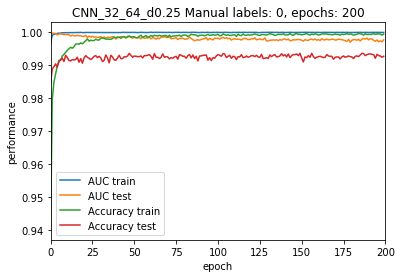

In [14]:
# Plot training performance
plt.plot(history_model.history['auc'])
plt.plot(history_model.history['val_auc'])
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.legend(['AUC train', 'AUC test', 'Accuracy train', 'Accuracy test']);
plt.xlabel('epoch');
plt.ylabel('performance');
plt.xlim(0,epochs)
if mx==True:
    plt.title('CNN_'+str(nl1)+'_'+str(nl2)+'_d'+str(dropout)+' Manual labels: '+str(ml) + ', epochs: '+str(epochs));
else:
    plt.title('NN_'+str(nl1)+'_d'+str(dropout)+'_'+str(nl2)+' Manual labels: '+str(ml) + ', epochs: '+str(epochs));

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06882394105195999
Test accuracy: 0.9926999807357788


Test scores after NN model training: 50 + 50 neurons, no dropout

|Manual labels|Epochs|Loss|Accuracy|
|:--:|:--:|:--:|:-----:|
|0  |200|0.272163|0.975200|
|200|200|0.260561|0.974100|
|400|200|0.242828|0.978000|
|600*|200|0.204577|0.978400|
|600|200|0.268606|0.973200|
|800|200|0.241012|0.976800|
|0  |400|0.380669|0.972900|

|model|nl1|dropout1|nl2|dropout2|manual_labels|loss|optimizer|epochs|test_loss|test_accuracy|trials|accuracy|
|:---:|:-:|:------:|:-:|:------:|:-----------:|:--:|:-------:|:----:|:-------:|:-----------:|:----:|:------:|
|NN|50|0|50|0|0|categorical_crossentropy|Adam|200|0.272163|0.9752|500|0.694|
|NN|50|0|25|0|0|categorical_crossentropy|Adam|200|0.278739|0.9733|150|0.573333|
|NN|50|0|75|0|0|categorical_crossentropy|Adam|200|0.248749|0.9771|150|0.566667|
|NN|50|0.2|50|0|0|categorical_crossentropy|Adam|200|0.154201|0.974|200|0.625|
|NN|50|0.5|50|0|0|categorical_crossentropy|Adam|200|0.113652|0.9684|200|0.635|
|NN|50|0.8|50|0|0|categorical_crossentropy|Adam|200|2.46691|0.3037|200|0.58|
|NN|50|0|50|0|200|categorical_crossentropy|Adam|200|0.260561|0.9741|500|0.851304|
|NN|50|0|50|0|400|categorical_crossentropy|Adam|200|0.242828|0.978|500|0.924|
|NN|50|0|50|0|600|categorical_crossentropy|Adam|200|0.268606|0.9732|500|0.924|
|NN|50|0|50|0|800|categorical_crossentropy|Adam|200|0.241012|0.9768|500|0.966|
|NN|50|0|50|0|0|categorical_crossentropy|Adam|400|0.380669|0.9729|150|0.593333|
|CNN|32|0.25|64|0.5|0|categorical_crossentropy|Adadelta|200|0.122603|0.9631|200|0.55|
|CNN|32|0.25|64|0.5|0|mean_squared_error|Adadelta|200|0.017082|0.8916|200|0.62|
|CNN|32|0.25|64|0.5|0|mean_absolute_error|Adadelta|200|0.022845|0.9011|200|0.585|
|CNN|32|0.25|64|0.5|0|categorical_crossentropy|Adadelta|400|0.011047|0.9285|200|0.55|
|CNN|32|0.25|64|0.5|0|categorical_crossentropy|Adam|200|0.068824|0.992700|200|0.83|

In [ ]:
# mx==True
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # cnn.e200.h5

### 3.5. Enhancements to CNNs
* <b>Image augmentation</b>: Taking images in training set and manipulating them to create many altered versions of the same image. There are more images for our model to train on.
Image manipulations make our model more robust. The distortions are random combinations of shifts, scaling, skewing, and compression.

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False) #True

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False) #True

jf_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=False) #True

In [ ]:
# Manually labaled images convert to matrix
try:
    X_labeled.head(1)
    X_labeled_mx = np.array(X_labeled).reshape(-1,28,28)
    X_labeled_mx.shape
    n=0 # image number
    print(y_labeled.iloc[n][0]) # correct label
    plt.imshow(X_labeled_mx[n], cmap='gray'); # visual verification
    try: y_labeled.shape
    except NameError:
        if os.path.exists(saved_labels):
            print("Reading saved correct labels:",saved_labels)
            y_labeled = pd.read_csv(saved_labels, header=None)
            # Save images
            for n in range(X_labeled_mx.shape[0]):
                # Convert numeric array to image
                im = Image.fromarray((X_labeled_mx[n]).astype(np.uint8))
                # Save image: subfolders are integer labels, create in advance!
                im.save('images_train/'+str(int(y_labeled.iloc[n][0]))+'/'+str(n)+'.png')
        else:
            print(f"Error: {saved_labels} does not exist!")
            print("Initialize y_labeled with image labels in vector form.")
    else:
        print(f"y_labeled was initialize earlier")
except NameError:
    print("No manually added data")

#### Check on a sample to see the image generators work as expected

In [ ]:
train_generator = train_datagen.flow_from_directory('images_train/', target_size=(150,150), save_to_dir='images_augm')

#### Generate variations of the images

In [ ]:
i=0
for batch in train_datagen.flow_from_directory('images_train/', target_size=(150,150), save_to_dir='images_augm'):
    i += 1
    if(i>10): break

## 4. Create GUI to predict digits
Here an interactive window (GUI) is created where one can draw a digit using mouse and get a prediction of what this digit is. The GUI is implemented using Tkinter library that comes in the Python standard library. The `App` class is responsible for building the GUI for our app. It has a canvas where one can draw by capturing the mouse event. Functions are triggered by pushing control buttons: button 'Clear' clears canvas and button 'Recognise' activates the function `predict_digit()` to recognize the digit. This function takes the image as input and then uses the trained model to predict the digit. The predicted label and its probability percentage are displayed.
### 4.1 Basic GUI

In [ ]:
#https://docs.python.org/3/library/tkinter.html
def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    #reshaping to support our model input and normalizing
    if mx: img = img.reshape(1,28,28,1)
    else: img = img.reshape(1,28*28,1)
    img = 1 - img/255.0
    #predicting the class
    res = model.predict([img])[0]
    return np.argmax(res), max(res)

class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        self.width = self.height = 60 # sizes of handwritten digit box
        # Creating elements
        #self.canvas = tk.Canvas(self, width=28, height=28, bg = "white", cursor="cross")
        self.canvas = tk.Canvas(self, width=self.width, height=self.height, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.button_classify = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.button_classify.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        #self.canvas.bind("<Motion>", self.start_pos)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    def clear_all(self):
        self.canvas.delete("all")
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit, acc = predict_digit(im)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=self.width//28
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')

#if mx: model = load_model('cnn.e200.h5')
#else: model = load_model('nn.e200.h5')
app = App()
mainloop()

### 4.2 GUI with added functionality
<b>Instructions:<b><br>
* If a handwritten digit is misclassified, press "Fix" button to add the image to train set, which will be concatenated with the MNIST data before next training cycle.
* Type in correct label and press "Get label" button to add the label to train set.
* Press "Save corrections" button to save manually labeled images and labels, and clean memory.

Accuracy % is displayed on the bottom right.

0 [6.]
1 [6. 9.]
2 [6. 9. 9.]
3 [6. 9. 9. 6.]
4 [6. 9. 9. 6. 7.]
5 [6. 9. 9. 6. 7. 8.]
6 [6. 9. 9. 6. 7. 8. 9.]
7 [6. 9. 9. 6. 7. 8. 9. 6.]
8 [6. 9. 9. 6. 7. 8. 9. 6. 7.]
9 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9.]
10 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7.]
11 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0.]
12 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1.]
13 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6.]
14 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7.]
15 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7.]
16 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6.]
17 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9.]
18 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6.]
19 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6. 7.]
20 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6. 7. 8.]
21 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6. 7. 8. 6.]
22 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6. 7. 8. 6. 7.]
23 [6. 9. 9. 6. 7. 8. 9. 6. 7. 9. 7. 0. 1. 6. 7. 7. 6. 9. 6. 7. 8. 

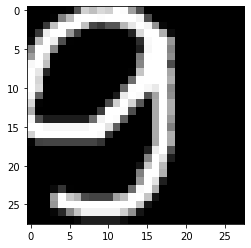

In [22]:
#https://docs.python.org/3/library/tkinter.html
#https://datatofish.com/entry-box-tkinter/

#model = load_model('nn.e200.h5')
def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    #reshaping to support our model input and normalizing
    if mx: img = img.reshape(1,28,28,1)
    else: img = img.reshape(1,28*28,1)
    img = img/255.0 # make pixels 0 to 1
    img = 1 - img # negate: black background, white digit (as in training data)
    #plt.imshow(img, cmap='gray');
    #predicting the class
    res = model.predict([img])[0]
    return np.argmax(res), max(res)
class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        # Parameters
        self.x = self.y = 0
        self.width = self.height = 60 # sizes of handwritten digit box
        self.i = 0 # counter of fixed labels
        self.cl = np.array([], dtype='float32') # corrected labels
        self.images_misclass = pd.DataFrame([], dtype='int') # incorrectly classified images
        self.n_ca = 0 # counter of correct answers
        self.n_aa = 0 # counter of all answers
        self.acc_running = 0 # running accuracy
        # Creating elements
        self.canvas = tk.Canvas(self, width=self.width, height=self.height, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Draw digit", font=("Helvetica", 48))
        self.button_classify = tk.Button(self, text = "Recognise", command =         self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        self.button_fix = tk.Button(self, text = "Fix", command = self.fix)
        self.entry1 = tk.Entry(self)
        self.canvas.create_window((self.width+2,self.height+2), window=self.entry1)
        self.button_getlabel = tk.Button(self, text='Get label', command=self.get_label)
        self.button_save = tk.Button(self, text='Save corrections', command=self.save)
        self.accuracy = tk.Label(self, text="Accuracy", font=("Helvetica", 28)) # running accuracy
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.button_classify.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
        self.button_fix.grid(row=2, column=0, pady=2, padx=2)
        self.entry1.grid(row=2, column=1, pady=2, padx=2)
        self.button_getlabel.grid(row=2, column=2, pady=2, padx=2)
        self.button_save.grid(row=3, column=1, pady=2, padx=2)
        self.accuracy.grid(row=3, column=2, pady=2, padx=2)
        
    def clear_all(self):
        self.canvas.delete("all")
        self.acc_running = self.n_ca/self.n_aa
        self.accuracy.configure(text= str(int(self.acc_running*100))+'%')
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        digit, acc = predict_digit(im)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
        self.n_ca += 1
        self.n_aa += 1
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=self.width//28
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')
    def get_label(self):
        '''Get and append correct label.'''
        y_label = int(self.entry1.get()) # text box gives a string
        self.cl = np.append(self.cl, y_label) # append corrected label
        print(self.i, self.cl)
        self.i = self.i + 1 # update counter of corrected labels
        self.canvas.delete("all") # clear canvas
        self.label.configure(text= 'Next image')
        self.n_ca -= 1
        self.acc_running = self.n_ca/self.n_aa
        self.accuracy.configure(text= str(int(self.acc_running*100))+'%')
    def fix(self):
        '''Get handwritten image for subsequent saving. Type instructions. Get and append correct label.'''
        global im # misclassified image
        # Grab misclassified image from canvas
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
        # Crop image padding
        left = 2 # pixels to crop on the left
        top = 2 # pixels to crop on top
        right = self.width + left
        bottom = self.height + top
        im = im.crop((left, top, right, bottom))
        # Grayscale, reshape, negate
        im = im.convert('L') # Convert rgb to grayscale
        im = im.resize((28,28)) # Reshape to support our training model input (MNIST) and normalizing
        im = np.array(im) # convert to numeric array
        im = 255 - im # negate: black background, white digit (as in training data)
        # Append misclassified image
        self.images_misclass = self.images_misclass.append(pd.DataFrame(im.reshape(1,28*28)), ignore_index=True)
        plt.imshow(im, cmap='gray')
        # Type instructions
        self.label.configure(text="Enter label\nHit Get label", font=("Helvetica", 48))
    def save(self):
        saved_images = 'images.csv'
        saved_labels = 'labels.csv'
        #print("Saving misclassified images:", saved_images)
        pd.DataFrame(self.images_misclass).to_csv(saved_images, index=False, header=None, mode='a') # append images to file
        #print("Saving correct labels:", saved_labels)
        pd.DataFrame(self.cl).to_csv(saved_labels, index=False, header=None, mode='a') # append labels to file
        self.images_misclass = pd.DataFrame([], dtype='int') # after saving, clear the memory
        self.cl = np.array([], dtype='float32')
        self.canvas.delete("all") # clear canvas
        self.label.configure(text= 'Next image')

#if mx: model = load_model('cnn.e200.h5')
#else: model = load_model('nn.e200.h5')
app = App()
mainloop();

The recognition of handwritten digits was tested by iterating over the digits from 0 to 9 until 200 misclassified digits were obtained. We started tracking the actual digits and their classifications after geting 78 misclassified digits during the development of GUI. At the end, we had 308 correctly classified and 122 misclassified images, so that the accuracy was $308/430 = 0.716279$.

#### Mann-Whitney U rank test
The assumptions of this test:
* The observations from the two groups should be randomly selected from the target populations.
* Observations are independent of each other. Indeed, samples are taken from tests of the models re-trained using different number of manually labeled images.
* Observations should be continuous or ordinal. We have ordinal 0, 1.

In [ ]:
import scipy.stats as stats
stats.mannwhitneyu(correctness_ml0, correctness_ml200, use_continuity=False, alternative='less')
# The Mann-Whitney U statistic and p-value

In [ ]:
stats.mannwhitneyu(correctness_ml200, correctness_ml400, use_continuity=False, alternative='less')

Due to a tiny p-value, we can confidently conclude that re-training with manually added labels leads to a statistically significant increase in the accuracy.

## Hyperparameter Optimization
Let's see how the digit recognition accuracy depend on the number of training epochs for different number of manually labeled images added to the training set.

Next we study the effect of the number of neurons in the 2nd layer.

Then we use a dropout before 2nd layer.

Neural networks are trained using stochastic gradient descent optimization algorithm and weights are updated using the backpropagation of error algorithm. This requires that you choose a loss function when designing and configuring your model, so we shall try different choices. The “gradient” in gradient descent refers to an error gradient. The model with a given set of weights is used to make predictions and the error for those predictions is calculated. The gradient descent algorithm seeks to change the weights so that the next evaluation reduces the error, meaning the optimization algorithm is navigating down the gradient (or slope) of error. Since we seek to minimize the error, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function is referred to as simply “loss.” The cost or loss function has an important job in that it must faithfully distill all aspects of the model down into a single number in such a way that improvements in that number are a sign of a better model.

In [ ]:
mx=True; ml=0; epochs=200; loss='mean_absolute_error'; # current model parameters

In [ ]:
%run gui.py # update model filename in it!

In [1129]:
mx=False; nl1=50; dropout=0; nl2=50; ml=800; epochs=200; err=False

Performance of NN 50-50 digit classification: 800 manual labels, 200 epochs.


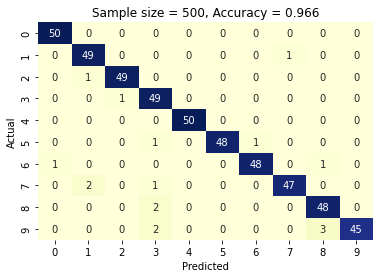

In [1130]:
print("Performance of NN 50-50 digit classification: "+str(ml)+" manual labels, "+str(epochs)+" epochs.")
# After adding 200 manually labeled misclassified images to the training set and re-training the NN model:
if (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*50),
        'prediction':np.array([0,1,2,3,4,0,3,7,2,9,0,1,2,3,4,5,6,7,3,9,0,1,2,3,4,5,6,3,8,9,6,1,2,3,6,5,5,2,8,3,0,8,2,3,4,5,5,7,3,5,\
        0,2,2,3,4,0,6,2,5,9,0,1,2,2,4,1,6,3,6,3,0,1,2,3,4,5,6,8,8,3,0,1,2,3,4,5,6,1,8,9,0,1,2,3,4,5,6,7,8,1,5,1,2,3,9,7,6,2,8,7,\
        0,1,2,3,4,5,6,2,8,7,6,1,2,3,4,5,6,1,8,5,7,3,2,3,4,5,6,7,5,6,5,1,2,3,4,5,5,3,8,9,0,1,2,3,4,5,6,3,8,3,9,1,2,3,4,5,6,8,3,3,\
        0,1,2,3,6,5,5,7,8,3,0,1,2,3,9,5,6,8,2,3,0,1,2,3,4,3,6,8,3,9,0,1,2,3,4,5,6,1,8,8,0,1,2,3,4,5,6,7,8,3,0,8,2,3,4,5,6,7,2,2,\
        3,6,2,3,4,5,5,7,8,9,0,1,2,3,4,5,6,7,3,9,0,9,2,3,4,5,6,7,3,3,0,1,2,3,4,5,6,2,8,5,0,8,2,3,4,3,6,7,2,3,6,2,2,3,4,7,6,1,8,9,\
        0,1,2,3,4,5,6,2,4,0,0,1,2,3,4,6,5,7,8,7,0,1,2,3,4,5,5,7,8,3,0,1,2,3,4,5,7,2,2,3,0,1,3,3,4,5,6,2,1,9,0,1,2,3,4,3,6,7,3,3,\
        0,3,3,3,4,5,6,3,3,3,0,1,2,3,4,5,5,7,2,8,0,1,2,3,4,5,6,2,6,9,0,1,2,3,4,5,6,1,8,9,0,1,2,3,4,5,0,7,3,9,0,1,2,3,6,5,6,2,8,3,\
        0,1,2,5,7,5,5,7,0,9,0,1,2,3,4,5,6,7,8,3,3,3,2,3,4,5,6,3,3,5,0,8,2,8,4,5,6,3,3,9,6,1,3,3,4,5,6,3,2,3,0,1,2,3,3,5,2,3,8,3,\
        0,1,2,3,4,5,6,3,8,3,0,8,2,3,5,3,6,3,2,3,0,8,2,3,4,3,5,7,3,3])}
    correctness_nn_50_50_ml0_e200 = list(map(int, perf['actual'] == perf['prediction'])) # for statistical test
elif (ml==200) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*115),
        'prediction':np.array([0,1,2,3,4,6,6,7,4,9,9,1,2,3,4,5,6,7,8,9,8,1,2,3,4,5,6,7,8,9,9,1,2,8,4,5,6,7,8,9,\
        9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,5,7,8,9,0,8,2,3,4,5,8,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,\
        0,1,3,3,4,5,8,7,8,9,0,1,2,3,4,5,6,9,8,9,0,1,2,3,4,5,6,7,8,8,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,9,6,0,7,8,3,7,1,2,9,4,5,5,7,8,9,0,1,2,3,4,5,6,7,8,9,8,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,2,8,3,9,1,2,9,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,2,8,0,1,2,3,4,5,6,7,2,9,0,1,2,3,4,8,6,7,8,3,0,8,2,9,4,5,5,8,8,7,0,1,2,3,4,5,6,7,8,9,7,8,2,3,4,5,6,7,6,0,\
        0,1,2,8,4,5,8,2,8,9,0,1,2,3,4,5,6,8,2,9,0,1,2,3,4,5,6,7,8,9,0,7,2,3,4,8,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,2,2,3,4,9,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,9,8,8,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,8,0,1,2,3,4,9,8,7,8,9,0,1,2,3,4,8,6,7,8,9,\
        0,8,2,9,4,9,6,7,8,9,0,2,2,3,9,5,6,7,8,2,0,1,8,2,4,5,5,7,3,9,9,1,2,3,9,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,9,5,6,2,8,8,\
        0,0,2,3,4,5,6,7,8,9,0,1,2,3,4,9,4,7,8,3,1,1,2,3,4,5,6,1,8,0,0,1,2,3,4,5,6,7,8,8,0,1,2,3,9,5,6,7,3,9,0,1,2,1,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,7,5,6,7,4,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,6,8,2,3,4,8,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,8,0,1,2,3,4,9,6,9,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,0,6,7,8,9,0,1,2,3,4,6,8,7,8,9,0,1,2,3,4,5,8,7,8,9,\
        6,1,2,3,4,5,6,7,8,9,0,1,8,5,4,5,6,2,8,9,9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,8,0,7,6,9,0,1,2,3,9,5,6,7,1,9,6,1,2,2,4,5,6,7,8,9,\
        0,1,9,3,4,5,5,7,8,9,0,1,2,1,4,5,6,7,8,9,0,1,2,3,4,5,5,7,8,9,0,1,2,3,4,9,8,2,6,9,1,1,2,9,4,5,6,7,8,9,0,1,2,3,4,9,6,3,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,9,9,0,1,2,3,4,9,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,9,6,7,8,9,\
        0,9,2,3,4,5,6,7,8,9,9,1,0,9,4,5,5,4,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,8,6,8,8,9,0,1,2,3,4,9,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,7,1,8,3,4,9,6,2,4,0,0,1,2,1,4,5,6,7,8,9,0,1,2,3,9,5,6,7,9,3,0,8,2,3,4,6,6,7,8,9,\
        9,1,2,3,4,5,6,7,8,9,9,1,2,3,4,5,6,7,8,9,0,7,2,3,4,5,6,2,8,9,0,1,2,3,4,5,8,7,8,9,0,1,2,3,9,5,5,7,8,9,0,1,2,3,4,9,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,7,9,1,2,3,4,5,5,7,8,9,0,1,2,2,4,5,6,9,8,9,0,1,2,3,4,5,6,7,5,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,9,5,8,7,8,9,0,1,2,3,7,5,6,7,8,9,\
        9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,9,5,8,2,4,5])}
    correctness_nn_50_50_ml200_e200 = list(map(int, perf['actual'] == perf['prediction']))
elif (ml==400) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*50),
        'prediction':np.array([0,1,2,3,4,5,6,7,8,9,6,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,7,0,1,2,9,4,5,8,7,6,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,9,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,9,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,7,2,3,4,5,6,7,8,7,0,1,2,3,4,5,6,7,8,9,\
        0,1,3,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,8,8,8,9,\
        0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,8,7,6,7,0,1,2,3,4,5,5,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,\
        9,1,2,3,9,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,6,6,2,2,9,8,1,2,3,4,5,6,7,8,0,0,1,2,3,4,5,6,7,7,9,0,1,2,3,4,5,8,7,8,9,\
        0,1,2,3,4,5,6,7,3,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,6,5,6,7,6,9,0,1,2,3,4,5,6,2,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,8,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,8,7,8,9,0,1,2,3,4,5,6,7,8,9,9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,8,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,2,9])}
    correctness_nn_50_50_ml400_e200 = list(map(int, perf['actual'] == perf['prediction']))
elif (ml==600) & (epochs==200) & (err == True):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*50),
        'prediction':np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,8,7,8,9,0,1,2,2,4,5,6,7,8,8,0,1,2,3,5,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,\
        9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,6,9,0,1,2,3,4,5,6,2,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,2,1,2,3,4,5,6,7,8,9,0,1,2,3,9,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,\
        2,1,2,3,4,5,6,7,3,7,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,9,6,7,8,8,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,5,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
        7,2,2,3,4,5,6,7,8,7,9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,9,1,2,3,4,5,6,2,8,9,\
        0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,\
        7,1,9,3,8,5,6,7,1,6,9,1,2,3,4,5,6,7,8,8,0,1,2,3,4,5,6,7,8,9])}
    correctness_nn_50_50_ml600_e200_old = list(map(int, perf['actual'] == perf['prediction']))
elif (ml==600) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*50),
     'prediction':np.array([0,1,8,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,9,1,2,3,4,6,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,2,9,\
     0,1,2,3,4,5,6,7,8,9,5,1,8,3,4,5,8,7,8,9,0,1,2,3,4,5,8,7,8,9,0,1,2,3,4,5,6,7,8,9,9,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,1,4,5,6,7,8,9,0,1,2,7,4,9,6,2,8,3,0,1,2,3,4,5,6,7,6,9,0,1,2,3,4,5,6,7,8,9,0,7,2,3,4,3,6,7,8,9,\
     0,1,2,3,4,5,8,2,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,9,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,\
     0,1,3,5,4,5,6,7,8,9,0,1,1,9,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,8,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,3,8,9,0,1,2,3,4,5,6,7,8,9,0,1,1,3,4,9,6,7,8,9,9,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,6,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,5,7,8,9,\
     0,1,2,3,4,5,0,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,3,8,9,0,1,2,3,4,5,6,7,8,9,0,1,8,3,4,5,6,7,8,9,0,1,2,3,4,5,8,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,3,8,9,0,1,2,3,4,5,0,7,8,9])}
    correctness_nn_50_50_ml600_e200 = list(map(int, perf['actual'] == perf['prediction']))
elif (ml==800) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*50),
     'prediction':np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,3,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,6,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,3,9,0,1,2,3,4,5,6,7,8,9,0,7,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,1,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,3,6,7,8,8,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,3,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,8,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,1,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,8,0,1,2,2,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,3,9,0,1,1,3,4,5,8,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,0,7,8,9,\
     0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9])}
    correctness_nn_50_50_ml800_e200 = list(map(int, perf['actual'] == perf['prediction']))
elif (ml==0) & (epochs==400):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*15),
        'prediction':np.array([0,1,2,3,4,3,5,2,8,3,0,5,2,3,4,3,9,7,3,9,0,8,2,3,4,3,5,2,3,3,6,5,2,3,4,5,8,3,8,3,6,1,2,3,4,5,6,3,3,9,\
            0,1,2,3,4,3,8,3,9,3,0,1,2,3,4,5,6,3,8,3,7,1,2,3,4,3,3,2,8,8,3,3,2,3,4,5,5,7,2,9,0,3,2,3,4,5,6,7,2,9,6,1,5,3,4,5,5,7,2,3,\
            0,1,2,3,4,5,5,3,8,9,0,1,2,3,1,3,5,2,8,3,0,1,2,3,9,3,0,3,9,3,0,1,2,3,7,5,6,3,3,9])}
    correctness_nn_50_50_ml0_e400 = list(map(int, perf['actual'] == perf['prediction']))
contingency_matrix = pd.crosstab(perf['prediction'], perf['actual'], rownames=['Predicted'], colnames=['Actual'])

# Confusion matrix calculated manually
def cm(digits,classf):
    CM = np.array([[0]*10]*10)
    for i in range(len(digits)):
        CM[digits[i]][classf[i]] = CM[digits[i]][classf[i]] + 1
    return CM
#print(contingency_matrix)
#print("Sample size:",len(perf['actual']))
#print("Accuracy=",np.sum([contingency_matrix[i][i] for i in range(10)]) / np.sum(np.sum(contingency_matrix)))
# Plot contingency matrix
import matplotlib.pyplot as plt
import seaborn as sn

plt.clf()
res = sn.heatmap(contingency_matrix.T, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.title(f"Sample size = {len(perf['actual'])}, Accuracy = {np.sum([contingency_matrix[i][i] for i in range(10)]) / np.sum(np.sum(contingency_matrix))}")
plt.savefig("fig/cm.nn_50_50.ml"+str(ml)+".e"+str(epochs)+".png", bbox_inches='tight', dpi=100)
plt.show();

In [1133]:
correctness = perf['actual'] == perf['prediction']
accuracy_cumulative = []
for i in range(len(correctness)):
    accuracy_cumulative.append(correctness[:i+1].sum()/(i+1))
accuracy_cumulative_nn_50_50_ml800_e200 = accuracy_cumulative
pd.DataFrame(accuracy_cumulative).to_csv('performance/accuracy_cumulative_nn_50_50_ml'+str(ml)+'_e'+str(epochs)+'.csv')

In [ ]:
plt.hist(accuracy_cumulative_ml0, bins=100);
plt.hist(accuracy_cumulative_ml200, bins=100);
plt.hist(accuracy_cumulative_ml400, bins=100);
plt.show();

0 [1.]
1 [1. 4.]
2 [1. 4. 6.]
3 [1. 4. 6. 7.]
4 [1. 4. 6. 7. 0.]
5 [1. 4. 6. 7. 0. 1.]
6 [1. 4. 6. 7. 0. 1. 6.]
7 [1. 4. 6. 7. 0. 1. 6. 8.]
8 [1. 4. 6. 7. 0. 1. 6. 8. 9.]
9 [1. 4. 6. 7. 0. 1. 6. 8. 9. 1.]
10 [1. 4. 6. 7. 0. 1. 6. 8. 9. 1. 0.]
11 [1. 4. 6. 7. 0. 1. 6. 8. 9. 1. 0. 1.]
12 [1. 4. 6. 7. 0. 1. 6. 8. 9. 1. 0. 1. 6.]
13 [1. 4. 6. 7. 0. 1. 6. 8. 9. 1. 0. 1. 6. 8.]


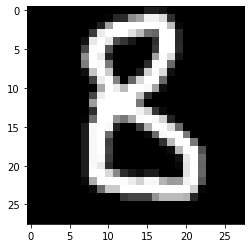

In [59]:
%run gui.py # update model filename in it!

In [25]:
# Current model parameters
#loss='categorical_crossentropy';
#loss='mean_squared_error';
(mx==True) & (nl1==32) & (nl2==64) & (dropout==0.25) & (ml==0) & (epochs==200) & (loss=='categorical_crossentropy')\
& (loss=='categorical_crossentropy')
#mx=True; nl1=32; nl2=64; dropout=0.25; ml=0; epochs=400; loss='categorical_crossentropy';

True

Performance of NN_32_64 digit classification: 0 manual labels, 200 epochs.


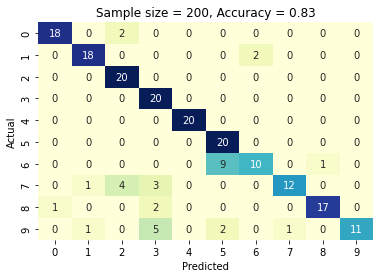

In [23]:
print(f"Performance of NN_{nl1}_{nl2} digit classification: "+str(ml)+" manual labels, "+str(epochs)+" epochs.")
if (nl1==50) & (nl2==25) & (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*15),
     'prediction':np.array([9,1,3,3,4,5,5,2,2,3,6,8,2,3,9,3,6,7,3,9,4,1,2,3,9,5,3,2,8,3,0,5,2,8,4,5,6,7,3,3,0,1,2,3,4,3,6,2,2,3,\
     0,1,2,3,9,6,3,7,8,3,0,1,2,3,4,5,6,2,8,3,0,3,3,3,4,3,6,7,3,3,0,8,2,3,4,9,3,2,8,3,0,1,5,3,4,5,5,2,2,9,0,8,2,3,4,5,5,0,3,9,\
     2,8,2,3,4,5,8,2,8,3,6,1,2,3,4,5,9,3,3,8,3,8,2,3,4,5,6,2,2,9,0,1,2,3,4,5,6,1,8,3])} #, 0,1,3 dobav'!!!
    correctness_nn_50_25_ml0_e200 = list(map(int, perf['actual'] == perf['prediction'])) # for statistical test
elif (nl1==50) & (nl2==75) & (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*15),
     'prediction':np.array([0,8,3,3,9,5,9,2,6,3,0,1,2,3,4,5,6,1,2,3,0,6,2,3,9,5,5,7,8,3,0,8,2,3,4,3,5,7,8,3,2,8,2,3,4,5,5,7,8,8,\
     0,1,2,5,4,3,2,7,3,3,7,8,2,2,4,5,8,7,3,3,0,8,2,3,4,3,6,2,2,7,0,5,2,3,2,5,8,7,8,9,2,1,2,9,9,5,6,2,6,9,0,1,2,3,4,5,8,3,3,3,\
     0,1,2,5,2,5,5,3,8,3,4,1,2,3,9,5,3,7,8,3,0,1,2,9,4,5,6,5,8,3,0,3,2,3,4,5,8,8,8,9])}
    correctness_nn_50_75_ml0_e200 = list(map(int, perf['actual'] == perf['prediction'])) # for statistical test
elif (nl1==50) & (dropout==0.2) & (nl2==50) & (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,0,2,3,4,6,5,2,6,9,0,8,2,3,4,5,6,7,3,9,0,1,2,3,4,5,5,2,8,9,0,1,2,3,4,5,5,3,8,3,0,8,2,3,4,5,6,2,3,3,\
     0,9,2,3,4,5,8,2,8,9,0,1,2,3,7,3,8,2,9,9,0,5,2,3,4,5,6,2,9,5,9,8,2,3,9,6,5,3,3,8,0,8,3,3,4,5,5,2,3,9,0,1,2,3,4,5,6,2,8,8,\
     6,8,2,3,4,3,5,3,8,3,0,1,2,3,8,5,6,7,3,3,4,1,2,3,3,5,6,2,8,9,0,5,2,3,4,6,6,2,3,9,9,1,2,3,4,5,6,4,8,3,0,1,2,3,4,6,5,2,8,9,\
     0,1,2,3,4,5,5,7,8,9,0,1,2,3,9,5,3,7,3,3,8,1,2,3,1,5,2,2,3,9])}
    correctness_nn_50_d2_50_ml0_e200 = list(map(int, perf['actual'] == perf['prediction'])) # for statistical test
elif (nl1==50) & (dropout==0.5) & (nl2==50) & (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,1,2,3,4,5,6,2,3,3,0,1,2,3,9,5,6,7,8,9,0,1,2,3,4,5,6,8,3,9,0,3,2,3,9,5,5,7,8,9,2,1,2,3,4,3,6,7,6,5,\
     2,1,5,3,4,5,3,2,8,3,0,1,2,3,4,5,6,2,2,9,2,1,2,3,4,5,8,2,3,3,0,1,2,3,4,5,6,7,3,9,0,3,3,3,4,5,5,7,2,3,0,3,2,3,9,3,8,2,8,9,\
     6,1,2,3,3,5,6,1,3,2,4,8,0,3,4,5,8,5,8,9,2,1,2,3,9,5,6,3,8,9,0,8,2,3,9,5,2,3,3,9,0,8,2,3,4,5,8,2,3,3,8,1,2,3,4,5,6,7,3,9,\
     0,1,2,3,4,5,6,8,3,3,0,0,2,3,9,5,6,2,3,9,2,6,2,3,4,5,5,7,2,3])}
elif (nl1==50) & (dropout==0.8) & (nl2==50) & (ml==0) & (epochs==200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([6,1,2,3,4,5,3,2,8,3,0,8,3,3,9,5,5,8,8,3,0,7,2,3,4,5,0,2,8,9,2,1,2,3,9,5,8,7,8,9,3,1,2,3,4,5,6,7,8,3,\
     0,8,3,3,4,5,6,2,3,6,7,9,3,2,4,5,3,3,8,3,0,1,2,3,4,5,5,8,8,3,0,1,2,3,4,5,6,2,8,3,9,1,2,3,4,5,5,3,8,3,0,1,2,3,4,5,6,7,2,9,\
     2,5,2,5,4,5,6,7,3,3,0,1,2,3,9,5,6,9,3,3,0,1,2,3,4,6,3,7,8,3,0,3,2,3,4,5,9,3,6,9,4,8,2,3,9,5,6,2,3,3,0,5,2,3,4,5,5,8,5,2,\
     4,8,2,3,8,5,3,7,2,3,6,8,2,3,9,5,8,7,3,9,0,7,2,3,1,6,5,3,8,3])}
elif (mx==True): # Convolutional Neural Net
 if loss == 'categorical_crossentropy':
  if optimizer == 'Adadelta':
   if epochs == 200:
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,3,2,3,8,3,6,2,8,9,0,1,2,3,4,5,6,2,8,3,0,1,2,3,9,5,6,2,3,7,0,1,2,3,9,5,5,5,9,3,8,1,2,3,9,5,3,7,8,7,\
     2,5,2,2,4,5,5,3,3,3,0,6,2,3,4,5,0,2,2,3,0,1,2,3,4,5,5,1,2,9,6,8,2,3,4,5,6,3,3,3,0,5,2,3,9,5,5,2,8,3,6,8,2,3,4,5,5,2,6,3,\
     0,8,2,3,9,5,8,8,3,9,0,1,2,3,8,5,6,2,3,9,0,1,2,3,4,6,3,1,8,9,0,1,2,3,3,5,6,7,3,9,6,2,3,3,9,5,6,2,8,3,0,8,2,3,4,3,2,7,5,2,\
     0,8,2,3,4,3,6,5,3,3,0,3,2,3,3,5,2,2,8,3,4,8,2,3,6,3,6,3,8,3])}
   elif epochs == 400:
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
    'prediction':np.array([0,1,2,3,4,3,6,3,2,9,0,8,2,3,9,5,2,8,8,3,2,8,2,3,9,5,2,2,8,9,0,6,2,3,4,5,6,2,8,8,0,1,2,3,4,5,8,7,3,9,\
     0,3,2,3,4,8,5,2,3,9,9,1,2,3,4,5,5,2,9,3,0,1,2,3,4,3,2,2,6,3,0,1,2,3,7,3,3,6,8,5,0,1,2,3,4,3,6,2,3,3,0,0,3,3,4,5,7,7,3,8,\
     0,6,2,3,4,6,3,7,8,9,0,1,2,3,4,5,0,2,3,3,0,4,2,3,9,3,5,7,6,3,6,8,3,3,4,3,6,5,5,3,6,1,2,3,2,5,3,3,8,9,0,8,3,3,5,5,9,3,3,3,\
     3,2,2,3,4,5,2,7,2,2,0,1,2,3,4,5,6,7,6,3,2,1,2,3,4,3,5,8,8,3])}
  elif optimizer == 'Adam':
   if epochs == 200:
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,1,2,3,4,5,5,7,8,3,0,1,2,3,4,5,6,7,8,5,0,1,2,3,4,5,5,2,3,3,0,1,2,3,4,5,5,2,8,5,0,1,2,3,4,5,6,1,8,9,\
     2,6,2,3,4,5,5,3,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,2,8,9,0,1,2,3,4,5,5,7,8,3,0,1,2,3,4,5,6,7,8,9,\
     0,1,2,3,4,5,5,3,0,9,0,1,2,3,4,5,5,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,3,3,3,2,6,2,3,4,5,5,2,8,1,\
     0,1,2,3,4,5,5,7,8,7,0,1,2,3,4,5,8,7,8,3,0,1,2,3,4,5,6,7,8,9])}

 elif loss == 'mean_squared_error':
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,8,2,3,4,5,9,7,8,9,9,8,7,3,4,5,9,7,3,9,2,1,2,2,4,5,6,5,8,3,2,1,2,3,4,5,3,7,8,8,6,1,2,3,4,5,5,7,5,9,\
     2,6,2,3,9,5,6,3,8,9,0,1,2,3,4,5,6,2,8,3,0,8,2,5,9,3,6,3,8,3,0,8,2,3,4,5,9,2,3,8,2,5,2,3,4,5,8,7,8,9,2,1,2,3,4,5,6,2,8,9,\
     0,1,2,3,4,3,6,5,8,3,6,8,2,3,4,5,2,3,8,9,0,3,3,3,9,5,6,2,3,9,6,1,3,3,3,5,6,7,2,9,2,1,2,3,4,5,5,5,3,3,0,8,2,3,4,5,6,2,8,9,\
     9,8,2,3,4,5,3,2,3,3,0,1,2,3,4,3,5,1,6,9,0,8,2,3,4,3,8,3,8,9])}
 elif (loss == 'mean_absolute_error') & (ml == 0) & (epochs == 200):
    perf = {'actual':np.array([0,1,2,3,4,5,6,7,8,9]*20),
     'prediction':np.array([0,1,2,3,4,3,6,2,5,8,6,6,2,3,4,3,5,3,8,3,3,1,2,3,9,5,3,8,8,3,9,8,2,3,4,5,6,2,3,9,0,8,2,3,4,5,6,1,8,3,\
     0,8,2,3,9,5,3,7,5,2,3,8,2,3,8,5,9,3,2,3,2,3,2,3,4,5,2,5,8,9,0,1,2,3,4,5,6,7,6,3,0,6,2,3,8,3,6,1,8,5,0,1,2,3,9,5,6,7,8,9,\
     9,8,3,3,8,5,5,7,3,9,9,1,2,3,4,5,5,7,8,3,8,6,3,3,4,3,3,7,3,3,0,9,2,3,8,5,6,7,8,2,0,8,2,3,9,5,2,7,8,3,0,7,2,3,4,3,0,2,8,9,\
     9,8,2,3,4,5,3,7,8,3,0,1,2,3,4,5,6,8,3,3,4,1,2,3,4,5,5,7,8,3])}
    
    correctness_cnn = list(map(int, perf['actual'] == perf['prediction'])) # for statistical test

contingency_matrix = pd.crosstab(perf['prediction'], perf['actual'], rownames=['Predicted'], colnames=['Actual'])

# Confusion matrix calculated manually
def cm(digits,classf):
    CM = np.array([[0]*10]*10)
    for i in range(len(digits)):
        CM[digits[i]][classf[i]] = CM[digits[i]][classf[i]] + 1
    return CM
#print(contingency_matrix)
# Plot contingency matrix
import matplotlib.pyplot as plt
import seaborn as sn

plt.clf()
res = sn.heatmap(contingency_matrix.T, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
plt.title(f"Sample size = {len(perf['actual'])}, Accuracy = {np.sum([contingency_matrix[i][i] for i in range(10)]) / np.sum(np.sum(contingency_matrix))}")
if mx == True:
    plt.savefig("fig/cm.cnn_mae_"+str(nl1)+"_"+str(nl2)+f"_d{dropout}.ml"+str(ml)+".e"+str(epochs)+".png", bbox_inches='tight', dpi=100)
else:
    plt.savefig("fig/cm.nn_"+str(nl1)+f"_d{dropout}_"+str(nl2)+".ml"+str(ml)+".e"+str(epochs)+".png", bbox_inches='tight', dpi=100)
plt.show();

In [24]:
correctness = perf['actual'] == perf['prediction']
accuracy_cumulative = []
for i in range(len(correctness)):
    accuracy_cumulative.append(correctness[:i+1].sum()/(i+1))
#accuracy_cumulative_nn_50_75_ml0_e200 = accuracy_cumulative
#pd.DataFrame(accuracy_cumulative).to_csv('performance/accuracy_cumulative_nn_'+str(nl1)+'_d'+str(10*dropout)+'_'+str(nl2)+'_ml'+str(ml)+'_e'+str(epochs)+'.csv')
pd.DataFrame(accuracy_cumulative).to_csv('performance/accuracy_cumulative_cnn_'+str(nl1)+'_'+str(nl2)+'_d'+str(dropout)+'_ml'+str(ml)+'_e'+str(epochs)+'.csv')
#print(f"accuracy_cumulative_nn_{nl1}_d{10*dropout}_{nl2}_ml{ml}_e{epochs} = {accuracy_cumulative}")
print(f"accuracy_cumulative_cnn_cce_{optimizer}_{nl1}_{nl2}_d{dropout}_ml{ml}_e{epochs} = {accuracy_cumulative}")

accuracy_cumulative_cnn_cce_Adam_32_64_d0.25_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.8, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8518518518518519, 0.8214285714285714, 0.7931034482758621, 0.7666666666666667, 0.7741935483870968, 0.78125, 0.7878787878787878, 0.7941176470588235, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7619047619047619, 0.7674418604651163, 0.7727272727272727, 0.7777777777777778, 0.782608695652174, 0.7872340425531915, 0.7708333333333334, 0.7755102040816326, 0.78, 0.7647058823529411, 0.75, 0.7547169811320755, 0.7592592592592593, 0.7636363636363637, 0.7678571428571429, 0.7543859649122807, 0.7413793103448276, 0.7457627118644068, 0.75

#### NN models

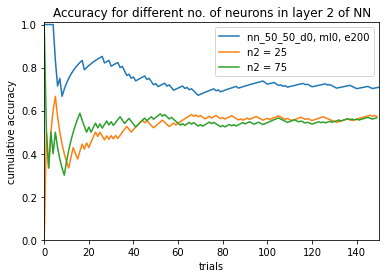

In [16]:
accuracy_cumulative_nn_50_d0_25_ml0_e200 = [0.0, 0.5, 0.3333333333333333, 0.5, 0.6, 0.6666666666666666, 0.5714285714285714, 0.5, 0.4444444444444444, 0.4, 0.36363636363636365, 0.3333333333333333, 0.38461538461538464, 0.42857142857142855, 0.4, 0.375, 0.4117647058823529, 0.4444444444444444, 0.42105263157894735, 0.45, 0.42857142857142855, 0.45454545454545453, 0.4782608695652174, 0.5, 0.48, 0.5, 0.48148148148148145, 0.4642857142857143, 0.4827586206896552, 0.4666666666666667, 0.4838709677419355, 0.46875, 0.48484848484848486, 0.47058823529411764, 0.4857142857142857, 0.5, 0.5135135135135135, 0.5263157894736842, 0.5128205128205128, 0.5, 0.5121951219512195, 0.5238095238095238, 0.5348837209302325, 0.5454545454545454, 0.5555555555555556, 0.5434782608695652, 0.5531914893617021, 0.5416666666666666, 0.5306122448979592, 0.52, 0.5294117647058824, 0.5384615384615384, 0.5471698113207547, 0.5555555555555556, 0.5454545454545454, 0.5357142857142857, 0.5263157894736842, 0.5344827586206896, 0.5423728813559322, 0.5333333333333333, 0.5409836065573771, 0.5483870967741935, 0.5555555555555556, 0.5625, 0.5692307692307692, 0.5757575757575758, 0.582089552238806, 0.5735294117647058, 0.5797101449275363, 0.5714285714285714, 0.5774647887323944, 0.5694444444444444, 0.5616438356164384, 0.5675675675675675, 0.5733333333333334, 0.5657894736842105, 0.5714285714285714, 0.5769230769230769, 0.569620253164557, 0.5625, 0.5679012345679012, 0.5609756097560976, 0.5662650602409639, 0.5714285714285714, 0.5764705882352941, 0.5697674418604651, 0.5632183908045977, 0.5568181818181818, 0.5617977528089888, 0.5555555555555556, 0.5604395604395604, 0.5652173913043478, 0.5591397849462365, 0.5638297872340425, 0.5684210526315789, 0.5729166666666666, 0.5670103092783505, 0.5612244897959183, 0.5555555555555556, 0.56, 0.5643564356435643, 0.5588235294117647, 0.5631067961165048, 0.5673076923076923, 0.5714285714285714, 0.5754716981132075, 0.5700934579439252, 0.5648148148148148, 0.5596330275229358, 0.5636363636363636, 0.5585585585585585, 0.5535714285714286, 0.5575221238938053, 0.5614035087719298, 0.5652173913043478, 0.5689655172413793, 0.5641025641025641, 0.559322033898305, 0.5630252100840336, 0.5583333333333333, 0.5537190082644629, 0.5573770491803278, 0.5609756097560976, 0.5645161290322581, 0.568, 0.5714285714285714, 0.5669291338582677, 0.5625, 0.5581395348837209, 0.5538461538461539, 0.549618320610687, 0.5454545454545454, 0.5488721804511278, 0.5522388059701493, 0.5555555555555556, 0.5588235294117647, 0.5620437956204379, 0.5579710144927537, 0.5539568345323741, 0.5571428571428572, 0.5602836879432624, 0.5633802816901409, 0.5664335664335665, 0.5694444444444444, 0.5724137931034483, 0.5753424657534246, 0.5782312925170068, 0.5743243243243243, 0.5771812080536913, 0.5733333333333334]
accuracy_cumulative_nn_50_d0_50_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.7894736842105263, 0.8, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8214285714285714, 0.8275862068965517, 0.8333333333333334, 0.8064516129032258, 0.8125, 0.8181818181818182, 0.8235294117647058, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7380952380952381, 0.7441860465116279, 0.75, 0.7555555555555555, 0.7608695652173914, 0.7446808510638298, 0.75, 0.7346938775510204, 0.72, 0.7254901960784313, 0.7115384615384616, 0.7169811320754716, 0.7222222222222222, 0.7272727272727273, 0.7142857142857143, 0.7192982456140351, 0.7068965517241379, 0.6949152542372882, 0.7, 0.7049180327868853, 0.7096774193548387, 0.7142857142857143, 0.703125, 0.7076923076923077, 0.696969696969697, 0.7014925373134329, 0.6911764705882353, 0.6811594202898551, 0.6714285714285714, 0.676056338028169, 0.6805555555555556, 0.684931506849315, 0.6891891891891891, 0.6933333333333334, 0.6973684210526315, 0.7012987012987013, 0.6923076923076923, 0.6962025316455697, 0.6875, 0.691358024691358, 0.6951219512195121, 0.6987951807228916, 0.7023809523809523, 0.7058823529411765, 0.7093023255813954, 0.7126436781609196, 0.7045454545454546, 0.7078651685393258, 0.7111111111111111, 0.7142857142857143, 0.717391304347826, 0.7204301075268817, 0.723404255319149, 0.7263157894736842, 0.7291666666666666, 0.7319587628865979, 0.7346938775510204, 0.7373737373737373, 0.73, 0.7227722772277227, 0.7254901960784313, 0.7281553398058253, 0.7307692307692307, 0.7238095238095238, 0.7169811320754716, 0.719626168224299, 0.7129629629629629, 0.7155963302752294, 0.7090909090909091, 0.7117117117117117, 0.7142857142857143, 0.7168141592920354, 0.7192982456140351, 0.7217391304347827, 0.7241379310344828, 0.7264957264957265, 0.7203389830508474, 0.7226890756302521, 0.7166666666666667, 0.7107438016528925, 0.7131147540983607, 0.7154471544715447, 0.717741935483871, 0.72, 0.7222222222222222, 0.7244094488188977, 0.71875, 0.7209302325581395, 0.7153846153846154, 0.7099236641221374, 0.7045454545454546, 0.706766917293233, 0.7089552238805971, 0.7111111111111111, 0.7132352941176471, 0.7153284671532847, 0.717391304347826, 0.7122302158273381, 0.7071428571428572, 0.7021276595744681, 0.704225352112676, 0.7062937062937062, 0.7083333333333334, 0.7103448275862069, 0.7123287671232876, 0.7074829931972789, 0.7027027027027027, 0.7046979865771812, 0.7066666666666667, 0.7086092715231788, 0.7105263157894737, 0.7124183006535948, 0.7142857142857143, 0.7161290322580646, 0.717948717948718, 0.7197452229299363, 0.7151898734177216, 0.7169811320754716, 0.7125, 0.7080745341614907, 0.7098765432098766, 0.7116564417177914, 0.7134146341463414, 0.7151515151515152, 0.7168674698795181, 0.718562874251497, 0.7142857142857143, 0.7100591715976331, 0.7058823529411765, 0.7076023391812866, 0.7093023255813954, 0.7109826589595376, 0.7126436781609196, 0.7085714285714285, 0.7102272727272727, 0.7062146892655368, 0.7078651685393258, 0.7094972067039106, 0.7055555555555556, 0.7071823204419889, 0.7087912087912088, 0.7103825136612022, 0.7119565217391305, 0.7081081081081081, 0.7096774193548387, 0.7112299465240641, 0.7074468085106383, 0.7037037037037037, 0.7, 0.7015706806282722, 0.703125, 0.7046632124352331, 0.7061855670103093, 0.7076923076923077, 0.7040816326530612, 0.7055837563451777, 0.702020202020202, 0.6984924623115578, 0.7, 0.7014925373134329, 0.7029702970297029, 0.7044334975369458, 0.7058823529411765, 0.7073170731707317, 0.7087378640776699, 0.7101449275362319, 0.7067307692307693, 0.7081339712918661, 0.7047619047619048, 0.7061611374407583, 0.7075471698113207, 0.7089201877934272, 0.7102803738317757, 0.7116279069767442, 0.7129629629629629, 0.7142857142857143, 0.7155963302752294, 0.7168949771689498, 0.7136363636363636, 0.7149321266968326, 0.7117117117117117, 0.7130044843049327, 0.7142857142857143, 0.7155555555555555, 0.7168141592920354, 0.7180616740088106, 0.7192982456140351, 0.7161572052401747, 0.7130434782608696, 0.70995670995671, 0.7068965517241379, 0.7081545064377682, 0.7094017094017094, 0.7106382978723405, 0.711864406779661, 0.7088607594936709, 0.7100840336134454, 0.7112970711297071, 0.7125, 0.7136929460580913, 0.7148760330578512, 0.7160493827160493, 0.7172131147540983, 0.7183673469387755, 0.7195121951219512, 0.7206477732793523, 0.7217741935483871, 0.7188755020080321, 0.72, 0.7211155378486056, 0.7182539682539683, 0.7193675889328063, 0.7204724409448819, 0.7215686274509804, 0.72265625, 0.7237354085603113, 0.7248062015503876, 0.722007722007722, 0.7192307692307692, 0.7203065134099617, 0.7213740458015268, 0.7224334600760456, 0.7234848484848485, 0.7245283018867924, 0.7255639097744361, 0.7265917602996255, 0.7238805970149254, 0.724907063197026, 0.7222222222222222, 0.7232472324723247, 0.7205882352941176, 0.7216117216117216, 0.7226277372262774, 0.7236363636363636, 0.7210144927536232, 0.7220216606498195, 0.7230215827338129, 0.7204301075268817, 0.7178571428571429, 0.7153024911032029, 0.7127659574468085, 0.7137809187279152, 0.7147887323943662, 0.7157894736842105, 0.7132867132867133, 0.7142857142857143, 0.7118055555555556, 0.71280276816609, 0.7137931034482758, 0.7147766323024055, 0.7157534246575342, 0.7167235494880546, 0.717687074829932, 0.7186440677966102, 0.7195945945945946, 0.7205387205387206, 0.7181208053691275, 0.7157190635451505, 0.7133333333333334, 0.7142857142857143, 0.7152317880794702, 0.7161716171617162, 0.7171052631578947, 0.7180327868852459, 0.7156862745098039, 0.7133550488599348, 0.7142857142857143, 0.7152103559870551, 0.7129032258064516, 0.7138263665594855, 0.7147435897435898, 0.7156549520766773, 0.7165605095541401, 0.7174603174603175, 0.7183544303797469, 0.7160883280757098, 0.7169811320754716, 0.7178683385579937, 0.715625, 0.7165109034267912, 0.717391304347826, 0.718266253869969, 0.7191358024691358, 0.72, 0.7208588957055214, 0.7186544342507645, 0.7164634146341463, 0.7142857142857143, 0.7121212121212122, 0.7129909365558912, 0.713855421686747, 0.7117117117117117, 0.7125748502994012, 0.7134328358208956, 0.7142857142857143, 0.7151335311572701, 0.7130177514792899, 0.7109144542772862, 0.711764705882353, 0.7126099706744868, 0.7134502923976608, 0.7142857142857143, 0.7151162790697675, 0.7159420289855073, 0.7138728323699421, 0.7146974063400576, 0.7155172413793104, 0.7134670487106017, 0.7114285714285714, 0.7122507122507122, 0.7102272727272727, 0.7082152974504249, 0.7090395480225988, 0.7098591549295775, 0.7106741573033708, 0.711484593837535, 0.7094972067039106, 0.7075208913649025, 0.7055555555555556, 0.7063711911357341, 0.7071823204419889, 0.7079889807162535, 0.7087912087912088, 0.7095890410958904, 0.7103825136612022, 0.7084468664850136, 0.7092391304347826, 0.7073170731707317, 0.7054054054054054, 0.706199460916442, 0.706989247311828, 0.707774798927614, 0.7085561497326203, 0.7093333333333334, 0.7101063829787234, 0.7108753315649867, 0.708994708994709, 0.7071240105540897, 0.7078947368421052, 0.7086614173228346, 0.7094240837696335, 0.7101827676240209, 0.7109375, 0.7116883116883117, 0.7124352331606217, 0.7131782945736435, 0.711340206185567, 0.712082262210797, 0.7128205128205128, 0.7135549872122762, 0.7142857142857143, 0.7150127226463104, 0.7157360406091371, 0.7164556962025317, 0.7171717171717171, 0.7153652392947103, 0.7160804020100503, 0.7142857142857143, 0.715, 0.71571072319202, 0.7164179104477612, 0.71712158808933, 0.7178217821782178, 0.7160493827160493, 0.7167487684729064, 0.7174447174447175, 0.7156862745098039, 0.7163814180929096, 0.7146341463414634, 0.7153284671532847, 0.7160194174757282, 0.7167070217917676, 0.714975845410628, 0.7132530120481928, 0.7139423076923077, 0.7122302158273381, 0.7129186602870813, 0.711217183770883, 0.7119047619047619, 0.7125890736342043, 0.7132701421800948, 0.7139479905437353, 0.714622641509434, 0.7152941176470589, 0.715962441314554, 0.7166276346604216, 0.7172897196261683, 0.717948717948718, 0.7162790697674418, 0.7146171693735499, 0.7129629629629629, 0.7136258660508084, 0.7142857142857143, 0.7149425287356321, 0.7155963302752294, 0.7162471395881007, 0.7146118721461188, 0.7129840546697038, 0.7113636363636363, 0.7120181405895691, 0.7104072398190046, 0.7110609480812641, 0.7094594594594594, 0.7101123595505618, 0.7107623318385651, 0.7114093959731543, 0.7098214285714286, 0.7082405345211581, 0.7088888888888889, 0.7073170731707317, 0.7079646017699115, 0.7064017660044151, 0.7070484581497798, 0.7076923076923077, 0.7083333333333334, 0.7089715536105032, 0.7074235807860262, 0.7058823529411765, 0.7043478260869566, 0.7049891540130152, 0.7056277056277056, 0.7062634989200864, 0.7068965517241379, 0.7053763440860215, 0.7060085836909872, 0.7044967880085653, 0.7029914529914529, 0.7036247334754797, 0.7021276595744681, 0.70276008492569, 0.7033898305084746, 0.7040169133192389, 0.7046413502109705, 0.7052631578947368, 0.7058823529411765, 0.7064989517819706, 0.7050209205020921, 0.7056367432150313, 0.7041666666666667, 0.7047817047817048, 0.7033195020746889, 0.7039337474120083, 0.7045454545454546, 0.7030927835051546, 0.7016460905349794, 0.702258726899384, 0.7008196721311475, 0.6993865030674846, 0.6979591836734694, 0.6985743380855397, 0.6971544715447154, 0.6977687626774848, 0.6983805668016194, 0.6989898989898989, 0.6975806451612904, 0.6961770623742455, 0.6967871485943775, 0.6953907815631263, 0.694]
accuracy_cumulative_nn_50_d0_75_ml0_e200 = [1.0, 0.5, 0.3333333333333333, 0.5, 0.4, 0.5, 0.42857142857142855, 0.375, 0.3333333333333333, 0.3, 0.36363636363636365, 0.4166666666666667, 0.46153846153846156, 0.5, 0.5333333333333333, 0.5625, 0.5882352941176471, 0.5555555555555556, 0.5263157894736842, 0.5, 0.5238095238095238, 0.5, 0.5217391304347826, 0.5416666666666666, 0.52, 0.5384615384615384, 0.5185185185185185, 0.5357142857142857, 0.5517241379310345, 0.5333333333333333, 0.5483870967741935, 0.53125, 0.5454545454545454, 0.5588235294117647, 0.5714285714285714, 0.5555555555555556, 0.5405405405405406, 0.5526315789473685, 0.5641025641025641, 0.55, 0.5365853658536586, 0.5238095238095238, 0.5348837209302325, 0.5454545454545454, 0.5555555555555556, 0.5652173913043478, 0.5531914893617021, 0.5625, 0.5714285714285714, 0.56, 0.5686274509803921, 0.5769230769230769, 0.5849056603773585, 0.5740740740740741, 0.5818181818181818, 0.5714285714285714, 0.5614035087719298, 0.5689655172413793, 0.559322033898305, 0.55, 0.5409836065573771, 0.532258064516129, 0.5396825396825397, 0.53125, 0.5384615384615384, 0.5454545454545454, 0.5373134328358209, 0.5441176470588235, 0.5362318840579711, 0.5285714285714286, 0.5352112676056338, 0.5277777777777778, 0.5342465753424658, 0.5405405405405406, 0.5466666666666666, 0.5394736842105263, 0.5454545454545454, 0.5384615384615384, 0.5316455696202531, 0.525, 0.5308641975308642, 0.524390243902439, 0.5301204819277109, 0.5357142857142857, 0.5294117647058824, 0.5348837209302325, 0.5287356321839081, 0.5340909090909091, 0.5393258426966292, 0.5444444444444444, 0.5384615384615384, 0.5434782608695652, 0.5483870967741935, 0.5425531914893617, 0.5368421052631579, 0.5416666666666666, 0.5463917525773195, 0.5408163265306123, 0.5353535353535354, 0.54, 0.5445544554455446, 0.5490196078431373, 0.5533980582524272, 0.5576923076923077, 0.5619047619047619, 0.5660377358490566, 0.5607476635514018, 0.5555555555555556, 0.5504587155963303, 0.5454545454545454, 0.5495495495495496, 0.5535714285714286, 0.5575221238938053, 0.5526315789473685, 0.5478260869565217, 0.5517241379310345, 0.5470085470085471, 0.5423728813559322, 0.5462184873949579, 0.5416666666666666, 0.5371900826446281, 0.5409836065573771, 0.5447154471544715, 0.5483870967741935, 0.544, 0.5476190476190477, 0.5433070866141733, 0.546875, 0.5503875968992248, 0.5461538461538461, 0.549618320610687, 0.553030303030303, 0.556390977443609, 0.5522388059701493, 0.5555555555555556, 0.5588235294117647, 0.5620437956204379, 0.5579710144927537, 0.5611510791366906, 0.5571428571428572, 0.5602836879432624, 0.5563380281690141, 0.5594405594405595, 0.5625, 0.5655172413793104, 0.5684931506849316, 0.564625850340136, 0.5608108108108109, 0.5637583892617449, 0.5666666666666667]
plt.plot(accuracy_cumulative_nn_50_d0_50_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d0_25_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d0_75_ml0_e200)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_nn_50_d0_25_ml0_e200))
plt.ylim(0,1.01)
plt.ylabel('cumulative accuracy')
plt.legend(['nn_50_50_d0, ml0, e200', 'n2 = 25', 'n2 = 75'])
plt.title('Accuracy for different no. of neurons in layer 2 of NN');

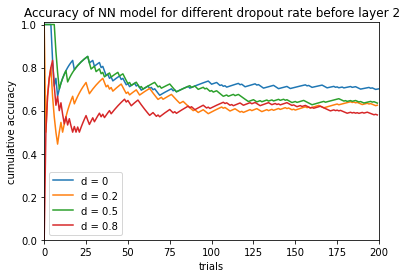

In [10]:
accuracy_cumulative_nn_50_d0_50_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.7894736842105263, 0.8, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8214285714285714, 0.8275862068965517, 0.8333333333333334, 0.8064516129032258, 0.8125, 0.8181818181818182, 0.8235294117647058, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7380952380952381, 0.7441860465116279, 0.75, 0.7555555555555555, 0.7608695652173914, 0.7446808510638298, 0.75, 0.7346938775510204, 0.72, 0.7254901960784313, 0.7115384615384616, 0.7169811320754716, 0.7222222222222222, 0.7272727272727273, 0.7142857142857143, 0.7192982456140351, 0.7068965517241379, 0.6949152542372882, 0.7, 0.7049180327868853, 0.7096774193548387, 0.7142857142857143, 0.703125, 0.7076923076923077, 0.696969696969697, 0.7014925373134329, 0.6911764705882353, 0.6811594202898551, 0.6714285714285714, 0.676056338028169, 0.6805555555555556, 0.684931506849315, 0.6891891891891891, 0.6933333333333334, 0.6973684210526315, 0.7012987012987013, 0.6923076923076923, 0.6962025316455697, 0.6875, 0.691358024691358, 0.6951219512195121, 0.6987951807228916, 0.7023809523809523, 0.7058823529411765, 0.7093023255813954, 0.7126436781609196, 0.7045454545454546, 0.7078651685393258, 0.7111111111111111, 0.7142857142857143, 0.717391304347826, 0.7204301075268817, 0.723404255319149, 0.7263157894736842, 0.7291666666666666, 0.7319587628865979, 0.7346938775510204, 0.7373737373737373, 0.73, 0.7227722772277227, 0.7254901960784313, 0.7281553398058253, 0.7307692307692307, 0.7238095238095238, 0.7169811320754716, 0.719626168224299, 0.7129629629629629, 0.7155963302752294, 0.7090909090909091, 0.7117117117117117, 0.7142857142857143, 0.7168141592920354, 0.7192982456140351, 0.7217391304347827, 0.7241379310344828, 0.7264957264957265, 0.7203389830508474, 0.7226890756302521, 0.7166666666666667, 0.7107438016528925, 0.7131147540983607, 0.7154471544715447, 0.717741935483871, 0.72, 0.7222222222222222, 0.7244094488188977, 0.71875, 0.7209302325581395, 0.7153846153846154, 0.7099236641221374, 0.7045454545454546, 0.706766917293233, 0.7089552238805971, 0.7111111111111111, 0.7132352941176471, 0.7153284671532847, 0.717391304347826, 0.7122302158273381, 0.7071428571428572, 0.7021276595744681, 0.704225352112676, 0.7062937062937062, 0.7083333333333334, 0.7103448275862069, 0.7123287671232876, 0.7074829931972789, 0.7027027027027027, 0.7046979865771812, 0.7066666666666667, 0.7086092715231788, 0.7105263157894737, 0.7124183006535948, 0.7142857142857143, 0.7161290322580646, 0.717948717948718, 0.7197452229299363, 0.7151898734177216, 0.7169811320754716, 0.7125, 0.7080745341614907, 0.7098765432098766, 0.7116564417177914, 0.7134146341463414, 0.7151515151515152, 0.7168674698795181, 0.718562874251497, 0.7142857142857143, 0.7100591715976331, 0.7058823529411765, 0.7076023391812866, 0.7093023255813954, 0.7109826589595376, 0.7126436781609196, 0.7085714285714285, 0.7102272727272727, 0.7062146892655368, 0.7078651685393258, 0.7094972067039106, 0.7055555555555556, 0.7071823204419889, 0.7087912087912088, 0.7103825136612022, 0.7119565217391305, 0.7081081081081081, 0.7096774193548387, 0.7112299465240641, 0.7074468085106383, 0.7037037037037037, 0.7, 0.7015706806282722, 0.703125, 0.7046632124352331, 0.7061855670103093, 0.7076923076923077, 0.7040816326530612, 0.7055837563451777, 0.702020202020202, 0.6984924623115578, 0.7, 0.7014925373134329, 0.7029702970297029, 0.7044334975369458, 0.7058823529411765, 0.7073170731707317, 0.7087378640776699, 0.7101449275362319, 0.7067307692307693, 0.7081339712918661, 0.7047619047619048, 0.7061611374407583, 0.7075471698113207, 0.7089201877934272, 0.7102803738317757, 0.7116279069767442, 0.7129629629629629, 0.7142857142857143, 0.7155963302752294, 0.7168949771689498, 0.7136363636363636, 0.7149321266968326, 0.7117117117117117, 0.7130044843049327, 0.7142857142857143, 0.7155555555555555, 0.7168141592920354, 0.7180616740088106, 0.7192982456140351, 0.7161572052401747, 0.7130434782608696, 0.70995670995671, 0.7068965517241379, 0.7081545064377682, 0.7094017094017094, 0.7106382978723405, 0.711864406779661, 0.7088607594936709, 0.7100840336134454, 0.7112970711297071, 0.7125, 0.7136929460580913, 0.7148760330578512, 0.7160493827160493, 0.7172131147540983, 0.7183673469387755, 0.7195121951219512, 0.7206477732793523, 0.7217741935483871, 0.7188755020080321, 0.72, 0.7211155378486056, 0.7182539682539683, 0.7193675889328063, 0.7204724409448819, 0.7215686274509804, 0.72265625, 0.7237354085603113, 0.7248062015503876, 0.722007722007722, 0.7192307692307692, 0.7203065134099617, 0.7213740458015268, 0.7224334600760456, 0.7234848484848485, 0.7245283018867924, 0.7255639097744361, 0.7265917602996255, 0.7238805970149254, 0.724907063197026, 0.7222222222222222, 0.7232472324723247, 0.7205882352941176, 0.7216117216117216, 0.7226277372262774, 0.7236363636363636, 0.7210144927536232, 0.7220216606498195, 0.7230215827338129, 0.7204301075268817, 0.7178571428571429, 0.7153024911032029, 0.7127659574468085, 0.7137809187279152, 0.7147887323943662, 0.7157894736842105, 0.7132867132867133, 0.7142857142857143, 0.7118055555555556, 0.71280276816609, 0.7137931034482758, 0.7147766323024055, 0.7157534246575342, 0.7167235494880546, 0.717687074829932, 0.7186440677966102, 0.7195945945945946, 0.7205387205387206, 0.7181208053691275, 0.7157190635451505, 0.7133333333333334, 0.7142857142857143, 0.7152317880794702, 0.7161716171617162, 0.7171052631578947, 0.7180327868852459, 0.7156862745098039, 0.7133550488599348, 0.7142857142857143, 0.7152103559870551, 0.7129032258064516, 0.7138263665594855, 0.7147435897435898, 0.7156549520766773, 0.7165605095541401, 0.7174603174603175, 0.7183544303797469, 0.7160883280757098, 0.7169811320754716, 0.7178683385579937, 0.715625, 0.7165109034267912, 0.717391304347826, 0.718266253869969, 0.7191358024691358, 0.72, 0.7208588957055214, 0.7186544342507645, 0.7164634146341463, 0.7142857142857143, 0.7121212121212122, 0.7129909365558912, 0.713855421686747, 0.7117117117117117, 0.7125748502994012, 0.7134328358208956, 0.7142857142857143, 0.7151335311572701, 0.7130177514792899, 0.7109144542772862, 0.711764705882353, 0.7126099706744868, 0.7134502923976608, 0.7142857142857143, 0.7151162790697675, 0.7159420289855073, 0.7138728323699421, 0.7146974063400576, 0.7155172413793104, 0.7134670487106017, 0.7114285714285714, 0.7122507122507122, 0.7102272727272727, 0.7082152974504249, 0.7090395480225988, 0.7098591549295775, 0.7106741573033708, 0.711484593837535, 0.7094972067039106, 0.7075208913649025, 0.7055555555555556, 0.7063711911357341, 0.7071823204419889, 0.7079889807162535, 0.7087912087912088, 0.7095890410958904, 0.7103825136612022, 0.7084468664850136, 0.7092391304347826, 0.7073170731707317, 0.7054054054054054, 0.706199460916442, 0.706989247311828, 0.707774798927614, 0.7085561497326203, 0.7093333333333334, 0.7101063829787234, 0.7108753315649867, 0.708994708994709, 0.7071240105540897, 0.7078947368421052, 0.7086614173228346, 0.7094240837696335, 0.7101827676240209, 0.7109375, 0.7116883116883117, 0.7124352331606217, 0.7131782945736435, 0.711340206185567, 0.712082262210797, 0.7128205128205128, 0.7135549872122762, 0.7142857142857143, 0.7150127226463104, 0.7157360406091371, 0.7164556962025317, 0.7171717171717171, 0.7153652392947103, 0.7160804020100503, 0.7142857142857143, 0.715, 0.71571072319202, 0.7164179104477612, 0.71712158808933, 0.7178217821782178, 0.7160493827160493, 0.7167487684729064, 0.7174447174447175, 0.7156862745098039, 0.7163814180929096, 0.7146341463414634, 0.7153284671532847, 0.7160194174757282, 0.7167070217917676, 0.714975845410628, 0.7132530120481928, 0.7139423076923077, 0.7122302158273381, 0.7129186602870813, 0.711217183770883, 0.7119047619047619, 0.7125890736342043, 0.7132701421800948, 0.7139479905437353, 0.714622641509434, 0.7152941176470589, 0.715962441314554, 0.7166276346604216, 0.7172897196261683, 0.717948717948718, 0.7162790697674418, 0.7146171693735499, 0.7129629629629629, 0.7136258660508084, 0.7142857142857143, 0.7149425287356321, 0.7155963302752294, 0.7162471395881007, 0.7146118721461188, 0.7129840546697038, 0.7113636363636363, 0.7120181405895691, 0.7104072398190046, 0.7110609480812641, 0.7094594594594594, 0.7101123595505618, 0.7107623318385651, 0.7114093959731543, 0.7098214285714286, 0.7082405345211581, 0.7088888888888889, 0.7073170731707317, 0.7079646017699115, 0.7064017660044151, 0.7070484581497798, 0.7076923076923077, 0.7083333333333334, 0.7089715536105032, 0.7074235807860262, 0.7058823529411765, 0.7043478260869566, 0.7049891540130152, 0.7056277056277056, 0.7062634989200864, 0.7068965517241379, 0.7053763440860215, 0.7060085836909872, 0.7044967880085653, 0.7029914529914529, 0.7036247334754797, 0.7021276595744681, 0.70276008492569, 0.7033898305084746, 0.7040169133192389, 0.7046413502109705, 0.7052631578947368, 0.7058823529411765, 0.7064989517819706, 0.7050209205020921, 0.7056367432150313, 0.7041666666666667, 0.7047817047817048, 0.7033195020746889, 0.7039337474120083, 0.7045454545454546, 0.7030927835051546, 0.7016460905349794, 0.702258726899384, 0.7008196721311475, 0.6993865030674846, 0.6979591836734694, 0.6985743380855397, 0.6971544715447154, 0.6977687626774848, 0.6983805668016194, 0.6989898989898989, 0.6975806451612904, 0.6961770623742455, 0.6967871485943775, 0.6953907815631263, 0.694]
accuracy_cumulative_nn_50_d2_50_ml0_e200 = [1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.6666666666666666, 0.5714285714285714, 0.5, 0.4444444444444444, 0.5, 0.5454545454545454, 0.5, 0.5384615384615384, 0.5714285714285714, 0.6, 0.625, 0.6470588235294118, 0.6666666666666666, 0.631578947368421, 0.65, 0.6666666666666666, 0.6818181818181818, 0.6956521739130435, 0.7083333333333334, 0.72, 0.7307692307692307, 0.7037037037037037, 0.6785714285714286, 0.6896551724137931, 0.7, 0.7096774193548387, 0.71875, 0.7272727272727273, 0.7352941176470589, 0.7428571428571429, 0.75, 0.7297297297297297, 0.7105263157894737, 0.717948717948718, 0.7, 0.7073170731707317, 0.6904761904761905, 0.6976744186046512, 0.7045454545454546, 0.7111111111111111, 0.717391304347826, 0.723404255319149, 0.7083333333333334, 0.6938775510204082, 0.68, 0.6862745098039216, 0.6730769230769231, 0.6792452830188679, 0.6851851851851852, 0.6909090909090909, 0.6964285714285714, 0.6842105263157895, 0.6724137931034483, 0.6779661016949152, 0.6833333333333333, 0.6885245901639344, 0.6935483870967742, 0.6984126984126984, 0.703125, 0.6923076923076923, 0.6818181818181818, 0.6716417910447762, 0.6617647058823529, 0.6521739130434783, 0.6571428571428571, 0.6619718309859155, 0.6527777777777778, 0.6575342465753424, 0.6621621621621622, 0.6666666666666666, 0.6710526315789473, 0.6753246753246753, 0.6666666666666666, 0.6582278481012658, 0.65, 0.6419753086419753, 0.6341463414634146, 0.6385542168674698, 0.6428571428571429, 0.6352941176470588, 0.627906976744186, 0.6206896551724138, 0.6136363636363636, 0.6067415730337079, 0.6, 0.6043956043956044, 0.5978260869565217, 0.5913978494623656, 0.5957446808510638, 0.6, 0.6041666666666666, 0.5979381443298969, 0.5918367346938775, 0.5858585858585859, 0.59, 0.594059405940594, 0.5980392156862745, 0.6019417475728155, 0.6057692307692307, 0.6095238095238096, 0.6132075471698113, 0.616822429906542, 0.6111111111111112, 0.6146788990825688, 0.6090909090909091, 0.6036036036036037, 0.5982142857142857, 0.6017699115044248, 0.6052631578947368, 0.6086956521739131, 0.603448275862069, 0.5982905982905983, 0.5932203389830508, 0.5966386554621849, 0.5916666666666667, 0.5950413223140496, 0.5983606557377049, 0.6016260162601627, 0.6048387096774194, 0.6, 0.6031746031746031, 0.6062992125984252, 0.609375, 0.6046511627906976, 0.6, 0.5954198473282443, 0.5984848484848485, 0.6015037593984962, 0.6044776119402985, 0.6, 0.6029411764705882, 0.6058394160583942, 0.6014492753623188, 0.60431654676259, 0.6071428571428571, 0.6099290780141844, 0.6056338028169014, 0.6083916083916084, 0.6111111111111112, 0.6137931034482759, 0.6095890410958904, 0.6122448979591837, 0.6081081081081081, 0.6040268456375839, 0.6066666666666667, 0.6026490066225165, 0.6052631578947368, 0.6078431372549019, 0.6103896103896104, 0.6129032258064516, 0.6153846153846154, 0.6178343949044586, 0.6139240506329114, 0.6163522012578616, 0.6125, 0.6149068322981367, 0.6172839506172839, 0.6196319018404908, 0.6219512195121951, 0.6242424242424243, 0.6204819277108434, 0.6167664670658682, 0.6130952380952381, 0.6153846153846154, 0.6176470588235294, 0.6198830409356725, 0.622093023255814, 0.6242774566473989, 0.6264367816091954, 0.6285714285714286, 0.6306818181818182, 0.6271186440677966, 0.6292134831460674, 0.6312849162011173, 0.6333333333333333, 0.6353591160220995, 0.6373626373626373, 0.639344262295082, 0.6413043478260869, 0.6378378378378379, 0.6397849462365591, 0.6363636363636364, 0.6382978723404256, 0.6349206349206349, 0.631578947368421, 0.6282722513089005, 0.6302083333333334, 0.6321243523316062, 0.634020618556701, 0.6307692307692307, 0.6326530612244898, 0.6294416243654822, 0.6262626262626263, 0.6231155778894473, 0.625]
accuracy_cumulative_nn_50_d5_50_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.7777777777777778, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.7333333333333333, 0.75, 0.7647058823529411, 0.7777777777777778, 0.7894736842105263, 0.8, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8214285714285714, 0.7931034482758621, 0.8, 0.8064516129032258, 0.78125, 0.7878787878787878, 0.7941176470588235, 0.7714285714285715, 0.7777777777777778, 0.7567567567567568, 0.7631578947368421, 0.7692307692307693, 0.775, 0.7560975609756098, 0.7619047619047619, 0.7674418604651163, 0.7727272727272727, 0.7777777777777778, 0.7608695652173914, 0.7659574468085106, 0.7708333333333334, 0.7551020408163265, 0.74, 0.7254901960784313, 0.7307692307692307, 0.7169811320754716, 0.7222222222222222, 0.7272727272727273, 0.7321428571428571, 0.7192982456140351, 0.7068965517241379, 0.711864406779661, 0.7, 0.7049180327868853, 0.7096774193548387, 0.7142857142857143, 0.71875, 0.7230769230769231, 0.7272727272727273, 0.7313432835820896, 0.7205882352941176, 0.7101449275362319, 0.7142857142857143, 0.704225352112676, 0.7083333333333334, 0.7123287671232876, 0.7162162162162162, 0.72, 0.7236842105263158, 0.7142857142857143, 0.7051282051282052, 0.6962025316455697, 0.6875, 0.691358024691358, 0.6951219512195121, 0.6987951807228916, 0.7023809523809523, 0.7058823529411765, 0.7093023255813954, 0.7126436781609196, 0.7159090909090909, 0.7078651685393258, 0.7111111111111111, 0.7142857142857143, 0.7065217391304348, 0.6989247311827957, 0.7021276595744681, 0.7052631578947368, 0.7083333333333334, 0.7010309278350515, 0.7040816326530612, 0.696969696969697, 0.69, 0.693069306930693, 0.6862745098039216, 0.6893203883495146, 0.6923076923076923, 0.6857142857142857, 0.6792452830188679, 0.6728971962616822, 0.6666666666666666, 0.6697247706422018, 0.6727272727272727, 0.6666666666666666, 0.6696428571428571, 0.672566371681416, 0.6754385964912281, 0.6695652173913044, 0.6724137931034483, 0.6752136752136753, 0.6694915254237288, 0.6638655462184874, 0.6583333333333333, 0.6528925619834711, 0.6475409836065574, 0.6422764227642277, 0.6451612903225806, 0.648, 0.6507936507936508, 0.6456692913385826, 0.640625, 0.6434108527131783, 0.6461538461538462, 0.6412213740458015, 0.6439393939393939, 0.6466165413533834, 0.6492537313432836, 0.6444444444444445, 0.6470588235294118, 0.6496350364963503, 0.644927536231884, 0.6474820143884892, 0.65, 0.6524822695035462, 0.647887323943662, 0.6503496503496503, 0.6527777777777778, 0.6482758620689655, 0.6506849315068494, 0.6462585034013606, 0.6418918918918919, 0.6375838926174496, 0.64, 0.6423841059602649, 0.6381578947368421, 0.6405228758169934, 0.6428571428571429, 0.6451612903225806, 0.6474358974358975, 0.643312101910828, 0.6392405063291139, 0.6352201257861635, 0.63125, 0.6273291925465838, 0.6296296296296297, 0.6319018404907976, 0.6341463414634146, 0.6363636363636364, 0.6385542168674698, 0.6407185628742516, 0.6428571428571429, 0.6390532544378699, 0.6411764705882353, 0.6432748538011696, 0.6453488372093024, 0.6473988439306358, 0.6494252873563219, 0.6514285714285715, 0.6534090909090909, 0.655367231638418, 0.651685393258427, 0.6480446927374302, 0.6444444444444445, 0.6464088397790055, 0.6428571428571429, 0.644808743169399, 0.6467391304347826, 0.6432432432432432, 0.6451612903225806, 0.6470588235294118, 0.6436170212765957, 0.6402116402116402, 0.6421052631578947, 0.6387434554973822, 0.6354166666666666, 0.6373056994818653, 0.6391752577319587, 0.6410256410256411, 0.6428571428571429, 0.6395939086294417, 0.6414141414141414, 0.6381909547738693, 0.635]
accuracy_cumulative_nn_50_d8_50_ml0_e200 = [0.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.7142857142857143, 0.625, 0.6666666666666666, 0.6, 0.6363636363636364, 0.5833333333333334, 0.5384615384615384, 0.5714285714285714, 0.5333333333333333, 0.5625, 0.5294117647058824, 0.5, 0.5263157894736842, 0.5, 0.5238095238095238, 0.5, 0.5217391304347826, 0.5416666666666666, 0.56, 0.5769230769230769, 0.5555555555555556, 0.5357142857142857, 0.5517241379310345, 0.5666666666666667, 0.5483870967741935, 0.5625, 0.5757575757575758, 0.5882352941176471, 0.5714285714285714, 0.5833333333333334, 0.5675675675675675, 0.5789473684210527, 0.5897435897435898, 0.6, 0.5853658536585366, 0.5952380952380952, 0.6046511627906976, 0.6136363636363636, 0.6222222222222222, 0.6304347826086957, 0.6382978723404256, 0.6458333333333334, 0.6530612244897959, 0.64, 0.6470588235294118, 0.6346153846153846, 0.6226415094339622, 0.6296296296296297, 0.6363636363636364, 0.6428571428571429, 0.6491228070175439, 0.6379310344827587, 0.6271186440677966, 0.6166666666666667, 0.6065573770491803, 0.5967741935483871, 0.5873015873015873, 0.578125, 0.5846153846153846, 0.5909090909090909, 0.582089552238806, 0.5735294117647058, 0.5797101449275363, 0.5714285714285714, 0.5774647887323944, 0.5833333333333334, 0.589041095890411, 0.5945945945945946, 0.6, 0.6052631578947368, 0.5974025974025974, 0.5897435897435898, 0.5949367088607594, 0.5875, 0.5925925925925926, 0.5975609756097561, 0.6024096385542169, 0.6071428571428571, 0.611764705882353, 0.6162790697674418, 0.6206896551724138, 0.6136363636363636, 0.6179775280898876, 0.6111111111111112, 0.6043956043956044, 0.6086956521739131, 0.6129032258064516, 0.6170212765957447, 0.6210526315789474, 0.625, 0.6185567010309279, 0.6122448979591837, 0.6161616161616161, 0.61, 0.6138613861386139, 0.6176470588235294, 0.6213592233009708, 0.625, 0.6285714285714286, 0.6320754716981132, 0.6355140186915887, 0.6388888888888888, 0.6330275229357798, 0.6363636363636364, 0.6306306306306306, 0.625, 0.6283185840707964, 0.6228070175438597, 0.6260869565217392, 0.6293103448275862, 0.6324786324786325, 0.635593220338983, 0.6302521008403361, 0.625, 0.628099173553719, 0.6311475409836066, 0.6341463414634146, 0.6370967741935484, 0.632, 0.6349206349206349, 0.6377952755905512, 0.6328125, 0.627906976744186, 0.6230769230769231, 0.6259541984732825, 0.6287878787878788, 0.631578947368421, 0.6343283582089553, 0.6370370370370371, 0.6323529411764706, 0.6277372262773723, 0.6304347826086957, 0.6330935251798561, 0.6285714285714286, 0.6312056737588653, 0.6267605633802817, 0.6293706293706294, 0.6319444444444444, 0.6344827586206897, 0.636986301369863, 0.6326530612244898, 0.6283783783783784, 0.6241610738255033, 0.6266666666666667, 0.6225165562913907, 0.618421052631579, 0.6209150326797386, 0.6233766233766234, 0.6193548387096774, 0.6217948717948718, 0.6242038216560509, 0.620253164556962, 0.6163522012578616, 0.6125, 0.6149068322981367, 0.6111111111111112, 0.6134969325153374, 0.6158536585365854, 0.6181818181818182, 0.6204819277108434, 0.6167664670658682, 0.6130952380952381, 0.6094674556213018, 0.6058823529411764, 0.6023391812865497, 0.5988372093023255, 0.6011560693641619, 0.603448275862069, 0.6, 0.6022727272727273, 0.5988700564971752, 0.601123595505618, 0.5977653631284916, 0.5944444444444444, 0.5911602209944752, 0.5879120879120879, 0.5901639344262295, 0.592391304347826, 0.5891891891891892, 0.5913978494623656, 0.5882352941176471, 0.5904255319148937, 0.5873015873015873, 0.5894736842105263, 0.5916230366492147, 0.5885416666666666, 0.5906735751295337, 0.5927835051546392, 0.5897435897435898, 0.5867346938775511, 0.583756345177665, 0.5808080808080808, 0.5829145728643216, 0.58]
plt.plot(accuracy_cumulative_nn_50_d0_50_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d2_50_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d5_50_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d8_50_ml0_e200)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_nn_50_d8_50_ml0_e200))
plt.ylim(0,1.01)
plt.ylabel('cumulative accuracy')
plt.legend(['d = 0', 'd = 0.2', 'd = 0.5', 'd = 0.8'])
plt.title('Accuracy of NN model for different dropout rate before layer 2');

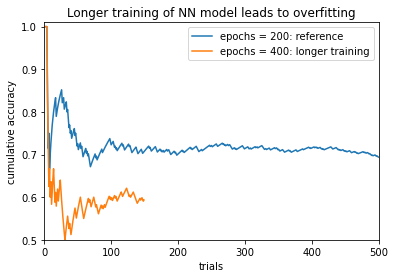

In [35]:
accuracy_cumulative_nn_50_d0_50_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.7894736842105263, 0.8, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8214285714285714, 0.8275862068965517, 0.8333333333333334, 0.8064516129032258, 0.8125, 0.8181818181818182, 0.8235294117647058, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7380952380952381, 0.7441860465116279, 0.75, 0.7555555555555555, 0.7608695652173914, 0.7446808510638298, 0.75, 0.7346938775510204, 0.72, 0.7254901960784313, 0.7115384615384616, 0.7169811320754716, 0.7222222222222222, 0.7272727272727273, 0.7142857142857143, 0.7192982456140351, 0.7068965517241379, 0.6949152542372882, 0.7, 0.7049180327868853, 0.7096774193548387, 0.7142857142857143, 0.703125, 0.7076923076923077, 0.696969696969697, 0.7014925373134329, 0.6911764705882353, 0.6811594202898551, 0.6714285714285714, 0.676056338028169, 0.6805555555555556, 0.684931506849315, 0.6891891891891891, 0.6933333333333334, 0.6973684210526315, 0.7012987012987013, 0.6923076923076923, 0.6962025316455697, 0.6875, 0.691358024691358, 0.6951219512195121, 0.6987951807228916, 0.7023809523809523, 0.7058823529411765, 0.7093023255813954, 0.7126436781609196, 0.7045454545454546, 0.7078651685393258, 0.7111111111111111, 0.7142857142857143, 0.717391304347826, 0.7204301075268817, 0.723404255319149, 0.7263157894736842, 0.7291666666666666, 0.7319587628865979, 0.7346938775510204, 0.7373737373737373, 0.73, 0.7227722772277227, 0.7254901960784313, 0.7281553398058253, 0.7307692307692307, 0.7238095238095238, 0.7169811320754716, 0.719626168224299, 0.7129629629629629, 0.7155963302752294, 0.7090909090909091, 0.7117117117117117, 0.7142857142857143, 0.7168141592920354, 0.7192982456140351, 0.7217391304347827, 0.7241379310344828, 0.7264957264957265, 0.7203389830508474, 0.7226890756302521, 0.7166666666666667, 0.7107438016528925, 0.7131147540983607, 0.7154471544715447, 0.717741935483871, 0.72, 0.7222222222222222, 0.7244094488188977, 0.71875, 0.7209302325581395, 0.7153846153846154, 0.7099236641221374, 0.7045454545454546, 0.706766917293233, 0.7089552238805971, 0.7111111111111111, 0.7132352941176471, 0.7153284671532847, 0.717391304347826, 0.7122302158273381, 0.7071428571428572, 0.7021276595744681, 0.704225352112676, 0.7062937062937062, 0.7083333333333334, 0.7103448275862069, 0.7123287671232876, 0.7074829931972789, 0.7027027027027027, 0.7046979865771812, 0.7066666666666667, 0.7086092715231788, 0.7105263157894737, 0.7124183006535948, 0.7142857142857143, 0.7161290322580646, 0.717948717948718, 0.7197452229299363, 0.7151898734177216, 0.7169811320754716, 0.7125, 0.7080745341614907, 0.7098765432098766, 0.7116564417177914, 0.7134146341463414, 0.7151515151515152, 0.7168674698795181, 0.718562874251497, 0.7142857142857143, 0.7100591715976331, 0.7058823529411765, 0.7076023391812866, 0.7093023255813954, 0.7109826589595376, 0.7126436781609196, 0.7085714285714285, 0.7102272727272727, 0.7062146892655368, 0.7078651685393258, 0.7094972067039106, 0.7055555555555556, 0.7071823204419889, 0.7087912087912088, 0.7103825136612022, 0.7119565217391305, 0.7081081081081081, 0.7096774193548387, 0.7112299465240641, 0.7074468085106383, 0.7037037037037037, 0.7, 0.7015706806282722, 0.703125, 0.7046632124352331, 0.7061855670103093, 0.7076923076923077, 0.7040816326530612, 0.7055837563451777, 0.702020202020202, 0.6984924623115578, 0.7, 0.7014925373134329, 0.7029702970297029, 0.7044334975369458, 0.7058823529411765, 0.7073170731707317, 0.7087378640776699, 0.7101449275362319, 0.7067307692307693, 0.7081339712918661, 0.7047619047619048, 0.7061611374407583, 0.7075471698113207, 0.7089201877934272, 0.7102803738317757, 0.7116279069767442, 0.7129629629629629, 0.7142857142857143, 0.7155963302752294, 0.7168949771689498, 0.7136363636363636, 0.7149321266968326, 0.7117117117117117, 0.7130044843049327, 0.7142857142857143, 0.7155555555555555, 0.7168141592920354, 0.7180616740088106, 0.7192982456140351, 0.7161572052401747, 0.7130434782608696, 0.70995670995671, 0.7068965517241379, 0.7081545064377682, 0.7094017094017094, 0.7106382978723405, 0.711864406779661, 0.7088607594936709, 0.7100840336134454, 0.7112970711297071, 0.7125, 0.7136929460580913, 0.7148760330578512, 0.7160493827160493, 0.7172131147540983, 0.7183673469387755, 0.7195121951219512, 0.7206477732793523, 0.7217741935483871, 0.7188755020080321, 0.72, 0.7211155378486056, 0.7182539682539683, 0.7193675889328063, 0.7204724409448819, 0.7215686274509804, 0.72265625, 0.7237354085603113, 0.7248062015503876, 0.722007722007722, 0.7192307692307692, 0.7203065134099617, 0.7213740458015268, 0.7224334600760456, 0.7234848484848485, 0.7245283018867924, 0.7255639097744361, 0.7265917602996255, 0.7238805970149254, 0.724907063197026, 0.7222222222222222, 0.7232472324723247, 0.7205882352941176, 0.7216117216117216, 0.7226277372262774, 0.7236363636363636, 0.7210144927536232, 0.7220216606498195, 0.7230215827338129, 0.7204301075268817, 0.7178571428571429, 0.7153024911032029, 0.7127659574468085, 0.7137809187279152, 0.7147887323943662, 0.7157894736842105, 0.7132867132867133, 0.7142857142857143, 0.7118055555555556, 0.71280276816609, 0.7137931034482758, 0.7147766323024055, 0.7157534246575342, 0.7167235494880546, 0.717687074829932, 0.7186440677966102, 0.7195945945945946, 0.7205387205387206, 0.7181208053691275, 0.7157190635451505, 0.7133333333333334, 0.7142857142857143, 0.7152317880794702, 0.7161716171617162, 0.7171052631578947, 0.7180327868852459, 0.7156862745098039, 0.7133550488599348, 0.7142857142857143, 0.7152103559870551, 0.7129032258064516, 0.7138263665594855, 0.7147435897435898, 0.7156549520766773, 0.7165605095541401, 0.7174603174603175, 0.7183544303797469, 0.7160883280757098, 0.7169811320754716, 0.7178683385579937, 0.715625, 0.7165109034267912, 0.717391304347826, 0.718266253869969, 0.7191358024691358, 0.72, 0.7208588957055214, 0.7186544342507645, 0.7164634146341463, 0.7142857142857143, 0.7121212121212122, 0.7129909365558912, 0.713855421686747, 0.7117117117117117, 0.7125748502994012, 0.7134328358208956, 0.7142857142857143, 0.7151335311572701, 0.7130177514792899, 0.7109144542772862, 0.711764705882353, 0.7126099706744868, 0.7134502923976608, 0.7142857142857143, 0.7151162790697675, 0.7159420289855073, 0.7138728323699421, 0.7146974063400576, 0.7155172413793104, 0.7134670487106017, 0.7114285714285714, 0.7122507122507122, 0.7102272727272727, 0.7082152974504249, 0.7090395480225988, 0.7098591549295775, 0.7106741573033708, 0.711484593837535, 0.7094972067039106, 0.7075208913649025, 0.7055555555555556, 0.7063711911357341, 0.7071823204419889, 0.7079889807162535, 0.7087912087912088, 0.7095890410958904, 0.7103825136612022, 0.7084468664850136, 0.7092391304347826, 0.7073170731707317, 0.7054054054054054, 0.706199460916442, 0.706989247311828, 0.707774798927614, 0.7085561497326203, 0.7093333333333334, 0.7101063829787234, 0.7108753315649867, 0.708994708994709, 0.7071240105540897, 0.7078947368421052, 0.7086614173228346, 0.7094240837696335, 0.7101827676240209, 0.7109375, 0.7116883116883117, 0.7124352331606217, 0.7131782945736435, 0.711340206185567, 0.712082262210797, 0.7128205128205128, 0.7135549872122762, 0.7142857142857143, 0.7150127226463104, 0.7157360406091371, 0.7164556962025317, 0.7171717171717171, 0.7153652392947103, 0.7160804020100503, 0.7142857142857143, 0.715, 0.71571072319202, 0.7164179104477612, 0.71712158808933, 0.7178217821782178, 0.7160493827160493, 0.7167487684729064, 0.7174447174447175, 0.7156862745098039, 0.7163814180929096, 0.7146341463414634, 0.7153284671532847, 0.7160194174757282, 0.7167070217917676, 0.714975845410628, 0.7132530120481928, 0.7139423076923077, 0.7122302158273381, 0.7129186602870813, 0.711217183770883, 0.7119047619047619, 0.7125890736342043, 0.7132701421800948, 0.7139479905437353, 0.714622641509434, 0.7152941176470589, 0.715962441314554, 0.7166276346604216, 0.7172897196261683, 0.717948717948718, 0.7162790697674418, 0.7146171693735499, 0.7129629629629629, 0.7136258660508084, 0.7142857142857143, 0.7149425287356321, 0.7155963302752294, 0.7162471395881007, 0.7146118721461188, 0.7129840546697038, 0.7113636363636363, 0.7120181405895691, 0.7104072398190046, 0.7110609480812641, 0.7094594594594594, 0.7101123595505618, 0.7107623318385651, 0.7114093959731543, 0.7098214285714286, 0.7082405345211581, 0.7088888888888889, 0.7073170731707317, 0.7079646017699115, 0.7064017660044151, 0.7070484581497798, 0.7076923076923077, 0.7083333333333334, 0.7089715536105032, 0.7074235807860262, 0.7058823529411765, 0.7043478260869566, 0.7049891540130152, 0.7056277056277056, 0.7062634989200864, 0.7068965517241379, 0.7053763440860215, 0.7060085836909872, 0.7044967880085653, 0.7029914529914529, 0.7036247334754797, 0.7021276595744681, 0.70276008492569, 0.7033898305084746, 0.7040169133192389, 0.7046413502109705, 0.7052631578947368, 0.7058823529411765, 0.7064989517819706, 0.7050209205020921, 0.7056367432150313, 0.7041666666666667, 0.7047817047817048, 0.7033195020746889, 0.7039337474120083, 0.7045454545454546, 0.7030927835051546, 0.7016460905349794, 0.702258726899384, 0.7008196721311475, 0.6993865030674846, 0.6979591836734694, 0.6985743380855397, 0.6971544715447154, 0.6977687626774848, 0.6983805668016194, 0.6989898989898989, 0.6975806451612904, 0.6961770623742455, 0.6967871485943775, 0.6953907815631263, 0.694]
accuracy_cumulative_nn_50_d0_50_ml0_e400 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.625, 0.6666666666666666, 0.6, 0.6363636363636364, 0.5833333333333334, 0.6153846153846154, 0.6428571428571429, 0.6666666666666666, 0.625, 0.5882352941176471, 0.6111111111111112, 0.5789473684210527, 0.6, 0.6190476190476191, 0.5909090909090909, 0.6086956521739131, 0.625, 0.64, 0.6153846153846154, 0.5925925925925926, 0.5714285714285714, 0.5517241379310345, 0.5333333333333333, 0.5161290322580645, 0.5, 0.5151515151515151, 0.5294117647058824, 0.5428571428571428, 0.5555555555555556, 0.5405405405405406, 0.5263157894736842, 0.5384615384615384, 0.525, 0.5121951219512195, 0.5238095238095238, 0.5348837209302325, 0.5454545454545454, 0.5555555555555556, 0.5652173913043478, 0.574468085106383, 0.5625, 0.5510204081632653, 0.56, 0.5686274509803921, 0.5769230769230769, 0.5849056603773585, 0.5925925925925926, 0.6, 0.5892857142857143, 0.5789473684210527, 0.5689655172413793, 0.559322033898305, 0.55, 0.5573770491803278, 0.5645161290322581, 0.5714285714285714, 0.578125, 0.5846153846153846, 0.5909090909090909, 0.5970149253731343, 0.5882352941176471, 0.5942028985507246, 0.5857142857142857, 0.5774647887323944, 0.5833333333333334, 0.589041095890411, 0.5945945945945946, 0.6, 0.5921052631578947, 0.5844155844155844, 0.5769230769230769, 0.5822784810126582, 0.575, 0.5679012345679012, 0.5609756097560976, 0.5662650602409639, 0.5714285714285714, 0.5764705882352941, 0.5813953488372093, 0.5747126436781609, 0.5795454545454546, 0.5730337078651685, 0.5777777777777777, 0.5824175824175825, 0.5760869565217391, 0.5806451612903226, 0.5851063829787234, 0.5894736842105263, 0.59375, 0.5979381443298969, 0.6020408163265306, 0.5959595959595959, 0.6, 0.594059405940594, 0.5980392156862745, 0.5922330097087378, 0.5961538461538461, 0.6, 0.6037735849056604, 0.5981308411214953, 0.6018518518518519, 0.5963302752293578, 0.5909090909090909, 0.5945945945945946, 0.5982142857142857, 0.6017699115044248, 0.6052631578947368, 0.6086956521739131, 0.6120689655172413, 0.6068376068376068, 0.6016949152542372, 0.6050420168067226, 0.6083333333333333, 0.6115702479338843, 0.6147540983606558, 0.6178861788617886, 0.6209677419354839, 0.616, 0.6111111111111112, 0.6062992125984252, 0.6015625, 0.6046511627906976, 0.6, 0.6030534351145038, 0.6060606060606061, 0.6090225563909775, 0.6119402985074627, 0.6074074074074074, 0.6029411764705882, 0.5985401459854015, 0.5942028985507246, 0.5899280575539568, 0.5857142857142857, 0.5886524822695035, 0.5915492957746479, 0.5944055944055944, 0.5972222222222222, 0.593103448275862, 0.5958904109589042, 0.5986394557823129, 0.5945945945945946, 0.5906040268456376, 0.5933333333333334]
plt.plot(accuracy_cumulative_nn_50_d0_50_ml0_e200)
plt.plot(accuracy_cumulative_nn_50_d0_50_ml0_e400)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_nn_50_d0_50_ml0_e200))
plt.ylabel('cumulative accuracy')
plt.ylim(0.5,1.01)
plt.legend(['epochs = 200: reference', 'epochs = 400: longer training'])
plt.title('Longer training of NN model leads to overfitting');

We observe overfitting: the accuracy for 400 training epochs (0.593333 after 150 trials) is significantly lower than for 200 epochs (0.694 after 500 trials).

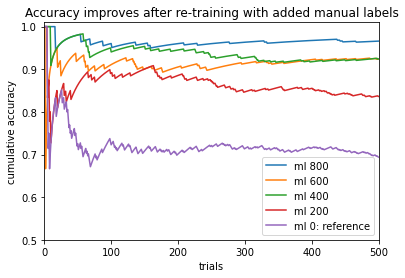

In [1135]:
accuracy_cumulative_nn_50_d0_50_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.7894736842105263, 0.8, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8214285714285714, 0.8275862068965517, 0.8333333333333334, 0.8064516129032258, 0.8125, 0.8181818181818182, 0.8235294117647058, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7380952380952381, 0.7441860465116279, 0.75, 0.7555555555555555, 0.7608695652173914, 0.7446808510638298, 0.75, 0.7346938775510204, 0.72, 0.7254901960784313, 0.7115384615384616, 0.7169811320754716, 0.7222222222222222, 0.7272727272727273, 0.7142857142857143, 0.7192982456140351, 0.7068965517241379, 0.6949152542372882, 0.7, 0.7049180327868853, 0.7096774193548387, 0.7142857142857143, 0.703125, 0.7076923076923077, 0.696969696969697, 0.7014925373134329, 0.6911764705882353, 0.6811594202898551, 0.6714285714285714, 0.676056338028169, 0.6805555555555556, 0.684931506849315, 0.6891891891891891, 0.6933333333333334, 0.6973684210526315, 0.7012987012987013, 0.6923076923076923, 0.6962025316455697, 0.6875, 0.691358024691358, 0.6951219512195121, 0.6987951807228916, 0.7023809523809523, 0.7058823529411765, 0.7093023255813954, 0.7126436781609196, 0.7045454545454546, 0.7078651685393258, 0.7111111111111111, 0.7142857142857143, 0.717391304347826, 0.7204301075268817, 0.723404255319149, 0.7263157894736842, 0.7291666666666666, 0.7319587628865979, 0.7346938775510204, 0.7373737373737373, 0.73, 0.7227722772277227, 0.7254901960784313, 0.7281553398058253, 0.7307692307692307, 0.7238095238095238, 0.7169811320754716, 0.719626168224299, 0.7129629629629629, 0.7155963302752294, 0.7090909090909091, 0.7117117117117117, 0.7142857142857143, 0.7168141592920354, 0.7192982456140351, 0.7217391304347827, 0.7241379310344828, 0.7264957264957265, 0.7203389830508474, 0.7226890756302521, 0.7166666666666667, 0.7107438016528925, 0.7131147540983607, 0.7154471544715447, 0.717741935483871, 0.72, 0.7222222222222222, 0.7244094488188977, 0.71875, 0.7209302325581395, 0.7153846153846154, 0.7099236641221374, 0.7045454545454546, 0.706766917293233, 0.7089552238805971, 0.7111111111111111, 0.7132352941176471, 0.7153284671532847, 0.717391304347826, 0.7122302158273381, 0.7071428571428572, 0.7021276595744681, 0.704225352112676, 0.7062937062937062, 0.7083333333333334, 0.7103448275862069, 0.7123287671232876, 0.7074829931972789, 0.7027027027027027, 0.7046979865771812, 0.7066666666666667, 0.7086092715231788, 0.7105263157894737, 0.7124183006535948, 0.7142857142857143, 0.7161290322580646, 0.717948717948718, 0.7197452229299363, 0.7151898734177216, 0.7169811320754716, 0.7125, 0.7080745341614907, 0.7098765432098766, 0.7116564417177914, 0.7134146341463414, 0.7151515151515152, 0.7168674698795181, 0.718562874251497, 0.7142857142857143, 0.7100591715976331, 0.7058823529411765, 0.7076023391812866, 0.7093023255813954, 0.7109826589595376, 0.7126436781609196, 0.7085714285714285, 0.7102272727272727, 0.7062146892655368, 0.7078651685393258, 0.7094972067039106, 0.7055555555555556, 0.7071823204419889, 0.7087912087912088, 0.7103825136612022, 0.7119565217391305, 0.7081081081081081, 0.7096774193548387, 0.7112299465240641, 0.7074468085106383, 0.7037037037037037, 0.7, 0.7015706806282722, 0.703125, 0.7046632124352331, 0.7061855670103093, 0.7076923076923077, 0.7040816326530612, 0.7055837563451777, 0.702020202020202, 0.6984924623115578, 0.7, 0.7014925373134329, 0.7029702970297029, 0.7044334975369458, 0.7058823529411765, 0.7073170731707317, 0.7087378640776699, 0.7101449275362319, 0.7067307692307693, 0.7081339712918661, 0.7047619047619048, 0.7061611374407583, 0.7075471698113207, 0.7089201877934272, 0.7102803738317757, 0.7116279069767442, 0.7129629629629629, 0.7142857142857143, 0.7155963302752294, 0.7168949771689498, 0.7136363636363636, 0.7149321266968326, 0.7117117117117117, 0.7130044843049327, 0.7142857142857143, 0.7155555555555555, 0.7168141592920354, 0.7180616740088106, 0.7192982456140351, 0.7161572052401747, 0.7130434782608696, 0.70995670995671, 0.7068965517241379, 0.7081545064377682, 0.7094017094017094, 0.7106382978723405, 0.711864406779661, 0.7088607594936709, 0.7100840336134454, 0.7112970711297071, 0.7125, 0.7136929460580913, 0.7148760330578512, 0.7160493827160493, 0.7172131147540983, 0.7183673469387755, 0.7195121951219512, 0.7206477732793523, 0.7217741935483871, 0.7188755020080321, 0.72, 0.7211155378486056, 0.7182539682539683, 0.7193675889328063, 0.7204724409448819, 0.7215686274509804, 0.72265625, 0.7237354085603113, 0.7248062015503876, 0.722007722007722, 0.7192307692307692, 0.7203065134099617, 0.7213740458015268, 0.7224334600760456, 0.7234848484848485, 0.7245283018867924, 0.7255639097744361, 0.7265917602996255, 0.7238805970149254, 0.724907063197026, 0.7222222222222222, 0.7232472324723247, 0.7205882352941176, 0.7216117216117216, 0.7226277372262774, 0.7236363636363636, 0.7210144927536232, 0.7220216606498195, 0.7230215827338129, 0.7204301075268817, 0.7178571428571429, 0.7153024911032029, 0.7127659574468085, 0.7137809187279152, 0.7147887323943662, 0.7157894736842105, 0.7132867132867133, 0.7142857142857143, 0.7118055555555556, 0.71280276816609, 0.7137931034482758, 0.7147766323024055, 0.7157534246575342, 0.7167235494880546, 0.717687074829932, 0.7186440677966102, 0.7195945945945946, 0.7205387205387206, 0.7181208053691275, 0.7157190635451505, 0.7133333333333334, 0.7142857142857143, 0.7152317880794702, 0.7161716171617162, 0.7171052631578947, 0.7180327868852459, 0.7156862745098039, 0.7133550488599348, 0.7142857142857143, 0.7152103559870551, 0.7129032258064516, 0.7138263665594855, 0.7147435897435898, 0.7156549520766773, 0.7165605095541401, 0.7174603174603175, 0.7183544303797469, 0.7160883280757098, 0.7169811320754716, 0.7178683385579937, 0.715625, 0.7165109034267912, 0.717391304347826, 0.718266253869969, 0.7191358024691358, 0.72, 0.7208588957055214, 0.7186544342507645, 0.7164634146341463, 0.7142857142857143, 0.7121212121212122, 0.7129909365558912, 0.713855421686747, 0.7117117117117117, 0.7125748502994012, 0.7134328358208956, 0.7142857142857143, 0.7151335311572701, 0.7130177514792899, 0.7109144542772862, 0.711764705882353, 0.7126099706744868, 0.7134502923976608, 0.7142857142857143, 0.7151162790697675, 0.7159420289855073, 0.7138728323699421, 0.7146974063400576, 0.7155172413793104, 0.7134670487106017, 0.7114285714285714, 0.7122507122507122, 0.7102272727272727, 0.7082152974504249, 0.7090395480225988, 0.7098591549295775, 0.7106741573033708, 0.711484593837535, 0.7094972067039106, 0.7075208913649025, 0.7055555555555556, 0.7063711911357341, 0.7071823204419889, 0.7079889807162535, 0.7087912087912088, 0.7095890410958904, 0.7103825136612022, 0.7084468664850136, 0.7092391304347826, 0.7073170731707317, 0.7054054054054054, 0.706199460916442, 0.706989247311828, 0.707774798927614, 0.7085561497326203, 0.7093333333333334, 0.7101063829787234, 0.7108753315649867, 0.708994708994709, 0.7071240105540897, 0.7078947368421052, 0.7086614173228346, 0.7094240837696335, 0.7101827676240209, 0.7109375, 0.7116883116883117, 0.7124352331606217, 0.7131782945736435, 0.711340206185567, 0.712082262210797, 0.7128205128205128, 0.7135549872122762, 0.7142857142857143, 0.7150127226463104, 0.7157360406091371, 0.7164556962025317, 0.7171717171717171, 0.7153652392947103, 0.7160804020100503, 0.7142857142857143, 0.715, 0.71571072319202, 0.7164179104477612, 0.71712158808933, 0.7178217821782178, 0.7160493827160493, 0.7167487684729064, 0.7174447174447175, 0.7156862745098039, 0.7163814180929096, 0.7146341463414634, 0.7153284671532847, 0.7160194174757282, 0.7167070217917676, 0.714975845410628, 0.7132530120481928, 0.7139423076923077, 0.7122302158273381, 0.7129186602870813, 0.711217183770883, 0.7119047619047619, 0.7125890736342043, 0.7132701421800948, 0.7139479905437353, 0.714622641509434, 0.7152941176470589, 0.715962441314554, 0.7166276346604216, 0.7172897196261683, 0.717948717948718, 0.7162790697674418, 0.7146171693735499, 0.7129629629629629, 0.7136258660508084, 0.7142857142857143, 0.7149425287356321, 0.7155963302752294, 0.7162471395881007, 0.7146118721461188, 0.7129840546697038, 0.7113636363636363, 0.7120181405895691, 0.7104072398190046, 0.7110609480812641, 0.7094594594594594, 0.7101123595505618, 0.7107623318385651, 0.7114093959731543, 0.7098214285714286, 0.7082405345211581, 0.7088888888888889, 0.7073170731707317, 0.7079646017699115, 0.7064017660044151, 0.7070484581497798, 0.7076923076923077, 0.7083333333333334, 0.7089715536105032, 0.7074235807860262, 0.7058823529411765, 0.7043478260869566, 0.7049891540130152, 0.7056277056277056, 0.7062634989200864, 0.7068965517241379, 0.7053763440860215, 0.7060085836909872, 0.7044967880085653, 0.7029914529914529, 0.7036247334754797, 0.7021276595744681, 0.70276008492569, 0.7033898305084746, 0.7040169133192389, 0.7046413502109705, 0.7052631578947368, 0.7058823529411765, 0.7064989517819706, 0.7050209205020921, 0.7056367432150313, 0.7041666666666667, 0.7047817047817048, 0.7033195020746889, 0.7039337474120083, 0.7045454545454546, 0.7030927835051546, 0.7016460905349794, 0.702258726899384, 0.7008196721311475, 0.6993865030674846, 0.6979591836734694, 0.6985743380855397, 0.6971544715447154, 0.6977687626774848, 0.6983805668016194, 0.6989898989898989, 0.6975806451612904, 0.6961770623742455, 0.6967871485943775, 0.6953907815631263, 0.694]
accuracy_cumulative_nn_50_50_ml200_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.875, 0.7777777777777778, 0.8, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8095238095238095, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8571428571428571, 0.8620689655172413, 0.8666666666666667, 0.8387096774193549, 0.84375, 0.8484848484848485, 0.8235294117647058, 0.8285714285714286, 0.8333333333333334, 0.8378378378378378, 0.8421052631578947, 0.8461538461538461, 0.85, 0.8292682926829268, 0.8333333333333334, 0.8372093023255814, 0.8409090909090909, 0.8444444444444444, 0.8478260869565217, 0.851063829787234, 0.8541666666666666, 0.8571428571428571, 0.86, 0.8627450980392157, 0.8653846153846154, 0.8679245283018868, 0.8703703703703703, 0.8727272727272727, 0.875, 0.8771929824561403, 0.8793103448275862, 0.8813559322033898, 0.8833333333333333, 0.8852459016393442, 0.8870967741935484, 0.8888888888888888, 0.890625, 0.8923076923076924, 0.8939393939393939, 0.8805970149253731, 0.8823529411764706, 0.8840579710144928, 0.8857142857142857, 0.8873239436619719, 0.875, 0.8767123287671232, 0.8783783783783784, 0.88, 0.881578947368421, 0.8701298701298701, 0.8717948717948718, 0.8734177215189873, 0.875, 0.8765432098765432, 0.8780487804878049, 0.8795180722891566, 0.8809523809523809, 0.8823529411764706, 0.8837209302325582, 0.8850574712643678, 0.8863636363636364, 0.8876404494382022, 0.8888888888888888, 0.8901098901098901, 0.8913043478260869, 0.8924731182795699, 0.8936170212765957, 0.8947368421052632, 0.8958333333333334, 0.8969072164948454, 0.8979591836734694, 0.898989898989899, 0.89, 0.8910891089108911, 0.8921568627450981, 0.883495145631068, 0.8846153846153846, 0.8857142857142857, 0.8867924528301887, 0.8785046728971962, 0.8796296296296297, 0.8807339449541285, 0.8818181818181818, 0.8828828828828829, 0.8839285714285714, 0.8849557522123894, 0.8859649122807017, 0.8869565217391304, 0.8879310344827587, 0.8888888888888888, 0.8813559322033898, 0.8823529411764706, 0.8833333333333333, 0.8842975206611571, 0.8852459016393442, 0.8861788617886179, 0.8870967741935484, 0.888, 0.8888888888888888, 0.889763779527559, 0.890625, 0.8914728682170543, 0.8846153846153846, 0.8854961832061069, 0.8863636363636364, 0.8872180451127819, 0.8880597014925373, 0.8888888888888888, 0.8897058823529411, 0.8905109489051095, 0.8913043478260869, 0.8920863309352518, 0.8928571428571429, 0.8936170212765957, 0.8943661971830986, 0.8951048951048951, 0.8958333333333334, 0.896551724137931, 0.8972602739726028, 0.8979591836734694, 0.8986486486486487, 0.8993288590604027, 0.9, 0.9006622516556292, 0.9013157894736842, 0.9019607843137256, 0.9025974025974026, 0.9032258064516128, 0.903846153846154, 0.9044585987261148, 0.9050632911392406, 0.9056603773584906, 0.90625, 0.906832298136646, 0.9074074074074074, 0.9079754601226994, 0.9085365853658536, 0.9030303030303032, 0.8975903614457831, 0.8922155688622755, 0.8928571428571429, 0.893491124260355, 0.888235294117647, 0.8830409356725146, 0.8837209302325582, 0.884393063583815, 0.8793103448275862, 0.88, 0.8806818181818182, 0.8757062146892656, 0.8764044943820225, 0.8770949720670391, 0.8777777777777778, 0.8784530386740331, 0.8791208791208791, 0.8797814207650273, 0.8804347826086957, 0.8810810810810811, 0.8817204301075269, 0.8823529411764706, 0.8829787234042553, 0.8835978835978836, 0.8842105263157894, 0.8795811518324608, 0.8802083333333334, 0.8808290155440415, 0.8814432989690721, 0.882051282051282, 0.8826530612244898, 0.883248730964467, 0.8838383838383839, 0.8844221105527639, 0.885, 0.8855721393034826, 0.8861386138613861, 0.8866995073891626, 0.8872549019607843, 0.8878048780487805, 0.8883495145631068, 0.8888888888888888, 0.8846153846153846, 0.8851674641148325, 0.8809523809523809, 0.8767772511848341, 0.8773584905660378, 0.8779342723004695, 0.8738317757009346, 0.8744186046511628, 0.875, 0.8755760368663594, 0.8761467889908257, 0.8767123287671232, 0.8772727272727273, 0.8778280542986425, 0.8783783783783784, 0.8789237668161435, 0.8794642857142857, 0.88, 0.8805309734513275, 0.8810572687224669, 0.881578947368421, 0.8777292576419214, 0.8739130434782608, 0.8744588744588745, 0.875, 0.8755364806866953, 0.8760683760683761, 0.8765957446808511, 0.8771186440677966, 0.8776371308016878, 0.8781512605042017, 0.8744769874476988, 0.875, 0.8755186721991701, 0.8760330578512396, 0.8765432098765432, 0.8770491803278688, 0.8775510204081632, 0.8739837398373984, 0.8744939271255061, 0.875, 0.8755020080321285, 0.872, 0.8725099601593626, 0.8690476190476191, 0.8695652173913043, 0.8661417322834646, 0.8666666666666667, 0.8671875, 0.8638132295719845, 0.8604651162790697, 0.861003861003861, 0.8576923076923076, 0.8582375478927203, 0.8587786259541985, 0.8593155893536122, 0.8598484848484849, 0.8603773584905661, 0.8609022556390977, 0.8614232209737828, 0.8619402985074627, 0.862453531598513, 0.8629629629629629, 0.8597785977859779, 0.8566176470588235, 0.8571428571428571, 0.8576642335766423, 0.8581818181818182, 0.8586956521739131, 0.8592057761732852, 0.8597122302158273, 0.8566308243727598, 0.8535714285714285, 0.8540925266903915, 0.8546099290780141, 0.8551236749116607, 0.852112676056338, 0.8526315789473684, 0.8531468531468531, 0.8501742160278746, 0.8472222222222222, 0.8477508650519031, 0.8482758620689655, 0.8487972508591065, 0.8493150684931506, 0.8498293515358362, 0.8503401360544217, 0.8508474576271187, 0.8513513513513513, 0.8518518518518519, 0.8489932885906041, 0.8461538461538461, 0.8466666666666667, 0.8471760797342193, 0.847682119205298, 0.8481848184818482, 0.8486842105263158, 0.8491803278688524, 0.8496732026143791, 0.8501628664495114, 0.8506493506493507, 0.8511326860841424, 0.8516129032258064, 0.8520900321543409, 0.8493589743589743, 0.8498402555910544, 0.8503184713375797, 0.8507936507936508, 0.8481012658227848, 0.8485804416403786, 0.8490566037735849, 0.8495297805642633, 0.85, 0.8504672897196262, 0.8509316770186336, 0.8513931888544891, 0.8518518518518519, 0.8523076923076923, 0.852760736196319, 0.8532110091743119, 0.8536585365853658, 0.8541033434650456, 0.8545454545454545, 0.8549848942598187, 0.8524096385542169, 0.8528528528528528, 0.8532934131736527, 0.8537313432835821, 0.8511904761904762, 0.8516320474777448, 0.8520710059171598, 0.8525073746312685, 0.8529411764705882, 0.8533724340175953, 0.8538011695906432, 0.8542274052478134, 0.8546511627906976, 0.855072463768116, 0.8554913294797688, 0.8559077809798271, 0.8563218390804598, 0.8567335243553008, 0.8571428571428571, 0.8575498575498576, 0.8579545454545454, 0.8583569405099151, 0.8587570621468926, 0.8591549295774648, 0.8567415730337079, 0.8543417366946778, 0.8519553072625698, 0.8523676880222841, 0.85, 0.850415512465374, 0.850828729281768, 0.8512396694214877, 0.8516483516483516, 0.852054794520548, 0.8524590163934426, 0.8528610354223434, 0.8532608695652174, 0.8536585365853658, 0.8540540540540541, 0.8544474393530997, 0.8548387096774194, 0.8552278820375335, 0.8556149732620321, 0.856, 0.8563829787234043, 0.8567639257294429, 0.8571428571428571, 0.8575197889182058, 0.8552631578947368, 0.8556430446194225, 0.856020942408377, 0.856396866840731, 0.8567708333333334, 0.8571428571428571, 0.8549222797927462, 0.8527131782945736, 0.8530927835051546, 0.8534704370179949, 0.8538461538461538, 0.8542199488491049, 0.8545918367346939, 0.8549618320610687, 0.8553299492385786, 0.8556962025316456, 0.8535353535353535, 0.853904282115869, 0.8542713567839196, 0.8546365914786967, 0.855, 0.8553615960099751, 0.8532338308457711, 0.8535980148883374, 0.8514851485148515, 0.8518518518518519, 0.8497536945812808, 0.8501228501228502, 0.8504901960784313, 0.8508557457212714, 0.8512195121951219, 0.851581508515815, 0.8495145631067961, 0.8498789346246973, 0.8502415458937198, 0.8481927710843373, 0.8485576923076923, 0.8489208633093526, 0.8492822966507177, 0.8496420047732697, 0.8476190476190476, 0.8479809976247031, 0.8483412322274881, 0.8463356973995272, 0.8443396226415094, 0.8447058823529412, 0.8450704225352113, 0.8430913348946136, 0.8434579439252337, 0.8414918414918415, 0.8418604651162791, 0.839907192575406, 0.8402777777777778, 0.8406466512702079, 0.8410138248847926, 0.8390804597701149, 0.8394495412844036, 0.8398169336384439, 0.8401826484018264, 0.8405466970387244, 0.8409090909090909, 0.8412698412698413, 0.8416289592760181, 0.8419864559819413, 0.8423423423423423, 0.8426966292134831, 0.8430493273542601, 0.843400447427293, 0.84375, 0.844097995545657, 0.8422222222222222, 0.8425720620842572, 0.8429203539823009, 0.8432671081677704, 0.8436123348017621, 0.8417582417582418, 0.8421052631578947, 0.8424507658643327, 0.8406113537117904, 0.840958605664488, 0.8391304347826087, 0.8394793926247288, 0.8376623376623377, 0.838012958963283, 0.8383620689655172, 0.8387096774193549, 0.8390557939914163, 0.8394004282655246, 0.8397435897435898, 0.8400852878464818, 0.8404255319148937, 0.8407643312101911, 0.8411016949152542, 0.8414376321353065, 0.8417721518987342, 0.8421052631578947, 0.8403361344537815, 0.8385744234800838, 0.8389121338912134, 0.8392484342379958, 0.8375, 0.8357588357588358, 0.8360995850622407, 0.8364389233954451, 0.8367768595041323, 0.8371134020618557, 0.8374485596707819, 0.837782340862423, 0.8360655737704918, 0.83640081799591, 0.8346938775510204, 0.835030549898167, 0.8353658536585366, 0.8356997971602435, 0.8360323886639676, 0.8363636363636363, 0.8366935483870968, 0.8370221327967807, 0.8373493975903614, 0.8376753507014028, 0.836, 0.8363273453093812, 0.8366533864541833, 0.8369781312127237, 0.8373015873015873, 0.8356435643564356, 0.8359683794466403, 0.8362919132149902, 0.8366141732283464, 0.8349705304518664, 0.8352941176470589, 0.8356164383561644, 0.8359375, 0.8362573099415205, 0.8346303501945526, 0.8349514563106796, 0.8352713178294574, 0.8355899419729207, 0.8359073359073359, 0.8362235067437379, 0.8365384615384616, 0.836852207293666, 0.8371647509578544, 0.8374760994263862, 0.8377862595419847, 0.8380952380952381, 0.8384030418250951, 0.8387096774193549, 0.8390151515151515, 0.8393194706994329, 0.8377358490566038, 0.8380414312617702, 0.8383458646616542, 0.8386491557223265, 0.8389513108614233, 0.8392523364485981, 0.8395522388059702, 0.839851024208566, 0.8401486988847584, 0.8404452690166976, 0.8407407407407408, 0.8410351201478743, 0.8413284132841329, 0.8416206261510129, 0.8419117647058824, 0.8403669724770643, 0.8406593406593407, 0.8409506398537477, 0.8412408759124088, 0.8397085610200364, 0.84, 0.8402903811252269, 0.8405797101449275, 0.840867992766727, 0.8411552346570397, 0.8414414414414414, 0.841726618705036, 0.8420107719928187, 0.8422939068100358, 0.8425760286225402, 0.8428571428571429, 0.8431372549019608, 0.8434163701067615, 0.8436944937833037, 0.8439716312056738, 0.8442477876106195, 0.8445229681978799, 0.8447971781305115, 0.8450704225352113, 0.8453427065026362, 0.8456140350877193, 0.8441330998248686, 0.8426573426573427, 0.8429319371727748, 0.8432055749128919, 0.8434782608695652, 0.8420138888888888, 0.8422876949740035, 0.842560553633218, 0.842832469775475, 0.843103448275862, 0.8433734939759037, 0.8436426116838488, 0.8439108061749572, 0.8441780821917808, 0.8444444444444444, 0.8447098976109215, 0.8449744463373083, 0.8452380952380952, 0.8455008488964346, 0.8440677966101695, 0.8443316412859561, 0.8445945945945946, 0.8448566610455311, 0.8451178451178452, 0.8453781512605042, 0.8439597315436241, 0.8442211055276382, 0.842809364548495, 0.8430717863105175, 0.8433333333333334, 0.8435940099833611, 0.8438538205980066, 0.8441127694859039, 0.8443708609271523, 0.8446280991735537, 0.8448844884488449, 0.8451400329489291, 0.8453947368421053, 0.8456486042692939, 0.8459016393442623, 0.8461538461538461, 0.8464052287581699, 0.8466557911908646, 0.8469055374592834, 0.8471544715447155, 0.8457792207792207, 0.8460291734197731, 0.8462783171521036, 0.8465266558966075, 0.8467741935483871, 0.8470209339774557, 0.8472668810289389, 0.8475120385232745, 0.8477564102564102, 0.848, 0.8466453674121406, 0.8452950558213717, 0.8455414012738853, 0.8457869634340223, 0.846031746031746, 0.8462757527733756, 0.8465189873417721, 0.8467614533965245, 0.8470031545741324, 0.8472440944881889, 0.8474842767295597, 0.8461538461538461, 0.8463949843260188, 0.8466353677621283, 0.846875, 0.8455538221528861, 0.8457943925233645, 0.8460342146189735, 0.8462732919254659, 0.8465116279069768, 0.846749226006192, 0.8469860896445132, 0.8472222222222222, 0.847457627118644, 0.8476923076923077, 0.847926267281106, 0.848159509202454, 0.8468606431852986, 0.845565749235474, 0.8458015267175573, 0.8460365853658537, 0.8462709284627092, 0.8449848024316109, 0.8452200303490136, 0.8454545454545455, 0.8441754916792739, 0.8444108761329305, 0.8446455505279035, 0.8448795180722891, 0.8451127819548873, 0.8453453453453453, 0.8455772113943029, 0.8458083832335329, 0.8460388639760837, 0.8462686567164179, 0.8464977645305514, 0.8467261904761905, 0.8469539375928677, 0.8471810089020771, 0.8474074074074074, 0.8461538461538461, 0.844903988183161, 0.8451327433628318, 0.8438880706921944, 0.8441176470588235, 0.8443465491923642, 0.844574780058651, 0.8448023426061494, 0.8450292397660819, 0.8437956204379562, 0.8440233236151603, 0.8442503639010189, 0.8444767441860465, 0.8432510885341074, 0.8434782608695652, 0.8422575976845152, 0.8424855491329479, 0.8427128427128427, 0.8414985590778098, 0.841726618705036, 0.8419540229885057, 0.8421807747489239, 0.8424068767908309, 0.8426323319027181, 0.8428571428571429, 0.8430813124108416, 0.8433048433048433, 0.8421052631578947, 0.8423295454545454, 0.8425531914893617, 0.8427762039660056, 0.8415841584158416, 0.8418079096045198, 0.842031029619182, 0.8422535211267606, 0.8424753867791842, 0.8426966292134831, 0.8429172510518934, 0.8417366946778712, 0.8419580419580419, 0.8421787709497207, 0.8423988842398884, 0.8426183844011143, 0.8428372739916551, 0.8430555555555556, 0.8432732316227461, 0.8434903047091413, 0.8437067773167358, 0.8439226519337016, 0.8441379310344828, 0.8443526170798898, 0.8431911966987621, 0.8434065934065934, 0.8436213991769548, 0.8438356164383561, 0.8440492476060192, 0.8442622950819673, 0.844474761255116, 0.8446866485013624, 0.8448979591836735, 0.84375, 0.8426051560379919, 0.8414634146341463, 0.8403247631935047, 0.8405405405405405, 0.8394062078272605, 0.839622641509434, 0.8398384925975774, 0.8387096774193549, 0.8389261744966443, 0.839142091152815, 0.8393574297188755, 0.839572192513369, 0.8397863818424566, 0.84, 0.8402130492676432, 0.8404255319148937, 0.8406374501992032, 0.8408488063660478, 0.8410596026490066, 0.83994708994709, 0.8401585204755614, 0.8390501319261213, 0.839262187088274, 0.8394736842105263, 0.8396846254927727, 0.8398950131233596, 0.8401048492791612, 0.8403141361256544, 0.8405228758169935, 0.8407310704960835, 0.8409387222946545, 0.8411458333333334, 0.8413524057217165, 0.8415584415584415, 0.8417639429312581, 0.8419689119170984, 0.8421733505821475, 0.8423772609819121, 0.8425806451612903, 0.8427835051546392, 0.842985842985843, 0.8431876606683805, 0.8433889602053916, 0.8435897435897436, 0.8437900128040973, 0.8439897698209718, 0.8441890166028098, 0.8443877551020408, 0.8445859872611465, 0.8447837150127226, 0.8449809402795425, 0.8451776649746193, 0.844106463878327, 0.8443037974683544, 0.8445006321112516, 0.8446969696969697, 0.8448928121059268, 0.845088161209068, 0.8452830188679246, 0.8442211055276382, 0.8444165621079046, 0.8446115288220551, 0.8448060075093867, 0.845, 0.8451935081148564, 0.8453865336658354, 0.8455790784557908, 0.845771144278607, 0.8459627329192546, 0.8461538461538461, 0.8463444857496902, 0.8465346534653465, 0.8467243510506799, 0.8469135802469135, 0.8471023427866831, 0.8472906403940886, 0.8474784747847478, 0.8476658476658476, 0.8478527607361963, 0.8468137254901961, 0.847001223990208, 0.8471882640586798, 0.8473748473748474, 0.8475609756097561, 0.8477466504263094, 0.8467153284671532, 0.8469015795868773, 0.8470873786407767, 0.8472727272727273, 0.847457627118644, 0.8476420798065296, 0.8478260869565217, 0.8480096501809409, 0.8481927710843373, 0.8471720818291215, 0.8473557692307693, 0.8463385354141657, 0.8453237410071942, 0.8455089820359282, 0.8456937799043063, 0.8446833930704899, 0.8436754176610979, 0.8438617401668653, 0.844047619047619, 0.8442330558858502, 0.8444180522565321, 0.8446026097271648, 0.8447867298578199, 0.8449704142011835, 0.8451536643026005, 0.8453364817001181, 0.8455188679245284, 0.8457008244994111, 0.8458823529411764, 0.8460634547591069, 0.846244131455399, 0.8464243845252052, 0.8466042154566745, 0.8467836257309942, 0.8469626168224299, 0.8471411901983664, 0.8473193473193473, 0.8474970896391153, 0.8476744186046512, 0.8478513356562137, 0.8480278422273781, 0.8482039397450754, 0.8483796296296297, 0.8485549132947977, 0.8475750577367206, 0.8477508650519031, 0.8467741935483871, 0.8469505178365938, 0.8471264367816091, 0.8473019517795637, 0.8474770642201835, 0.847651775486827, 0.8478260869565217, 0.848, 0.8470319634703196, 0.8472063854047891, 0.8473804100227791, 0.8475540386803185, 0.8477272727272728, 0.8479001135073779, 0.8480725623582767, 0.8482446206115515, 0.8484162895927602, 0.848587570621469, 0.8487584650112867, 0.8489289740698985, 0.8490990990990991, 0.8492688413948256, 0.849438202247191, 0.8496071829405163, 0.8497757847533632, 0.8499440089585666, 0.8501118568232662, 0.8502793296089386, 0.8504464285714286, 0.850613154960981, 0.8507795100222717, 0.8509454949944383, 0.8511111111111112, 0.8501664816870145, 0.8503325942350333, 0.8493909191583611, 0.8495575221238938, 0.8497237569060774, 0.8487858719646799, 0.8489525909592062, 0.8480176211453745, 0.847084708470847, 0.8461538461538461, 0.8463227222832053, 0.8464912280701754, 0.8466593647316539, 0.8457330415754923, 0.8459016393442623, 0.8460698689956332, 0.8462377317339149, 0.8464052287581699, 0.8465723612622416, 0.8467391304347827, 0.8469055374592834, 0.8470715835140998, 0.847237269772481, 0.8474025974025974, 0.8464864864864865, 0.8466522678185745, 0.8468176914778857, 0.8469827586206896, 0.8460710441334769, 0.8451612903225807, 0.8453276047261009, 0.8444206008583691, 0.8445873526259379, 0.8447537473233405, 0.8449197860962567, 0.844017094017094, 0.8441835645677694, 0.8443496801705757, 0.8445154419595314, 0.8446808510638298, 0.8437832093517534, 0.8439490445859873, 0.8441145281018028, 0.8442796610169492, 0.8444444444444444, 0.8446088794926004, 0.8447729672650475, 0.8449367088607594, 0.845100105374078, 0.8452631578947368, 0.8443743427970557, 0.8445378151260504, 0.844700944386149, 0.8448637316561844, 0.8450261780104712, 0.8451882845188284, 0.845350052246604, 0.8455114822546973, 0.8456725755995829, 0.8458333333333333, 0.8459937565036421, 0.8451143451143451, 0.8452751817237798, 0.8454356846473029, 0.8455958549222798, 0.8457556935817805, 0.8459152016546019, 0.8450413223140496, 0.8452012383900929, 0.845360824742268, 0.8455200823892894, 0.845679012345679, 0.8458376156217883, 0.8459958932238193, 0.8461538461538461, 0.8463114754098361, 0.8454452405322416, 0.84560327198364, 0.8457609805924413, 0.8459183673469388, 0.8460754332313966, 0.8462321792260692, 0.8463886063072228, 0.8465447154471545, 0.8456852791878172, 0.845841784989858, 0.8449848024316109, 0.8451417004048583, 0.8452982810920121, 0.8454545454545455, 0.8456104944500504, 0.8457661290322581, 0.8459214501510574, 0.8460764587525151, 0.8462311557788945, 0.8453815261044176, 0.8455366098294884, 0.845691382765531, 0.8458458458458459, 0.846, 0.8461538461538461, 0.846307385229541, 0.8464606181455633, 0.8466135458167331, 0.8467661691542289, 0.8469184890656064, 0.8470705064548163, 0.8472222222222222, 0.8473736372646185, 0.8465346534653465, 0.8466864490603363, 0.8468379446640316, 0.8469891411648569, 0.8471400394477318, 0.8472906403940886, 0.8474409448818898, 0.8475909537856441, 0.8477406679764243, 0.8478900883218842, 0.8470588235294118, 0.8462291870714985, 0.8463796477495108, 0.8465298142717498, 0.8466796875, 0.8468292682926829, 0.8469785575048733, 0.8461538461538461, 0.8463035019455253, 0.8464528668610302, 0.8466019417475729, 0.8467507274490785, 0.8468992248062015, 0.8470474346563408, 0.8462282398452611, 0.8463768115942029, 0.8465250965250966, 0.8466730954676953, 0.8458574181117534, 0.8460057747834456, 0.8461538461538461, 0.8463016330451489, 0.8464491362763915, 0.8465963566634708, 0.8467432950191571, 0.84688995215311, 0.847036328871893, 0.8471824259789876, 0.8473282442748091, 0.8465204957102002, 0.8466666666666667, 0.8468125594671742, 0.846958174904943, 0.8471035137701804, 0.8472485768500949, 0.8473933649289099, 0.8475378787878788, 0.847682119205298, 0.8478260869565217, 0.8479697828139755, 0.8481132075471698, 0.8482563619227145, 0.8483992467043314, 0.8485418626528692, 0.8486842105263158, 0.8488262910798122, 0.848968105065666, 0.8491096532333646, 0.849250936329588, 0.8493919550982226, 0.8485981308411215, 0.8487394957983193, 0.8488805970149254, 0.8490214352283317, 0.8491620111731844, 0.8493023255813954, 0.8494423791821561, 0.8495821727019499, 0.849721706864564, 0.8498609823911029, 0.85, 0.8501387604070305, 0.8502772643253235, 0.850415512465374, 0.8505535055350554, 0.8506912442396314, 0.850828729281768, 0.8509659613615456, 0.8511029411764706, 0.8512396694214877, 0.8513761467889909, 0.851512373968836, 0.8516483516483516, 0.8517840805123513, 0.8519195612431444, 0.852054794520548, 0.8521897810218978, 0.8523245214220602, 0.8524590163934426, 0.8525932666060054, 0.8527272727272728, 0.8528610354223434, 0.852994555353902, 0.8531278331822303, 0.8532608695652174, 0.8524886877828054, 0.8526220614828209, 0.8518518518518519, 0.851985559566787, 0.8521190261496844, 0.8522522522522522, 0.8523852385238524, 0.8525179856115108, 0.8526504941599281, 0.8527827648114902, 0.852017937219731, 0.8521505376344086, 0.8522829006266786, 0.8524150268336315, 0.8525469168900804, 0.8526785714285714, 0.8519179304192686, 0.8520499108734403, 0.8521816562778273, 0.8523131672597865, 0.8524444444444444, 0.8525754884547069, 0.8527062999112689, 0.8528368794326241, 0.8529672276350753, 0.8530973451327434, 0.8532272325375774, 0.8533568904593639, 0.853486319505737, 0.8536155202821869, 0.8537444933920705, 0.8538732394366197, 0.8540017590149517, 0.8541300527240774, 0.8542581211589113, 0.8543859649122807, 0.8545135845749343, 0.8546409807355516, 0.8547681539807525, 0.8548951048951049, 0.8541484716157205, 0.8542757417102966, 0.8535309503051438, 0.8527874564459931, 0.8520452567449956, 0.851304347826087]
accuracy_cumulative_nn_50_50_ml400_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9655172413793104, 0.9666666666666667, 0.967741935483871, 0.96875, 0.9696969696969697, 0.9705882352941176, 0.9714285714285714, 0.9722222222222222, 0.972972972972973, 0.9736842105263158, 0.9743589743589743, 0.975, 0.975609756097561, 0.9761904761904762, 0.9767441860465116, 0.9772727272727273, 0.9777777777777777, 0.9782608695652174, 0.9787234042553191, 0.9791666666666666, 0.9795918367346939, 0.98, 0.9803921568627451, 0.9807692307692307, 0.9811320754716981, 0.9814814814814815, 0.9818181818181818, 0.9821428571428571, 0.9824561403508771, 0.9827586206896551, 0.9830508474576272, 0.9666666666666667, 0.9672131147540983, 0.967741935483871, 0.9682539682539683, 0.953125, 0.9538461538461539, 0.9545454545454546, 0.9402985074626866, 0.9411764705882353, 0.927536231884058, 0.9285714285714286, 0.9295774647887324, 0.9305555555555556, 0.9315068493150684, 0.9324324324324325, 0.9333333333333333, 0.9342105263157895, 0.935064935064935, 0.9358974358974359, 0.9367088607594937, 0.9375, 0.9382716049382716, 0.9390243902439024, 0.9397590361445783, 0.9404761904761905, 0.9411764705882353, 0.9418604651162791, 0.9425287356321839, 0.9431818181818182, 0.9438202247191011, 0.9444444444444444, 0.945054945054945, 0.9456521739130435, 0.946236559139785, 0.9468085106382979, 0.9473684210526315, 0.9479166666666666, 0.9484536082474226, 0.9489795918367347, 0.9494949494949495, 0.95, 0.9405940594059405, 0.9411764705882353, 0.941747572815534, 0.9423076923076923, 0.9428571428571428, 0.9433962264150944, 0.9439252336448598, 0.9444444444444444, 0.944954128440367, 0.9454545454545454, 0.9459459459459459, 0.9464285714285714, 0.9469026548672567, 0.9473684210526315, 0.9478260869565217, 0.9482758620689655, 0.9487179487179487, 0.9491525423728814, 0.9495798319327731, 0.95, 0.9504132231404959, 0.9508196721311475, 0.9512195121951219, 0.9516129032258065, 0.952, 0.9523809523809523, 0.952755905511811, 0.953125, 0.9534883720930233, 0.9538461538461539, 0.9541984732824428, 0.9545454545454546, 0.9548872180451128, 0.9552238805970149, 0.9481481481481482, 0.9485294117647058, 0.948905109489051, 0.9492753623188406, 0.9496402877697842, 0.95, 0.950354609929078, 0.9507042253521126, 0.951048951048951, 0.9513888888888888, 0.9517241379310345, 0.952054794520548, 0.9523809523809523, 0.9527027027027027, 0.9530201342281879, 0.9533333333333334, 0.9536423841059603, 0.9473684210526315, 0.9477124183006536, 0.948051948051948, 0.9483870967741935, 0.9487179487179487, 0.9490445859872612, 0.9493670886075949, 0.949685534591195, 0.94375, 0.9440993788819876, 0.9444444444444444, 0.9447852760736196, 0.9451219512195121, 0.9454545454545454, 0.9457831325301205, 0.9461077844311377, 0.9464285714285714, 0.9467455621301775, 0.9470588235294117, 0.9473684210526315, 0.9476744186046512, 0.9421965317919075, 0.9425287356321839, 0.9428571428571428, 0.9431818181818182, 0.943502824858757, 0.9438202247191011, 0.9441340782122905, 0.9444444444444444, 0.9447513812154696, 0.945054945054945, 0.9453551912568307, 0.9456521739130435, 0.9459459459459459, 0.946236559139785, 0.946524064171123, 0.9468085106382979, 0.9470899470899471, 0.9421052631578948, 0.9424083769633508, 0.9427083333333334, 0.9430051813471503, 0.9432989690721649, 0.9435897435897436, 0.9438775510204082, 0.9441624365482234, 0.9444444444444444, 0.9447236180904522, 0.945, 0.945273631840796, 0.9455445544554455, 0.9458128078817734, 0.946078431372549, 0.9463414634146341, 0.9466019417475728, 0.9468599033816425, 0.9471153846153846, 0.9473684210526315, 0.9428571428571428, 0.943127962085308, 0.9433962264150944, 0.9436619718309859, 0.9439252336448598, 0.9441860465116279, 0.9444444444444444, 0.9447004608294931, 0.944954128440367, 0.9452054794520548, 0.9454545454545454, 0.9457013574660633, 0.9459459459459459, 0.9461883408071748, 0.9464285714285714, 0.9466666666666667, 0.9469026548672567, 0.9427312775330396, 0.9385964912280702, 0.9388646288209607, 0.9391304347826087, 0.9393939393939394, 0.9396551724137931, 0.9399141630901288, 0.9401709401709402, 0.9404255319148936, 0.940677966101695, 0.9409282700421941, 0.9411764705882353, 0.9414225941422594, 0.9375, 0.9377593360995851, 0.9380165289256198, 0.9382716049382716, 0.9385245901639344, 0.9387755102040817, 0.9390243902439024, 0.9352226720647774, 0.9354838709677419, 0.9317269076305221, 0.928, 0.9282868525896414, 0.9285714285714286, 0.9288537549407114, 0.9291338582677166, 0.9294117647058824, 0.9296875, 0.9260700389105059, 0.9263565891472868, 0.9266409266409267, 0.926923076923077, 0.9272030651340997, 0.9274809160305344, 0.9277566539923955, 0.928030303030303, 0.9283018867924528, 0.9285714285714286, 0.9288389513108615, 0.9291044776119403, 0.929368029739777, 0.9296296296296296, 0.9298892988929889, 0.9301470588235294, 0.9304029304029304, 0.9306569343065694, 0.9309090909090909, 0.9311594202898551, 0.9314079422382672, 0.9316546762589928, 0.931899641577061, 0.9321428571428572, 0.9323843416370107, 0.9326241134751773, 0.9328621908127208, 0.9330985915492958, 0.9333333333333333, 0.9335664335664335, 0.9337979094076655, 0.9340277777777778, 0.9342560553633218, 0.9310344827586207, 0.9278350515463918, 0.928082191780822, 0.9283276450511946, 0.9285714285714286, 0.9254237288135593, 0.9256756756756757, 0.9259259259259259, 0.9261744966442953, 0.9264214046822743, 0.9266666666666666, 0.9269102990033222, 0.9271523178807947, 0.9273927392739274, 0.9276315789473685, 0.9278688524590164, 0.9281045751633987, 0.9283387622149837, 0.9285714285714286, 0.9288025889967637, 0.9290322580645162, 0.9292604501607717, 0.9294871794871795, 0.9297124600638977, 0.9299363057324841, 0.9301587301587302, 0.9272151898734177, 0.9274447949526814, 0.9245283018867925, 0.9216300940438872, 0.921875, 0.9190031152647975, 0.9192546583850931, 0.9195046439628483, 0.9197530864197531, 0.92, 0.9202453987730062, 0.9204892966360856, 0.9207317073170732, 0.9209726443768997, 0.9181818181818182, 0.918429003021148, 0.9186746987951807, 0.918918918918919, 0.9191616766467066, 0.9194029850746268, 0.9196428571428571, 0.9198813056379822, 0.9201183431952663, 0.9174041297935103, 0.9176470588235294, 0.9178885630498533, 0.9181286549707602, 0.9183673469387755, 0.9186046511627907, 0.9188405797101449, 0.9190751445086706, 0.9164265129682997, 0.9166666666666666, 0.9169054441260746, 0.9171428571428571, 0.9173789173789174, 0.9176136363636364, 0.9178470254957507, 0.9180790960451978, 0.9183098591549296, 0.9185393258426966, 0.9187675070028011, 0.9189944134078212, 0.9164345403899722, 0.9166666666666666, 0.9168975069252078, 0.9171270718232044, 0.9173553719008265, 0.9175824175824175, 0.9178082191780822, 0.9180327868852459, 0.9182561307901907, 0.9184782608695652, 0.9186991869918699, 0.918918918918919, 0.9191374663072777, 0.9193548387096774, 0.9195710455764075, 0.9197860962566845, 0.92, 0.9202127659574468, 0.9204244031830239, 0.9206349206349206, 0.920844327176781, 0.9210526315789473, 0.9212598425196851, 0.9214659685863874, 0.9216710182767625, 0.921875, 0.9194805194805195, 0.9196891191709845, 0.9198966408268734, 0.9201030927835051, 0.9177377892030848, 0.9179487179487179, 0.9181585677749361, 0.9183673469387755, 0.9185750636132316, 0.9187817258883249, 0.9189873417721519, 0.9191919191919192, 0.9193954659949622, 0.9170854271356784, 0.9172932330827067, 0.9175, 0.9177057356608479, 0.917910447761194, 0.9181141439205955, 0.9183168316831684, 0.9185185185185185, 0.9187192118226601, 0.918918918918919, 0.9191176470588235, 0.9193154034229829, 0.9195121951219513, 0.9197080291970803, 0.9199029126213593, 0.9200968523002422, 0.9202898550724637, 0.9204819277108434, 0.9206730769230769, 0.9184652278177458, 0.9186602870813397, 0.918854415274463, 0.919047619047619, 0.9192399049881235, 0.919431279620853, 0.9196217494089834, 0.9198113207547169, 0.92, 0.92018779342723, 0.9203747072599532, 0.9205607476635514, 0.9207459207459208, 0.9209302325581395, 0.9211136890951276, 0.9212962962962963, 0.9214780600461894, 0.9216589861751152, 0.9218390804597701, 0.9220183486238532, 0.919908466819222, 0.9200913242009132, 0.9202733485193622, 0.9204545454545454, 0.9206349206349206, 0.920814479638009, 0.9209932279909706, 0.9211711711711712, 0.9213483146067416, 0.92152466367713, 0.9217002237136466, 0.921875, 0.9220489977728286, 0.9222222222222223, 0.9201773835920177, 0.9203539823008849, 0.9205298013245033, 0.920704845814978, 0.9208791208791208, 0.9210526315789473, 0.9212253829321663, 0.9213973799126638, 0.9215686274509803, 0.9217391304347826, 0.9219088937093276, 0.922077922077922, 0.9222462203023758, 0.9224137931034483, 0.9225806451612903, 0.9227467811158798, 0.9207708779443254, 0.9209401709401709, 0.9211087420042644, 0.9212765957446809, 0.921443736730361, 0.9216101694915254, 0.9217758985200846, 0.9219409282700421, 0.9221052631578948, 0.9222689075630253, 0.9224318658280922, 0.9225941422594143, 0.9227557411273486, 0.9229166666666667, 0.9230769230769231, 0.9232365145228216, 0.9233954451345756, 0.9235537190082644, 0.9237113402061856, 0.9238683127572016, 0.9240246406570842, 0.9241803278688525, 0.9243353783231084, 0.9244897959183673, 0.924643584521385, 0.9247967479674797, 0.9249492900608519, 0.9251012145748988, 0.9252525252525252, 0.9254032258064516, 0.9255533199195171, 0.9257028112449799, 0.9238476953907816, 0.924]
accuracy_cumulative_nn_50_50_ml600_e200_old = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9824561403508771, 0.9827586206896551, 0.9830508474576272, 0.9833333333333333, 0.9836065573770492, 0.9838709677419355, 0.9841269841269841, 0.96875, 0.9692307692307692, 0.9696969696969697, 0.9701492537313433, 0.9705882352941176, 0.9710144927536232, 0.9571428571428572, 0.9577464788732394, 0.9583333333333334, 0.958904109589041, 0.9594594594594594, 0.9466666666666667, 0.9473684210526315, 0.948051948051948, 0.9487179487179487, 0.9493670886075949, 0.95, 0.9506172839506173, 0.9512195121951219, 0.9518072289156626, 0.9523809523809523, 0.9529411764705882, 0.9534883720930233, 0.9540229885057471, 0.9545454545454546, 0.9550561797752809, 0.9555555555555556, 0.9560439560439561, 0.9565217391304348, 0.956989247311828, 0.9574468085106383, 0.9578947368421052, 0.9583333333333334, 0.9587628865979382, 0.9591836734693877, 0.9595959595959596, 0.96, 0.9603960396039604, 0.9607843137254902, 0.9611650485436893, 0.9615384615384616, 0.9619047619047619, 0.9622641509433962, 0.9626168224299065, 0.9629629629629629, 0.963302752293578, 0.9545454545454546, 0.9459459459459459, 0.9464285714285714, 0.9469026548672567, 0.9473684210526315, 0.9478260869565217, 0.9482758620689655, 0.9487179487179487, 0.9491525423728814, 0.9495798319327731, 0.95, 0.9504132231404959, 0.9508196721311475, 0.9512195121951219, 0.9516129032258065, 0.952, 0.9523809523809523, 0.952755905511811, 0.953125, 0.9457364341085271, 0.9461538461538461, 0.9465648854961832, 0.946969696969697, 0.9473684210526315, 0.9477611940298507, 0.9481481481481482, 0.9485294117647058, 0.948905109489051, 0.9420289855072463, 0.9424460431654677, 0.9357142857142857, 0.9361702127659575, 0.9366197183098591, 0.9370629370629371, 0.9375, 0.9379310344827586, 0.9383561643835616, 0.9387755102040817, 0.9391891891891891, 0.9395973154362416, 0.94, 0.9403973509933775, 0.9407894736842105, 0.9411764705882353, 0.9415584415584416, 0.9419354838709677, 0.9423076923076923, 0.9426751592356688, 0.9430379746835443, 0.9433962264150944, 0.94375, 0.9440993788819876, 0.9444444444444444, 0.9447852760736196, 0.9451219512195121, 0.9454545454545454, 0.9457831325301205, 0.9461077844311377, 0.9464285714285714, 0.9467455621301775, 0.9470588235294117, 0.9473684210526315, 0.9476744186046512, 0.9479768786127167, 0.9482758620689655, 0.9485714285714286, 0.9488636363636364, 0.9491525423728814, 0.949438202247191, 0.9497206703910615, 0.95, 0.9502762430939227, 0.9505494505494505, 0.9508196721311475, 0.9510869565217391, 0.9513513513513514, 0.9516129032258065, 0.9518716577540107, 0.9521276595744681, 0.9523809523809523, 0.9526315789473684, 0.9528795811518325, 0.953125, 0.9533678756476683, 0.9536082474226805, 0.9538461538461539, 0.9540816326530612, 0.9543147208121827, 0.9545454545454546, 0.9547738693467337, 0.955, 0.9502487562189055, 0.9504950495049505, 0.9507389162561576, 0.9509803921568627, 0.9512195121951219, 0.9514563106796117, 0.9516908212560387, 0.9519230769230769, 0.9521531100478469, 0.9523809523809523, 0.95260663507109, 0.9528301886792453, 0.9530516431924883, 0.9532710280373832, 0.9488372093023256, 0.9490740740740741, 0.9493087557603687, 0.9495412844036697, 0.9497716894977168, 0.9454545454545454, 0.9457013574660633, 0.9459459459459459, 0.9461883408071748, 0.9464285714285714, 0.9466666666666667, 0.9469026548672567, 0.947136563876652, 0.9473684210526315, 0.9475982532751092, 0.9478260869565217, 0.9437229437229437, 0.9439655172413793, 0.944206008583691, 0.9444444444444444, 0.9446808510638298, 0.9449152542372882, 0.9451476793248945, 0.9453781512605042, 0.9414225941422594, 0.9375, 0.9377593360995851, 0.9380165289256198, 0.9382716049382716, 0.9385245901639344, 0.9387755102040817, 0.9390243902439024, 0.9392712550607287, 0.9395161290322581, 0.9397590361445783, 0.94, 0.9402390438247012, 0.9404761904761905, 0.9407114624505929, 0.9409448818897638, 0.9411764705882353, 0.94140625, 0.9416342412451362, 0.9418604651162791, 0.9420849420849421, 0.9423076923076923, 0.9425287356321839, 0.9427480916030534, 0.9429657794676806, 0.9431818181818182, 0.9433962264150944, 0.9398496240601504, 0.9400749063670412, 0.9402985074626866, 0.9405204460966543, 0.937037037037037, 0.9372693726937269, 0.9375, 0.9377289377289377, 0.9379562043795621, 0.9381818181818182, 0.9384057971014492, 0.9386281588447654, 0.9388489208633094, 0.9390681003584229, 0.9392857142857143, 0.9395017793594306, 0.9397163120567376, 0.9399293286219081, 0.9401408450704225, 0.9403508771929825, 0.9405594405594405, 0.9407665505226481, 0.9409722222222222, 0.9411764705882353, 0.9413793103448276, 0.9415807560137457, 0.9417808219178082, 0.9419795221843004, 0.9421768707482994, 0.9423728813559322, 0.9425675675675675, 0.9427609427609428, 0.9429530201342282, 0.9431438127090301, 0.9433333333333334, 0.9435215946843853, 0.9437086092715232, 0.9438943894389439, 0.944078947368421, 0.9442622950819672, 0.9444444444444444, 0.9413680781758957, 0.9415584415584416, 0.941747572815534, 0.9419354838709677, 0.9421221864951769, 0.9423076923076923, 0.9424920127795527, 0.9426751592356688, 0.9428571428571428, 0.9430379746835443, 0.943217665615142, 0.9433962264150944, 0.9435736677115988, 0.94375, 0.9439252336448598, 0.9440993788819876, 0.9442724458204335, 0.9444444444444444, 0.9446153846153846, 0.9447852760736196, 0.944954128440367, 0.9451219512195121, 0.9452887537993921, 0.9454545454545454, 0.945619335347432, 0.9457831325301205, 0.9459459459459459, 0.9461077844311377, 0.9462686567164179, 0.9464285714285714, 0.9465875370919882, 0.9467455621301775, 0.9469026548672567, 0.9470588235294117, 0.9472140762463344, 0.9473684210526315, 0.9475218658892128, 0.9476744186046512, 0.9478260869565217, 0.9479768786127167, 0.9481268011527377, 0.9482758620689655, 0.9484240687679083, 0.9485714285714286, 0.9458689458689459, 0.9431818181818182, 0.943342776203966, 0.943502824858757, 0.9436619718309859, 0.9438202247191011, 0.9439775910364145, 0.9441340782122905, 0.9442896935933147, 0.9416666666666667, 0.9390581717451524, 0.9392265193370166, 0.9393939393939394, 0.9395604395604396, 0.9397260273972603, 0.9398907103825137, 0.9400544959128065, 0.9402173913043478, 0.940379403794038, 0.9405405405405406, 0.9407008086253369, 0.9408602150537635, 0.9410187667560321, 0.9411764705882353, 0.9413333333333334, 0.9414893617021277, 0.9416445623342176, 0.9417989417989417, 0.941952506596306, 0.9421052631578948, 0.9422572178477691, 0.9424083769633508, 0.9425587467362925, 0.9427083333333334, 0.9428571428571428, 0.9430051813471503, 0.9431524547803618, 0.9432989690721649, 0.9434447300771208, 0.9435897435897436, 0.9437340153452686, 0.9438775510204082, 0.9440203562340967, 0.9441624365482234, 0.9443037974683545, 0.9444444444444444, 0.9445843828715366, 0.9447236180904522, 0.9448621553884712, 0.945, 0.942643391521197, 0.9427860696517413, 0.9429280397022333, 0.943069306930693, 0.9432098765432099, 0.9433497536945813, 0.9434889434889435, 0.9411764705882353, 0.941320293398533, 0.9414634146341463, 0.9416058394160584, 0.941747572815534, 0.9418886198547215, 0.9420289855072463, 0.9421686746987952, 0.9423076923076923, 0.9424460431654677, 0.9425837320574163, 0.9427207637231504, 0.9428571428571428, 0.9429928741092637, 0.943127962085308, 0.9432624113475178, 0.9433962264150944, 0.9435294117647058, 0.9436619718309859, 0.9437939110070258, 0.9439252336448598, 0.9440559440559441, 0.9418604651162791, 0.9419953596287703, 0.9421296296296297, 0.9422632794457275, 0.9423963133640553, 0.9425287356321839, 0.9426605504587156, 0.9427917620137299, 0.9429223744292238, 0.9430523917995444, 0.9431818181818182, 0.9433106575963719, 0.9434389140271493, 0.9435665914221218, 0.9436936936936937, 0.9438202247191011, 0.9439461883408071, 0.9440715883668904, 0.9441964285714286, 0.9443207126948775, 0.9444444444444444, 0.9445676274944568, 0.9446902654867256, 0.9448123620309051, 0.9449339207048458, 0.945054945054945, 0.9451754385964912, 0.9452954048140044, 0.9454148471615721, 0.9455337690631809, 0.9434782608695652, 0.9436008676789588, 0.9437229437229437, 0.9438444924406048, 0.9439655172413793, 0.9440860215053763, 0.944206008583691, 0.9443254817987152, 0.9444444444444444, 0.9445628997867804, 0.9446808510638298, 0.9426751592356688, 0.9427966101694916, 0.9408033826638478, 0.9409282700421941, 0.9389473684210526, 0.9390756302521008, 0.939203354297694, 0.9393305439330544, 0.9373695198329853, 0.9354166666666667, 0.9334719334719335, 0.9336099585062241, 0.9337474120082816, 0.9338842975206612, 0.934020618556701, 0.934156378600823, 0.9342915811088296, 0.9344262295081968, 0.934560327198364, 0.9326530612244898, 0.9327902240325866, 0.9329268292682927, 0.9330628803245437, 0.9331983805668016, 0.9333333333333333, 0.9334677419354839, 0.9336016096579477, 0.9337349397590361, 0.9338677354709419, 0.934]
accuracy_cumulative_nn_50_50_ml600_e200 = [1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9047619047619048, 0.9090909090909091, 0.9130434782608695, 0.9166666666666666, 0.92, 0.8846153846153846, 0.8888888888888888, 0.8928571428571429, 0.896551724137931, 0.9, 0.9032258064516129, 0.90625, 0.9090909090909091, 0.9117647058823529, 0.9142857142857143, 0.9166666666666666, 0.918918918918919, 0.9210526315789473, 0.9230769230769231, 0.925, 0.926829268292683, 0.9285714285714286, 0.9302325581395349, 0.9318181818181818, 0.9333333333333333, 0.9347826086956522, 0.9361702127659575, 0.9375, 0.9183673469387755, 0.92, 0.9215686274509803, 0.9230769230769231, 0.9245283018867925, 0.9259259259259259, 0.9272727272727272, 0.9285714285714286, 0.9298245614035088, 0.9310344827586207, 0.9322033898305084, 0.9333333333333333, 0.9180327868852459, 0.9193548387096774, 0.9047619047619048, 0.90625, 0.9076923076923077, 0.9090909090909091, 0.8955223880597015, 0.8970588235294118, 0.8985507246376812, 0.9, 0.9014084507042254, 0.9027777777777778, 0.9041095890410958, 0.9054054054054054, 0.9066666666666666, 0.9078947368421053, 0.8961038961038961, 0.8974358974358975, 0.8987341772151899, 0.9, 0.9012345679012346, 0.9024390243902439, 0.9036144578313253, 0.9047619047619048, 0.9058823529411765, 0.9069767441860465, 0.9080459770114943, 0.9090909090909091, 0.9101123595505618, 0.9111111111111111, 0.9010989010989011, 0.9021739130434783, 0.9032258064516129, 0.9042553191489362, 0.9052631578947369, 0.90625, 0.9072164948453608, 0.9081632653061225, 0.9090909090909091, 0.91, 0.9108910891089109, 0.9117647058823529, 0.912621359223301, 0.9134615384615384, 0.9142857142857143, 0.9150943396226415, 0.9158878504672897, 0.9166666666666666, 0.9174311926605505, 0.9181818181818182, 0.918918918918919, 0.9196428571428571, 0.9203539823008849, 0.9210526315789473, 0.9217391304347826, 0.9224137931034483, 0.9230769230769231, 0.923728813559322, 0.9243697478991597, 0.925, 0.9256198347107438, 0.9262295081967213, 0.926829268292683, 0.9193548387096774, 0.92, 0.9206349206349206, 0.9212598425196851, 0.921875, 0.9224806201550387, 0.9230769230769231, 0.9236641221374046, 0.9242424242424242, 0.924812030075188, 0.917910447761194, 0.9185185185185185, 0.9117647058823529, 0.9124087591240876, 0.9057971014492754, 0.9064748201438849, 0.9, 0.900709219858156, 0.9014084507042254, 0.9020979020979021, 0.9027777777777778, 0.903448275862069, 0.9041095890410958, 0.9047619047619048, 0.9054054054054054, 0.8993288590604027, 0.9, 0.9006622516556292, 0.9013157894736842, 0.9019607843137255, 0.9025974025974026, 0.9032258064516129, 0.9038461538461539, 0.9044585987261147, 0.9050632911392406, 0.9056603773584906, 0.90625, 0.906832298136646, 0.9012345679012346, 0.901840490797546, 0.9024390243902439, 0.9030303030303031, 0.8975903614457831, 0.8982035928143712, 0.8988095238095238, 0.8994082840236687, 0.9, 0.9005847953216374, 0.9011627906976745, 0.9017341040462428, 0.9022988505747126, 0.9028571428571428, 0.9034090909090909, 0.8983050847457628, 0.8932584269662921, 0.8938547486033519, 0.8944444444444445, 0.8950276243093923, 0.8956043956043956, 0.8961748633879781, 0.8967391304347826, 0.8972972972972973, 0.8978494623655914, 0.8983957219251337, 0.898936170212766, 0.8994708994708994, 0.9, 0.900523560209424, 0.9010416666666666, 0.9015544041450777, 0.9020618556701031, 0.9025641025641026, 0.9030612244897959, 0.9035532994923858, 0.9040404040404041, 0.9045226130653267, 0.905, 0.9054726368159204, 0.905940594059406, 0.9064039408866995, 0.9068627450980392, 0.9073170731707317, 0.9029126213592233, 0.9033816425120773, 0.9038461538461539, 0.9043062200956937, 0.9047619047619048, 0.9052132701421801, 0.9056603773584906, 0.9061032863849765, 0.9065420560747663, 0.9069767441860465, 0.9074074074074074, 0.9078341013824884, 0.908256880733945, 0.908675799086758, 0.9090909090909091, 0.9095022624434389, 0.9099099099099099, 0.9103139013452914, 0.9107142857142857, 0.9111111111111111, 0.911504424778761, 0.9118942731277533, 0.9122807017543859, 0.9126637554585153, 0.908695652173913, 0.9090909090909091, 0.9094827586206896, 0.9055793991416309, 0.9017094017094017, 0.902127659574468, 0.902542372881356, 0.9029535864978903, 0.9033613445378151, 0.9037656903765691, 0.9041666666666667, 0.9045643153526971, 0.9049586776859504, 0.9012345679012346, 0.8975409836065574, 0.8979591836734694, 0.8983739837398373, 0.8987854251012146, 0.8991935483870968, 0.8995983935742972, 0.9, 0.900398406374502, 0.9007936507936508, 0.9011857707509882, 0.9015748031496063, 0.9019607843137255, 0.90234375, 0.9027237354085603, 0.9031007751937985, 0.9034749034749034, 0.9038461538461539, 0.9042145593869731, 0.9045801526717557, 0.9049429657794676, 0.9053030303030303, 0.9056603773584906, 0.9060150375939849, 0.9063670411985019, 0.9067164179104478, 0.9070631970260223, 0.9074074074074074, 0.9077490774907749, 0.9080882352941176, 0.9084249084249084, 0.9087591240875912, 0.9090909090909091, 0.9094202898550725, 0.9097472924187726, 0.9100719424460432, 0.910394265232975, 0.9107142857142857, 0.9110320284697508, 0.9113475177304965, 0.911660777385159, 0.9119718309859155, 0.9122807017543859, 0.9125874125874126, 0.9128919860627178, 0.9131944444444444, 0.9134948096885813, 0.9137931034482759, 0.9140893470790378, 0.9143835616438356, 0.9146757679180887, 0.9149659863945578, 0.9152542372881356, 0.9121621621621622, 0.9124579124579124, 0.912751677852349, 0.9130434782608695, 0.9133333333333333, 0.9136212624584718, 0.9139072847682119, 0.9141914191419142, 0.9144736842105263, 0.9147540983606557, 0.9150326797385621, 0.9153094462540716, 0.9155844155844156, 0.9158576051779935, 0.9161290322580645, 0.9163987138263665, 0.9166666666666666, 0.9169329073482428, 0.9171974522292994, 0.9174603174603174, 0.9177215189873418, 0.917981072555205, 0.9150943396226415, 0.9153605015673981, 0.915625, 0.9158878504672897, 0.9161490683229814, 0.9164086687306502, 0.9166666666666666, 0.916923076923077, 0.9171779141104295, 0.9174311926605505, 0.9176829268292683, 0.9179331306990881, 0.9181818181818182, 0.918429003021148, 0.9186746987951807, 0.9159159159159159, 0.9161676646706587, 0.9164179104477612, 0.9136904761904762, 0.913946587537092, 0.9142011834319527, 0.9144542772861357, 0.9147058823529411, 0.9120234604105572, 0.9122807017543859, 0.9125364431486881, 0.9127906976744186, 0.9130434782608695, 0.9132947976878613, 0.9135446685878963, 0.9137931034482759, 0.9140401146131805, 0.9142857142857143, 0.9145299145299145, 0.9147727272727273, 0.9150141643059491, 0.9152542372881356, 0.9154929577464789, 0.9157303370786517, 0.9159663865546218, 0.9162011173184358, 0.9136490250696379, 0.9138888888888889, 0.9141274238227147, 0.914364640883978, 0.9146005509641874, 0.9148351648351648, 0.915068493150685, 0.9153005464480874, 0.9155313351498637, 0.9157608695652174, 0.9159891598915989, 0.9162162162162162, 0.9164420485175202, 0.9166666666666666, 0.9168900804289544, 0.9171122994652406, 0.9173333333333333, 0.9175531914893617, 0.9177718832891246, 0.917989417989418, 0.9182058047493403, 0.9184210526315789, 0.9186351706036745, 0.918848167539267, 0.9190600522193212, 0.9192708333333334, 0.9194805194805195, 0.9196891191709845, 0.9198966408268734, 0.9201030927835051, 0.9203084832904884, 0.9205128205128205, 0.9207161125319693, 0.9209183673469388, 0.9211195928753181, 0.9213197969543148, 0.9215189873417722, 0.9217171717171717, 0.9219143576826196, 0.9221105527638191, 0.9223057644110275, 0.9225, 0.9226932668329177, 0.9228855721393034, 0.9230769230769231, 0.9232673267326733, 0.9234567901234568, 0.9236453201970444, 0.9213759213759214, 0.9215686274509803, 0.921760391198044, 0.9219512195121952, 0.9221411192214112, 0.9223300970873787, 0.9225181598062954, 0.9227053140096618, 0.9228915662650602, 0.9230769230769231, 0.920863309352518, 0.9210526315789473, 0.9212410501193318, 0.9214285714285714, 0.9216152019002375, 0.9218009478672986, 0.9219858156028369, 0.9221698113207547, 0.9223529411764706, 0.9225352112676056, 0.9227166276346604, 0.9228971962616822, 0.9230769230769231, 0.9232558139534883, 0.9234338747099768, 0.9236111111111112, 0.9237875288683602, 0.923963133640553, 0.9241379310344827, 0.9243119266055045, 0.9244851258581236, 0.9223744292237442, 0.9225512528473804, 0.9227272727272727, 0.9229024943310657, 0.9230769230769231, 0.9232505643340858, 0.9234234234234234, 0.9235955056179775, 0.9237668161434978, 0.9239373601789709, 0.9241071428571429, 0.9242761692650334, 0.9244444444444444, 0.9246119733924612, 0.9247787610619469, 0.9227373068432672, 0.9229074889867841, 0.9230769230769231, 0.9232456140350878, 0.9234135667396062, 0.9235807860262009, 0.9237472766884531, 0.9239130434782609, 0.9240780911062907, 0.9242424242424242, 0.9244060475161987, 0.9245689655172413, 0.9247311827956989, 0.924892703862661, 0.9229122055674518, 0.9230769230769231, 0.9232409381663113, 0.9234042553191489, 0.9235668789808917, 0.923728813559322, 0.9238900634249472, 0.9240506329113924, 0.9242105263157895, 0.9243697478991597, 0.9245283018867925, 0.9246861924686193, 0.9248434237995825, 0.925, 0.9251559251559252, 0.9253112033195021, 0.9254658385093167, 0.9256198347107438, 0.9257731958762887, 0.9259259259259259, 0.9260780287474333, 0.9241803278688525, 0.9243353783231084, 0.9244897959183673, 0.924643584521385, 0.9247967479674797, 0.9249492900608519, 0.9251012145748988, 0.9252525252525252, 0.9254032258064516, 0.9235412474849095, 0.9236947791164659, 0.9238476953907816, 0.924]
accuracy_cumulative_nn_50_50_ml800_e200 = accuracy_cumulative_nn_50_50_ml800_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9655172413793104, 0.9666666666666667, 0.967741935483871, 0.96875, 0.9696969696969697, 0.9705882352941176, 0.9714285714285714, 0.9722222222222222, 0.972972972972973, 0.9736842105263158, 0.9743589743589743, 0.975, 0.975609756097561, 0.9761904761904762, 0.9767441860465116, 0.9772727272727273, 0.9777777777777777, 0.9782608695652174, 0.9787234042553191, 0.9791666666666666, 0.9795918367346939, 0.98, 0.9803921568627451, 0.9807692307692307, 0.9811320754716981, 0.9814814814814815, 0.9818181818181818, 0.9642857142857143, 0.9649122807017544, 0.9655172413793104, 0.9661016949152542, 0.9666666666666667, 0.9672131147540983, 0.967741935483871, 0.9682539682539683, 0.96875, 0.9692307692307692, 0.9696969696969697, 0.9701492537313433, 0.9705882352941176, 0.9710144927536232, 0.9571428571428572, 0.9577464788732394, 0.9583333333333334, 0.958904109589041, 0.9594594594594594, 0.96, 0.9605263157894737, 0.961038961038961, 0.9615384615384616, 0.9620253164556962, 0.9625, 0.9629629629629629, 0.9634146341463414, 0.963855421686747, 0.9642857142857143, 0.9647058823529412, 0.9651162790697675, 0.9655172413793104, 0.9659090909090909, 0.9550561797752809, 0.9555555555555556, 0.9560439560439561, 0.9565217391304348, 0.956989247311828, 0.9574468085106383, 0.9578947368421052, 0.9583333333333334, 0.9587628865979382, 0.9591836734693877, 0.9595959595959596, 0.96, 0.9603960396039604, 0.9509803921568627, 0.9514563106796117, 0.9519230769230769, 0.9523809523809523, 0.9528301886792453, 0.9532710280373832, 0.9537037037037037, 0.9541284403669725, 0.9545454545454546, 0.954954954954955, 0.9553571428571429, 0.9557522123893806, 0.956140350877193, 0.9565217391304348, 0.9568965517241379, 0.9572649572649573, 0.9576271186440678, 0.957983193277311, 0.9583333333333334, 0.9586776859504132, 0.9590163934426229, 0.959349593495935, 0.9596774193548387, 0.96, 0.9603174603174603, 0.9606299212598425, 0.9609375, 0.9612403100775194, 0.9615384615384616, 0.9618320610687023, 0.9621212121212122, 0.9624060150375939, 0.9626865671641791, 0.9629629629629629, 0.9632352941176471, 0.9635036496350365, 0.9565217391304348, 0.9568345323741008, 0.9571428571428572, 0.9574468085106383, 0.9577464788732394, 0.958041958041958, 0.9583333333333334, 0.9586206896551724, 0.958904109589041, 0.9591836734693877, 0.9594594594594594, 0.959731543624161, 0.96, 0.9602649006622517, 0.9605263157894737, 0.9607843137254902, 0.961038961038961, 0.9612903225806452, 0.9551282051282052, 0.9554140127388535, 0.9556962025316456, 0.9559748427672956, 0.95, 0.9503105590062112, 0.9506172839506173, 0.950920245398773, 0.9512195121951219, 0.9515151515151515, 0.9518072289156626, 0.9520958083832335, 0.9523809523809523, 0.9526627218934911, 0.9529411764705882, 0.9532163742690059, 0.9534883720930233, 0.953757225433526, 0.9540229885057471, 0.9542857142857143, 0.9545454545454546, 0.9548022598870056, 0.9550561797752809, 0.9553072625698324, 0.9555555555555556, 0.9558011049723757, 0.9560439560439561, 0.9562841530054644, 0.9565217391304348, 0.9567567567567568, 0.956989247311828, 0.9572192513368984, 0.9574468085106383, 0.9576719576719577, 0.9578947368421052, 0.9581151832460733, 0.9583333333333334, 0.9585492227979274, 0.9587628865979382, 0.958974358974359, 0.9591836734693877, 0.9593908629441624, 0.9595959595959596, 0.9597989949748744, 0.96, 0.9601990049751243, 0.9603960396039604, 0.9605911330049262, 0.9607843137254902, 0.9609756097560975, 0.9611650485436893, 0.961352657004831, 0.9615384615384616, 0.9617224880382775, 0.9571428571428572, 0.957345971563981, 0.9575471698113207, 0.9577464788732394, 0.9579439252336449, 0.958139534883721, 0.9583333333333334, 0.9585253456221198, 0.9587155963302753, 0.958904109589041, 0.9590909090909091, 0.9592760180995475, 0.9594594594594594, 0.9596412556053812, 0.9598214285714286, 0.96, 0.9601769911504425, 0.960352422907489, 0.9605263157894737, 0.9606986899563319, 0.9565217391304348, 0.9567099567099567, 0.9568965517241379, 0.9570815450643777, 0.9572649572649573, 0.9574468085106383, 0.9576271186440678, 0.9578059071729957, 0.957983193277311, 0.9581589958158996, 0.9583333333333334, 0.9585062240663901, 0.9586776859504132, 0.9588477366255144, 0.9590163934426229, 0.9591836734693877, 0.959349593495935, 0.9595141700404858, 0.9596774193548387, 0.9598393574297188, 0.96, 0.9601593625498008, 0.9603174603174603, 0.9604743083003953, 0.9606299212598425, 0.9607843137254902, 0.9609375, 0.9610894941634242, 0.9612403100775194, 0.9613899613899614, 0.9615384615384616, 0.9616858237547893, 0.9618320610687023, 0.9619771863117871, 0.9621212121212122, 0.9622641509433962, 0.9624060150375939, 0.9625468164794008, 0.9626865671641791, 0.9628252788104089, 0.9629629629629629, 0.9630996309963099, 0.9632352941176471, 0.9633699633699634, 0.9635036496350365, 0.9636363636363636, 0.9637681159420289, 0.9638989169675091, 0.960431654676259, 0.9605734767025089, 0.9607142857142857, 0.9608540925266904, 0.9609929078014184, 0.9611307420494699, 0.9612676056338029, 0.9614035087719298, 0.9615384615384616, 0.9616724738675958, 0.9618055555555556, 0.9619377162629758, 0.9620689655172414, 0.9621993127147767, 0.9623287671232876, 0.962457337883959, 0.9625850340136054, 0.9627118644067797, 0.9628378378378378, 0.9629629629629629, 0.9630872483221476, 0.9632107023411371, 0.9633333333333334, 0.9634551495016611, 0.9635761589403974, 0.9636963696369637, 0.9638157894736842, 0.9639344262295082, 0.9640522875816994, 0.9641693811074918, 0.9642857142857143, 0.9644012944983819, 0.964516129032258, 0.9646302250803859, 0.9647435897435898, 0.9648562300319489, 0.964968152866242, 0.9650793650793651, 0.9651898734177216, 0.9652996845425867, 0.9654088050314465, 0.9655172413793104, 0.965625, 0.9657320872274143, 0.9658385093167702, 0.9659442724458205, 0.9660493827160493, 0.9661538461538461, 0.9662576687116564, 0.9663608562691132, 0.9664634146341463, 0.9665653495440729, 0.9636363636363636, 0.9637462235649547, 0.963855421686747, 0.963963963963964, 0.9610778443113772, 0.9611940298507463, 0.9613095238095238, 0.9614243323442137, 0.9615384615384616, 0.9616519174041298, 0.961764705882353, 0.9618768328445748, 0.9619883040935673, 0.9620991253644315, 0.9622093023255814, 0.9623188405797102, 0.9624277456647399, 0.962536023054755, 0.9626436781609196, 0.9627507163323782, 0.9628571428571429, 0.9629629629629629, 0.9630681818181818, 0.9631728045325779, 0.963276836158192, 0.9633802816901409, 0.9634831460674157, 0.9635854341736695, 0.9636871508379888, 0.9637883008356546, 0.9638888888888889, 0.96398891966759, 0.9640883977900553, 0.9641873278236914, 0.9642857142857143, 0.9643835616438357, 0.9644808743169399, 0.9645776566757494, 0.9646739130434783, 0.964769647696477, 0.9648648648648649, 0.9649595687331537, 0.9650537634408602, 0.9651474530831099, 0.9652406417112299, 0.9653333333333334, 0.9654255319148937, 0.9655172413793104, 0.9656084656084656, 0.9656992084432717, 0.9657894736842105, 0.9658792650918635, 0.9659685863874345, 0.9660574412532638, 0.9661458333333334, 0.9662337662337662, 0.966321243523316, 0.9664082687338501, 0.9664948453608248, 0.9665809768637532, 0.9666666666666667, 0.9667519181585678, 0.9668367346938775, 0.9669211195928753, 0.9670050761421319, 0.9670886075949368, 0.9671717171717171, 0.9672544080604534, 0.9673366834170855, 0.9674185463659147, 0.9675, 0.9675810473815462, 0.9676616915422885, 0.967741935483871, 0.9678217821782178, 0.9679012345679012, 0.9679802955665024, 0.9680589680589681, 0.9681372549019608, 0.9682151589242054, 0.9682926829268292, 0.9683698296836983, 0.9684466019417476, 0.9685230024213075, 0.9685990338164251, 0.9686746987951808, 0.96875, 0.9688249400479616, 0.9688995215311005, 0.9689737470167065, 0.969047619047619, 0.9691211401425178, 0.9691943127962085, 0.9692671394799054, 0.9693396226415094, 0.9694117647058823, 0.9694835680751174, 0.9695550351288056, 0.969626168224299, 0.9696969696969697, 0.9697674418604652, 0.9698375870069605, 0.9699074074074074, 0.9699769053117783, 0.9700460829493087, 0.9701149425287356, 0.9701834862385321, 0.9702517162471396, 0.9703196347031964, 0.9681093394077449, 0.9681818181818181, 0.9682539682539683, 0.9683257918552036, 0.9661399548532731, 0.9662162162162162, 0.9662921348314607, 0.9663677130044843, 0.9642058165548099, 0.9642857142857143, 0.9643652561247216, 0.9644444444444444, 0.9645232815964523, 0.9646017699115044, 0.9646799116997793, 0.9647577092511013, 0.9648351648351648, 0.9649122807017544, 0.9649890590809628, 0.9650655021834061, 0.9651416122004357, 0.9652173913043478, 0.96529284164859, 0.9653679653679653, 0.9654427645788337, 0.9655172413793104, 0.9655913978494624, 0.9656652360515021, 0.9635974304068522, 0.9636752136752137, 0.9637526652452025, 0.9638297872340426, 0.9639065817409767, 0.9639830508474576, 0.9640591966173362, 0.9641350210970464, 0.9642105263157895, 0.9642857142857143, 0.9643605870020965, 0.9644351464435147, 0.964509394572025, 0.9645833333333333, 0.9646569646569647, 0.9647302904564315, 0.9648033126293996, 0.9648760330578512, 0.9649484536082474, 0.9650205761316872, 0.9650924024640657, 0.9651639344262295, 0.9652351738241309, 0.9653061224489796, 0.9653767820773931, 0.9654471544715447, 0.9655172413793104, 0.9655870445344129, 0.9656565656565657, 0.9657258064516129, 0.96579476861167, 0.9658634538152611, 0.9659318637274549, 0.966]
accuracy_cumulative_nn_50_d0_50_ml0_e400 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.625, 0.6666666666666666, 0.6, 0.6363636363636364, 0.5833333333333334, 0.6153846153846154, 0.6428571428571429, 0.6666666666666666, 0.625, 0.5882352941176471, 0.6111111111111112, 0.5789473684210527, 0.6, 0.6190476190476191, 0.5909090909090909, 0.6086956521739131, 0.625, 0.64, 0.6153846153846154, 0.5925925925925926, 0.5714285714285714, 0.5517241379310345, 0.5333333333333333, 0.5161290322580645, 0.5, 0.5151515151515151, 0.5294117647058824, 0.5428571428571428, 0.5555555555555556, 0.5405405405405406, 0.5263157894736842, 0.5384615384615384, 0.525, 0.5121951219512195, 0.5238095238095238, 0.5348837209302325, 0.5454545454545454, 0.5555555555555556, 0.5652173913043478, 0.574468085106383, 0.5625, 0.5510204081632653, 0.56, 0.5686274509803921, 0.5769230769230769, 0.5849056603773585, 0.5925925925925926, 0.6, 0.5892857142857143, 0.5789473684210527, 0.5689655172413793, 0.559322033898305, 0.55, 0.5573770491803278, 0.5645161290322581, 0.5714285714285714, 0.578125, 0.5846153846153846, 0.5909090909090909, 0.5970149253731343, 0.5882352941176471, 0.5942028985507246, 0.5857142857142857, 0.5774647887323944, 0.5833333333333334, 0.589041095890411, 0.5945945945945946, 0.6, 0.5921052631578947, 0.5844155844155844, 0.5769230769230769, 0.5822784810126582, 0.575, 0.5679012345679012, 0.5609756097560976, 0.5662650602409639, 0.5714285714285714, 0.5764705882352941, 0.5813953488372093, 0.5747126436781609, 0.5795454545454546, 0.5730337078651685, 0.5777777777777777, 0.5824175824175825, 0.5760869565217391, 0.5806451612903226, 0.5851063829787234, 0.5894736842105263, 0.59375, 0.5979381443298969, 0.6020408163265306, 0.5959595959595959, 0.6, 0.594059405940594, 0.5980392156862745, 0.5922330097087378, 0.5961538461538461, 0.6, 0.6037735849056604, 0.5981308411214953, 0.6018518518518519, 0.5963302752293578, 0.5909090909090909, 0.5945945945945946, 0.5982142857142857, 0.6017699115044248, 0.6052631578947368, 0.6086956521739131, 0.6120689655172413, 0.6068376068376068, 0.6016949152542372, 0.6050420168067226, 0.6083333333333333, 0.6115702479338843, 0.6147540983606558, 0.6178861788617886, 0.6209677419354839, 0.616, 0.6111111111111112, 0.6062992125984252, 0.6015625, 0.6046511627906976, 0.6, 0.6030534351145038, 0.6060606060606061, 0.6090225563909775, 0.6119402985074627, 0.6074074074074074, 0.6029411764705882, 0.5985401459854015, 0.5942028985507246, 0.5899280575539568, 0.5857142857142857, 0.5886524822695035, 0.5915492957746479, 0.5944055944055944, 0.5972222222222222, 0.593103448275862, 0.5958904109589042, 0.5986394557823129, 0.5945945945945946, 0.5906040268456376, 0.5933333333333334]
plt.plot(accuracy_cumulative_nn_50_50_ml800_e200)
plt.plot(accuracy_cumulative_nn_50_50_ml600_e200)
plt.plot(accuracy_cumulative_nn_50_50_ml400_e200)
plt.plot(accuracy_cumulative_nn_50_50_ml200_e200)
plt.plot(accuracy_cumulative_nn_50_d0_50_ml0_e200)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_nn_50_50_ml200_e200))
plt.ylabel('cumulative accuracy')
plt.xlim(0,500)
plt.ylim(0.5,1.01)
plt.legend(['ml 800', 'ml 600', 'ml 400', 'ml 200', 'ml 0: reference'])
plt.title('Accuracy improves after re-training with added manual labels');

#### CNN models

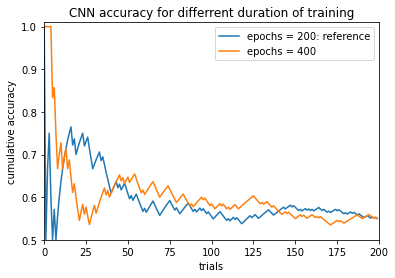

In [34]:
accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200 = [1.0, 0.5, 0.6666666666666666, 0.75, 0.6, 0.5, 0.5714285714285714, 0.5, 0.5555555555555556, 0.6, 0.6363636363636364, 0.6666666666666666, 0.6923076923076923, 0.7142857142857143, 0.7333333333333333, 0.75, 0.7647058823529411, 0.7222222222222222, 0.7368421052631579, 0.7, 0.7142857142857143, 0.7272727272727273, 0.7391304347826086, 0.75, 0.72, 0.7307692307692307, 0.7407407407407407, 0.7142857142857143, 0.6896551724137931, 0.6666666666666666, 0.6774193548387096, 0.6875, 0.696969696969697, 0.7058823529411765, 0.6857142857142857, 0.6944444444444444, 0.6756756756756757, 0.6578947368421053, 0.6410256410256411, 0.625, 0.6097560975609756, 0.6190476190476191, 0.627906976744186, 0.6363636363636364, 0.6222222222222222, 0.6304347826086957, 0.6170212765957447, 0.625, 0.6326530612244898, 0.62, 0.6078431372549019, 0.5961538461538461, 0.6037735849056604, 0.5925925925925926, 0.6, 0.6071428571428571, 0.5964912280701754, 0.5862068965517241, 0.576271186440678, 0.5666666666666667, 0.5737704918032787, 0.5645161290322581, 0.5714285714285714, 0.578125, 0.5846153846153846, 0.5909090909090909, 0.582089552238806, 0.5735294117647058, 0.5652173913043478, 0.5571428571428572, 0.5633802816901409, 0.5694444444444444, 0.5753424657534246, 0.581081081081081, 0.5866666666666667, 0.5921052631578947, 0.5844155844155844, 0.5769230769230769, 0.569620253164557, 0.575, 0.5679012345679012, 0.5609756097560976, 0.5662650602409639, 0.5714285714285714, 0.5764705882352941, 0.5813953488372093, 0.5862068965517241, 0.5795454545454546, 0.5730337078651685, 0.5666666666666667, 0.5714285714285714, 0.5652173913043478, 0.5698924731182796, 0.574468085106383, 0.5684210526315789, 0.5729166666666666, 0.5670103092783505, 0.5612244897959183, 0.5656565656565656, 0.56, 0.5544554455445545, 0.5490196078431373, 0.5533980582524272, 0.5576923076923077, 0.5619047619047619, 0.5660377358490566, 0.5607476635514018, 0.5555555555555556, 0.5504587155963303, 0.5454545454545454, 0.5495495495495496, 0.5446428571428571, 0.5486725663716814, 0.5526315789473685, 0.5478260869565217, 0.5517241379310345, 0.5470085470085471, 0.5423728813559322, 0.5378151260504201, 0.5416666666666666, 0.5454545454545454, 0.5491803278688525, 0.5528455284552846, 0.5564516129032258, 0.552, 0.5555555555555556, 0.5590551181102362, 0.5546875, 0.5503875968992248, 0.5538461538461539, 0.5572519083969466, 0.5606060606060606, 0.5639097744360902, 0.5671641791044776, 0.5703703703703704, 0.5661764705882353, 0.5620437956204379, 0.5579710144927537, 0.5611510791366906, 0.5642857142857143, 0.5673758865248227, 0.5704225352112676, 0.5734265734265734, 0.5763888888888888, 0.5724137931034483, 0.5753424657534246, 0.5782312925170068, 0.581081081081081, 0.5771812080536913, 0.58, 0.5761589403973509, 0.5723684210526315, 0.5686274509803921, 0.5714285714285714, 0.567741935483871, 0.5705128205128205, 0.5732484076433121, 0.569620253164557, 0.5723270440251572, 0.56875, 0.5714285714285714, 0.5679012345679012, 0.5705521472392638, 0.573170731707317, 0.5757575757575758, 0.572289156626506, 0.5688622754491018, 0.5714285714285714, 0.5680473372781065, 0.5647058823529412, 0.5672514619883041, 0.563953488372093, 0.5664739884393064, 0.5689655172413793, 0.5714285714285714, 0.5681818181818182, 0.5706214689265536, 0.5674157303370787, 0.5642458100558659, 0.5611111111111111, 0.56353591160221, 0.5604395604395604, 0.5628415300546448, 0.5652173913043478, 0.5621621621621622, 0.5645161290322581, 0.5614973262032086, 0.5585106382978723, 0.5608465608465608, 0.5578947368421052, 0.5549738219895288, 0.5520833333333334, 0.5544041450777202, 0.5567010309278351, 0.5538461538461539, 0.5510204081632653, 0.5532994923857868, 0.5505050505050505, 0.5527638190954773, 0.55]
accuracy_cumulative_cnn_cce_32_64_d025_ml0_e400 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.6666666666666666, 0.6923076923076923, 0.7142857142857143, 0.6666666666666666, 0.6875, 0.6470588235294118, 0.6111111111111112, 0.631578947368421, 0.6, 0.5714285714285714, 0.5454545454545454, 0.5652173913043478, 0.5833333333333334, 0.56, 0.5769230769230769, 0.5555555555555556, 0.5357142857142857, 0.5517241379310345, 0.5666666666666667, 0.5806451612903226, 0.5625, 0.5757575757575758, 0.5882352941176471, 0.6, 0.6111111111111112, 0.6216216216216216, 0.6052631578947368, 0.6153846153846154, 0.6, 0.6097560975609756, 0.6190476190476191, 0.627906976744186, 0.6363636363636364, 0.6444444444444445, 0.6521739130434783, 0.6382978723404256, 0.6458333333333334, 0.6326530612244898, 0.64, 0.6470588235294118, 0.6346153846153846, 0.6415094339622641, 0.6481481481481481, 0.6545454545454545, 0.6428571428571429, 0.631578947368421, 0.6206896551724138, 0.6101694915254238, 0.6166666666666667, 0.6065573770491803, 0.6129032258064516, 0.6190476190476191, 0.625, 0.6307692307692307, 0.6363636363636364, 0.6268656716417911, 0.6176470588235294, 0.6086956521739131, 0.6, 0.6056338028169014, 0.6111111111111112, 0.6164383561643836, 0.6216216216216216, 0.6266666666666667, 0.618421052631579, 0.6103896103896104, 0.6025641025641025, 0.5949367088607594, 0.5875, 0.5925925925925926, 0.5975609756097561, 0.6024096385542169, 0.6071428571428571, 0.6, 0.5930232558139535, 0.5862068965517241, 0.5795454545454546, 0.5842696629213483, 0.5777777777777777, 0.5824175824175825, 0.5869565217391305, 0.5913978494623656, 0.5957446808510638, 0.6, 0.59375, 0.5979381443298969, 0.5918367346938775, 0.5858585858585859, 0.58, 0.5841584158415841, 0.5784313725490197, 0.5728155339805825, 0.5769230769230769, 0.580952380952381, 0.5849056603773585, 0.5794392523364486, 0.5833333333333334, 0.5779816513761468, 0.5727272727272728, 0.5765765765765766, 0.5714285714285714, 0.5752212389380531, 0.5789473684210527, 0.5826086956521739, 0.5775862068965517, 0.5726495726495726, 0.576271186440678, 0.5798319327731093, 0.5833333333333334, 0.5867768595041323, 0.5901639344262295, 0.5934959349593496, 0.5967741935483871, 0.6, 0.6031746031746031, 0.5984251968503937, 0.59375, 0.5891472868217055, 0.5846153846153846, 0.5877862595419847, 0.5833333333333334, 0.5864661654135338, 0.5895522388059702, 0.5851851851851851, 0.5808823529411765, 0.5766423357664233, 0.5797101449275363, 0.5755395683453237, 0.5714285714285714, 0.5673758865248227, 0.5633802816901409, 0.5594405594405595, 0.5625, 0.5655172413793104, 0.5616438356164384, 0.564625850340136, 0.5608108108108109, 0.5570469798657718, 0.5533333333333333, 0.5496688741721855, 0.5526315789473685, 0.5555555555555556, 0.5584415584415584, 0.5548387096774193, 0.5576923076923077, 0.554140127388535, 0.5506329113924051, 0.5534591194968553, 0.55625, 0.5590062111801242, 0.5555555555555556, 0.5521472392638037, 0.5548780487804879, 0.5515151515151515, 0.5542168674698795, 0.5508982035928144, 0.5476190476190477, 0.5443786982248521, 0.5411764705882353, 0.5380116959064327, 0.5348837209302325, 0.5375722543352601, 0.5402298850574713, 0.5428571428571428, 0.5454545454545454, 0.5423728813559322, 0.5449438202247191, 0.5418994413407822, 0.5388888888888889, 0.5414364640883977, 0.5439560439560439, 0.546448087431694, 0.5489130434782609, 0.5513513513513514, 0.553763440860215, 0.5561497326203209, 0.5585106382978723, 0.5555555555555556, 0.5526315789473685, 0.5497382198952879, 0.5520833333333334, 0.5544041450777202, 0.5567010309278351, 0.558974358974359, 0.5561224489795918, 0.5532994923857868, 0.5505050505050505, 0.5527638190954773, 0.55]
plt.plot(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200)
plt.plot(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e400)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200))
plt.ylim(0.5,1.01)
plt.ylabel('cumulative accuracy')
plt.legend(['epochs = 200: reference', 'epochs = 400']) #cnn_cce_32_64_d0.25_ml0_e200
plt.title('CNN accuracy for differrent duration of training');

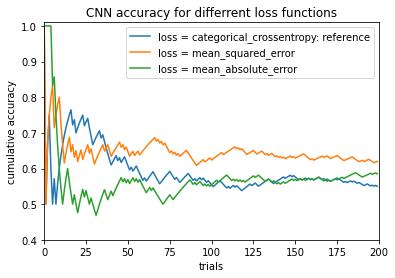

In [27]:
accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200 = [1.0, 0.5, 0.6666666666666666, 0.75, 0.6, 0.5, 0.5714285714285714, 0.5, 0.5555555555555556, 0.6, 0.6363636363636364, 0.6666666666666666, 0.6923076923076923, 0.7142857142857143, 0.7333333333333333, 0.75, 0.7647058823529411, 0.7222222222222222, 0.7368421052631579, 0.7, 0.7142857142857143, 0.7272727272727273, 0.7391304347826086, 0.75, 0.72, 0.7307692307692307, 0.7407407407407407, 0.7142857142857143, 0.6896551724137931, 0.6666666666666666, 0.6774193548387096, 0.6875, 0.696969696969697, 0.7058823529411765, 0.6857142857142857, 0.6944444444444444, 0.6756756756756757, 0.6578947368421053, 0.6410256410256411, 0.625, 0.6097560975609756, 0.6190476190476191, 0.627906976744186, 0.6363636363636364, 0.6222222222222222, 0.6304347826086957, 0.6170212765957447, 0.625, 0.6326530612244898, 0.62, 0.6078431372549019, 0.5961538461538461, 0.6037735849056604, 0.5925925925925926, 0.6, 0.6071428571428571, 0.5964912280701754, 0.5862068965517241, 0.576271186440678, 0.5666666666666667, 0.5737704918032787, 0.5645161290322581, 0.5714285714285714, 0.578125, 0.5846153846153846, 0.5909090909090909, 0.582089552238806, 0.5735294117647058, 0.5652173913043478, 0.5571428571428572, 0.5633802816901409, 0.5694444444444444, 0.5753424657534246, 0.581081081081081, 0.5866666666666667, 0.5921052631578947, 0.5844155844155844, 0.5769230769230769, 0.569620253164557, 0.575, 0.5679012345679012, 0.5609756097560976, 0.5662650602409639, 0.5714285714285714, 0.5764705882352941, 0.5813953488372093, 0.5862068965517241, 0.5795454545454546, 0.5730337078651685, 0.5666666666666667, 0.5714285714285714, 0.5652173913043478, 0.5698924731182796, 0.574468085106383, 0.5684210526315789, 0.5729166666666666, 0.5670103092783505, 0.5612244897959183, 0.5656565656565656, 0.56, 0.5544554455445545, 0.5490196078431373, 0.5533980582524272, 0.5576923076923077, 0.5619047619047619, 0.5660377358490566, 0.5607476635514018, 0.5555555555555556, 0.5504587155963303, 0.5454545454545454, 0.5495495495495496, 0.5446428571428571, 0.5486725663716814, 0.5526315789473685, 0.5478260869565217, 0.5517241379310345, 0.5470085470085471, 0.5423728813559322, 0.5378151260504201, 0.5416666666666666, 0.5454545454545454, 0.5491803278688525, 0.5528455284552846, 0.5564516129032258, 0.552, 0.5555555555555556, 0.5590551181102362, 0.5546875, 0.5503875968992248, 0.5538461538461539, 0.5572519083969466, 0.5606060606060606, 0.5639097744360902, 0.5671641791044776, 0.5703703703703704, 0.5661764705882353, 0.5620437956204379, 0.5579710144927537, 0.5611510791366906, 0.5642857142857143, 0.5673758865248227, 0.5704225352112676, 0.5734265734265734, 0.5763888888888888, 0.5724137931034483, 0.5753424657534246, 0.5782312925170068, 0.581081081081081, 0.5771812080536913, 0.58, 0.5761589403973509, 0.5723684210526315, 0.5686274509803921, 0.5714285714285714, 0.567741935483871, 0.5705128205128205, 0.5732484076433121, 0.569620253164557, 0.5723270440251572, 0.56875, 0.5714285714285714, 0.5679012345679012, 0.5705521472392638, 0.573170731707317, 0.5757575757575758, 0.572289156626506, 0.5688622754491018, 0.5714285714285714, 0.5680473372781065, 0.5647058823529412, 0.5672514619883041, 0.563953488372093, 0.5664739884393064, 0.5689655172413793, 0.5714285714285714, 0.5681818181818182, 0.5706214689265536, 0.5674157303370787, 0.5642458100558659, 0.5611111111111111, 0.56353591160221, 0.5604395604395604, 0.5628415300546448, 0.5652173913043478, 0.5621621621621622, 0.5645161290322581, 0.5614973262032086, 0.5585106382978723, 0.5608465608465608, 0.5578947368421052, 0.5549738219895288, 0.5520833333333334, 0.5544041450777202, 0.5567010309278351, 0.5538461538461539, 0.5510204081632653, 0.5532994923857868, 0.5505050505050505, 0.5527638190954773, 0.55]
accuracy_cumulative_cnn_mse_32_64_d025_ml0_e200 = [1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8, 0.7272727272727273, 0.6666666666666666, 0.6153846153846154, 0.6428571428571429, 0.6666666666666666, 0.6875, 0.6470588235294118, 0.6666666666666666, 0.631578947368421, 0.65, 0.6190476190476191, 0.6363636363636364, 0.6521739130434783, 0.625, 0.64, 0.6538461538461539, 0.6666666666666666, 0.6428571428571429, 0.6551724137931034, 0.6333333333333333, 0.6129032258064516, 0.625, 0.6363636363636364, 0.6470588235294118, 0.6571428571428571, 0.6666666666666666, 0.6486486486486487, 0.6578947368421053, 0.6666666666666666, 0.65, 0.6341463414634146, 0.6428571428571429, 0.6511627906976745, 0.6590909090909091, 0.6666666666666666, 0.6739130434782609, 0.6595744680851063, 0.6666666666666666, 0.6530612244897959, 0.66, 0.6470588235294118, 0.6346153846153846, 0.6415094339622641, 0.6481481481481481, 0.6363636363636364, 0.6428571428571429, 0.6491228070175439, 0.6379310344827587, 0.6440677966101694, 0.65, 0.6557377049180327, 0.6612903225806451, 0.6666666666666666, 0.671875, 0.676923076923077, 0.6818181818181818, 0.6865671641791045, 0.6764705882352942, 0.6811594202898551, 0.6714285714285714, 0.676056338028169, 0.6666666666666666, 0.6712328767123288, 0.6621621621621622, 0.6533333333333333, 0.6447368421052632, 0.6493506493506493, 0.6410256410256411, 0.6455696202531646, 0.6375, 0.6419753086419753, 0.6341463414634146, 0.6385542168674698, 0.6428571428571429, 0.6470588235294118, 0.6511627906976745, 0.6436781609195402, 0.6363636363636364, 0.6292134831460674, 0.6222222222222222, 0.6153846153846154, 0.6086956521739131, 0.6129032258064516, 0.6170212765957447, 0.6210526315789474, 0.625, 0.6185567010309279, 0.6224489795918368, 0.6262626262626263, 0.63, 0.6237623762376238, 0.6274509803921569, 0.6310679611650486, 0.6346153846153846, 0.638095238095238, 0.6415094339622641, 0.6448598130841121, 0.6388888888888888, 0.6422018348623854, 0.6454545454545455, 0.6486486486486487, 0.6517857142857143, 0.6548672566371682, 0.6578947368421053, 0.6608695652173913, 0.6551724137931034, 0.6581196581196581, 0.652542372881356, 0.6554621848739496, 0.65, 0.6446280991735537, 0.639344262295082, 0.6422764227642277, 0.6451612903225806, 0.648, 0.6507936507936508, 0.6456692913385826, 0.640625, 0.6434108527131783, 0.6461538461538462, 0.648854961832061, 0.6439393939393939, 0.6390977443609023, 0.6417910447761194, 0.6370370370370371, 0.6397058823529411, 0.6423357664233577, 0.6376811594202898, 0.6330935251798561, 0.6357142857142857, 0.6312056737588653, 0.6338028169014085, 0.6293706293706294, 0.6319444444444444, 0.6275862068965518, 0.6301369863013698, 0.6326530612244898, 0.6351351351351351, 0.6308724832214765, 0.6333333333333333, 0.6291390728476821, 0.631578947368421, 0.6339869281045751, 0.6363636363636364, 0.6387096774193548, 0.6410256410256411, 0.6369426751592356, 0.6329113924050633, 0.6289308176100629, 0.625, 0.6273291925465838, 0.6234567901234568, 0.6257668711656442, 0.6280487804878049, 0.6303030303030303, 0.6325301204819277, 0.6347305389221557, 0.6309523809523809, 0.6331360946745562, 0.6352941176470588, 0.631578947368421, 0.627906976744186, 0.630057803468208, 0.632183908045977, 0.6342857142857142, 0.6363636363636364, 0.632768361581921, 0.6292134831460674, 0.6256983240223464, 0.6222222222222222, 0.6243093922651933, 0.6263736263736264, 0.6284153005464481, 0.6304347826086957, 0.6324324324324324, 0.6290322580645161, 0.6256684491978609, 0.6223404255319149, 0.6190476190476191, 0.6210526315789474, 0.6230366492146597, 0.6197916666666666, 0.6217616580310881, 0.6237113402061856, 0.6256410256410256, 0.6224489795918368, 0.6192893401015228, 0.6161616161616161, 0.6180904522613065, 0.62]
accuracy_cumulative_cnn_mae_32_64_d025_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.75, 0.6666666666666666, 0.6, 0.5454545454545454, 0.5, 0.5384615384615384, 0.5714285714285714, 0.6, 0.5625, 0.5294117647058824, 0.5, 0.5263157894736842, 0.5, 0.47619047619047616, 0.5, 0.5217391304347826, 0.5416666666666666, 0.52, 0.5384615384615384, 0.5185185185185185, 0.5, 0.5172413793103449, 0.5, 0.4838709677419355, 0.46875, 0.48484848484848486, 0.5, 0.5142857142857142, 0.5277777777777778, 0.5405405405405406, 0.5263157894736842, 0.5128205128205128, 0.525, 0.5365853658536586, 0.5238095238095238, 0.5348837209302325, 0.5454545454545454, 0.5555555555555556, 0.5652173913043478, 0.574468085106383, 0.5625, 0.5714285714285714, 0.56, 0.5686274509803921, 0.5576923076923077, 0.5660377358490566, 0.5740740740740741, 0.5636363636363636, 0.5714285714285714, 0.5614035087719298, 0.5689655172413793, 0.559322033898305, 0.55, 0.5409836065573771, 0.532258064516129, 0.5396825396825397, 0.546875, 0.5384615384615384, 0.5454545454545454, 0.5373134328358209, 0.5294117647058824, 0.5217391304347826, 0.5142857142857142, 0.5070422535211268, 0.5, 0.5068493150684932, 0.5135135135135135, 0.52, 0.5263157894736842, 0.5194805194805194, 0.5128205128205128, 0.5189873417721519, 0.525, 0.5308641975308642, 0.5365853658536586, 0.5421686746987951, 0.5476190476190477, 0.5529411764705883, 0.5581395348837209, 0.5632183908045977, 0.5681818181818182, 0.5617977528089888, 0.5555555555555556, 0.5604395604395604, 0.5543478260869565, 0.5591397849462365, 0.5638297872340425, 0.5578947368421052, 0.5520833333333334, 0.5567010309278351, 0.5510204081632653, 0.5555555555555556, 0.55, 0.5544554455445545, 0.5588235294117647, 0.5631067961165048, 0.5673076923076923, 0.5619047619047619, 0.5660377358490566, 0.5700934579439252, 0.5740740740740741, 0.5779816513761468, 0.5818181818181818, 0.5765765765765766, 0.5714285714285714, 0.5663716814159292, 0.5701754385964912, 0.5652173913043478, 0.5689655172413793, 0.5641025641025641, 0.5677966101694916, 0.5630252100840336, 0.5666666666666667, 0.5619834710743802, 0.5655737704918032, 0.5691056910569106, 0.5725806451612904, 0.576, 0.5793650793650794, 0.5748031496062992, 0.578125, 0.5813953488372093, 0.5769230769230769, 0.5725190839694656, 0.5681818181818182, 0.5639097744360902, 0.5671641791044776, 0.5703703703703704, 0.5661764705882353, 0.5620437956204379, 0.5652173913043478, 0.5611510791366906, 0.5571428571428572, 0.5602836879432624, 0.5563380281690141, 0.5594405594405595, 0.5625, 0.5586206896551724, 0.5616438356164384, 0.564625850340136, 0.5675675675675675, 0.5704697986577181, 0.5666666666666667, 0.5695364238410596, 0.5657894736842105, 0.5686274509803921, 0.5714285714285714, 0.567741935483871, 0.5705128205128205, 0.5668789808917197, 0.569620253164557, 0.5723270440251572, 0.56875, 0.5714285714285714, 0.5679012345679012, 0.5705521472392638, 0.573170731707317, 0.5757575757575758, 0.572289156626506, 0.5688622754491018, 0.5654761904761905, 0.5680473372781065, 0.5705882352941176, 0.5672514619883041, 0.563953488372093, 0.5664739884393064, 0.5689655172413793, 0.5714285714285714, 0.5738636363636364, 0.5706214689265536, 0.5730337078651685, 0.5754189944134078, 0.5722222222222222, 0.574585635359116, 0.5769230769230769, 0.5792349726775956, 0.5815217391304348, 0.5837837837837838, 0.5860215053763441, 0.5882352941176471, 0.5851063829787234, 0.582010582010582, 0.5789473684210527, 0.5759162303664922, 0.578125, 0.5803108808290155, 0.5824742268041238, 0.5846153846153846, 0.5867346938775511, 0.583756345177665, 0.5858585858585859, 0.5879396984924623, 0.585]
plt.plot(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200)
plt.plot(accuracy_cumulative_cnn_mse_32_64_d025_ml0_e200)
plt.plot(accuracy_cumulative_cnn_mae_32_64_d025_ml0_e200)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200))
plt.ylim(0.4,1.01)
plt.ylabel('cumulative accuracy')
plt.legend(['loss = categorical_crossentropy: reference', 'loss = mean_squared_error', 'loss = mean_absolute_error']) #cnn_cce_32_64_d0.25_ml0_e200
plt.title('CNN accuracy for differrent loss functions');

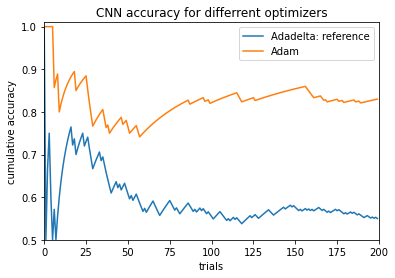

In [31]:
accuracy_cumulative_cnn_cce_Adam_32_64_d025_ml0_e200 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.8, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8518518518518519, 0.8214285714285714, 0.7931034482758621, 0.7666666666666667, 0.7741935483870968, 0.78125, 0.7878787878787878, 0.7941176470588235, 0.8, 0.8055555555555556, 0.7837837837837838, 0.7631578947368421, 0.7692307692307693, 0.75, 0.7560975609756098, 0.7619047619047619, 0.7674418604651163, 0.7727272727272727, 0.7777777777777778, 0.782608695652174, 0.7872340425531915, 0.7708333333333334, 0.7755102040816326, 0.78, 0.7647058823529411, 0.75, 0.7547169811320755, 0.7592592592592593, 0.7636363636363637, 0.7678571428571429, 0.7543859649122807, 0.7413793103448276, 0.7457627118644068, 0.75, 0.7540983606557377, 0.7580645161290323, 0.7619047619047619, 0.765625, 0.7692307692307693, 0.7727272727272727, 0.7761194029850746, 0.7794117647058824, 0.782608695652174, 0.7857142857142857, 0.7887323943661971, 0.7916666666666666, 0.7945205479452054, 0.7972972972972973, 0.8, 0.8026315789473685, 0.8051948051948052, 0.8076923076923077, 0.810126582278481, 0.8125, 0.8148148148148148, 0.8170731707317073, 0.8192771084337349, 0.8214285714285714, 0.8235294117647058, 0.8255813953488372, 0.8275862068965517, 0.8181818181818182, 0.8202247191011236, 0.8222222222222222, 0.8241758241758241, 0.8260869565217391, 0.8279569892473119, 0.8297872340425532, 0.8315789473684211, 0.8333333333333334, 0.8247422680412371, 0.826530612244898, 0.8282828282828283, 0.82, 0.8217821782178217, 0.8235294117647058, 0.8252427184466019, 0.8269230769230769, 0.8285714285714286, 0.8301886792452831, 0.8317757009345794, 0.8333333333333334, 0.8348623853211009, 0.8363636363636363, 0.8378378378378378, 0.8392857142857143, 0.8407079646017699, 0.8421052631578947, 0.8434782608695652, 0.8448275862068966, 0.8376068376068376, 0.8305084745762712, 0.8235294117647058, 0.825, 0.8264462809917356, 0.8278688524590164, 0.8292682926829268, 0.8306451612903226, 0.832, 0.8333333333333334, 0.8267716535433071, 0.828125, 0.8294573643410853, 0.8307692307692308, 0.8320610687022901, 0.8333333333333334, 0.8345864661654135, 0.835820895522388, 0.837037037037037, 0.8382352941176471, 0.8394160583941606, 0.8405797101449275, 0.841726618705036, 0.8428571428571429, 0.8439716312056738, 0.8450704225352113, 0.8461538461538461, 0.8472222222222222, 0.8482758620689655, 0.8493150684931506, 0.8503401360544217, 0.8513513513513513, 0.8523489932885906, 0.8533333333333334, 0.8543046357615894, 0.8552631578947368, 0.8562091503267973, 0.8571428571428571, 0.8580645161290322, 0.8589743589743589, 0.8598726114649682, 0.8544303797468354, 0.8490566037735849, 0.84375, 0.8385093167701864, 0.8333333333333334, 0.8343558282208589, 0.8353658536585366, 0.8363636363636363, 0.8373493975903614, 0.8323353293413174, 0.8273809523809523, 0.8284023668639053, 0.8235294117647058, 0.8245614035087719, 0.8255813953488372, 0.8265895953757225, 0.8275862068965517, 0.8285714285714286, 0.8295454545454546, 0.8248587570621468, 0.8258426966292135, 0.8268156424581006, 0.8222222222222222, 0.8232044198895028, 0.8241758241758241, 0.825136612021858, 0.8260869565217391, 0.827027027027027, 0.8279569892473119, 0.8235294117647058, 0.824468085106383, 0.8253968253968254, 0.8210526315789474, 0.8219895287958116, 0.8229166666666666, 0.8238341968911918, 0.8247422680412371, 0.8256410256410256, 0.826530612244898, 0.8274111675126904, 0.8282828282828283, 0.8291457286432161, 0.83]
plt.plot(accuracy_cumulative_cnn_cce_32_64_d025_ml0_e200)
plt.plot(accuracy_cumulative_cnn_cce_Adam_32_64_d025_ml0_e200)
plt.xlabel('trials')
plt.xlim(0,len(accuracy_cumulative_cnn_cce_Adam_32_64_d025_ml0_e200))
plt.ylim(0.5,1.01)
plt.ylabel('cumulative accuracy')
plt.legend(['Adadelta: reference', 'Adam'])
plt.title('CNN accuracy for differrent optimizers');

## 6. Conclusions
1) It is well worth saving misclassified digit images and their correct labels for re-training of the model. This can be seen from the following table of accuracy of handwritten digit recognition after 500 trials.

|Manual labels|Accuracy|
|:--:|:------:|
|0  |0.694|
|200|0.836|
|400|0.924|
|600|0.934|

2) After adding 200 manually labeled images, test accuracy has slightly decreased (from 0.975200 to 0.974100), while the actual performance of digit recognition of the images drawn in the GUI window has strongly increased. Thus, training accuracy is not a reliable metric of actual performance.

3) NN model is prone to overfitting: the accuracy for 400 training epochs is significantly lower than for 200 epochs when not using manual labels. Keep the number of epochs below 400.

4) Accuracy is sensitive to the number of neurons in the 2nd layer: 50 neurons has a higher accuracy of 0.694 (after 500 trials) compared to 25 neurons with accuracy of 0.573333 and 75 neurons with accuracy of 0.566667 (after 150 trials). If there is one maximum of accuracy versus the number of neurons, then we have localized the lower and upper boundary for this hyperparameter.

5) Dropout between the two layers of NN model lowers the accuracy.

## 7. Future Directions
* Compare the accuracy of recognition of original handwriter whose manual labels were used to re-train the NN model to the accuracy values for another handwriter using the same models.
* Narrow down the optimal ranges of all hyperparameters within current NN and CNN configurations, including number of neurons in each hidden layer and dropout rates after each layer, loss function, optimizer, and activation functions.
* Test different numbers of layers.
* Minimize the number of control buttons in the GUI to simplify and speedup the process of dealing with misclassified digit. For instance, try to implement input of correct label via hitting Enter key, which would allow to eliminate the button 'Get label'.
* Enable creation of new classes for letter symbols. This would require to switch from integer to string variables for the labels.